In [1]:
# # #  IMPORT PACKAGES, LIBRARIES & RAW DATASETS # # # 

In [2]:
%matplotlib inline
import re
import string
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import sys
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
# import nltk
# # nltk.download(stopwords)
# import boto3
# import io
# import sagemaker.amazon.common as smac
# import sagemaker
# from sagemaker import get_execution_role

In [3]:
# role = get_execution_role()
# input_bucket = 'project-thunderbirds-storage'
# in_data_key = 'test_and_train_dataset_utf8.csv'
# training_data_location = 's3://{}/{}'.format(input_bucket, in_data_key)
# dataset_unprocessed = pd.read_csv(training_data_location, 
#                                                  dtype={"split": "string", "message": "string", "genre": "string"})
print('uploaded training data from location: {}'.format(training_data_location))
dataset_unprocessed = pd.read_csv('../Datasets/combined_dataset_all.csv', 
                                                 encoding = "ISO-8859-1", dtype={"split": "string", "message": "string", "genre": "string"})

In [4]:
# # #  DATA ANALYSIS & PROCESSING # # # 

In [5]:
# converting any 0 to 2 (translates to NOT disaster related)
dataset= dataset_unprocessed.replace(2,0)

In [6]:
dataset.head(10)

split                                            message   genre  related  \
0  train  Weather update - a cold front from Cuba that c...  direct        1   
1  train            Is the Hurricane over or is it not over  direct        1   
2  train  says: west side of Haiti, rest of the country ...  direct        1   
3  train                     Storm at sacred heart of jesus  direct        1   
4  train  Please, we need tents and water. We are in Sil...  direct        1   
5  train  There's nothing to eat and water, we starving ...  direct        1   
6  train  I am in Thomassin number 32, in the area named...  direct        1   
7  train  Let's do it together, need food in Delma 75, i...  direct        1   
8  train  More information on the 4636 number in order f...  direct        1   
9  train  A Comitee in Delmas 19, Rue ( street ) Janvier...  direct        1   

   PII  request  offer  aid_related  medical_help  medical_products  ...  \
0    0        0      0            0             0                 0  ...   
1    0        0      0            1             0                 0  ...   
2    0        0      0            0             0                 0  ...   
3    0        0      0            0             0                 0  ...   
4    0        1      0            1             0                 0  ...   
5    0        1      0            1             1                 1  ...   
6    0        1      0            1             0                 0  ...   
7    0        1      0            1             0                 0  ...   
8    0        0      0            0             0                 0  ...   
9    0        1      0            1             0                 1  ...   

   aid_centers  other_infrastructure  weather_related  floods  storm  fire  \
0            0                     0                0       0      0     0   
1            0                     0                1       0      1     0   
2            0                     0                0       0      0     0   
3            0                     0                1       0      1     0   
4            0                     0                0       0      0     0   
5            0                     1                1       1      0     0   
6            0                     0                0       0      0     0   
7            0                     0                0       0      0     0   
8            0                     0                0       0      0     0   
9            0                     0                0       0      0     0   

   earthquake  cold  other_weather  direct_report  
0           0     0              0              0  
1           0     0              0              0  
2           0     0              0              0  
3           0     0              0              0  
4           0     0              0              1  
5           0     0              0              1  
6           0     0              0              1  
7           0     0              0              1  
8           0     0              0              0  
9           0     0              0              1  

[10 rows x 40 columns]

In [7]:
dataset.shape

(38263, 40)

In [8]:
dataset['genre'].unique()

<StringArray>
['direct', 'social', 'news']
Length: 3, dtype: string

In [9]:
dataset['related'].value_counts()

1    20928
0    17335
Name: related, dtype: int64

In [10]:
dataset['genre'].value_counts()

social    19241
news      11090
direct     7932
Name: genre, dtype: Int64

In [11]:
dataset.dtypes

split                     string
message                   string
genre                     string
related                    int64
PII                        int64
request                    int64
offer                      int64
aid_related                int64
medical_help               int64
medical_products           int64
search_and_rescue          int64
security                   int64
military                   int64
child_alone                int64
water                      int64
food                       int64
shelter                    int64
clothing                   int64
money                      int64
missing_people             int64
refugees                   int64
death                      int64
other_aid                  int64
infrastructure_related     int64
transport                  int64
buildings                  int64
electricity                int64
tools                      int64
hospitals                  int64
shops                      int64
aid_center

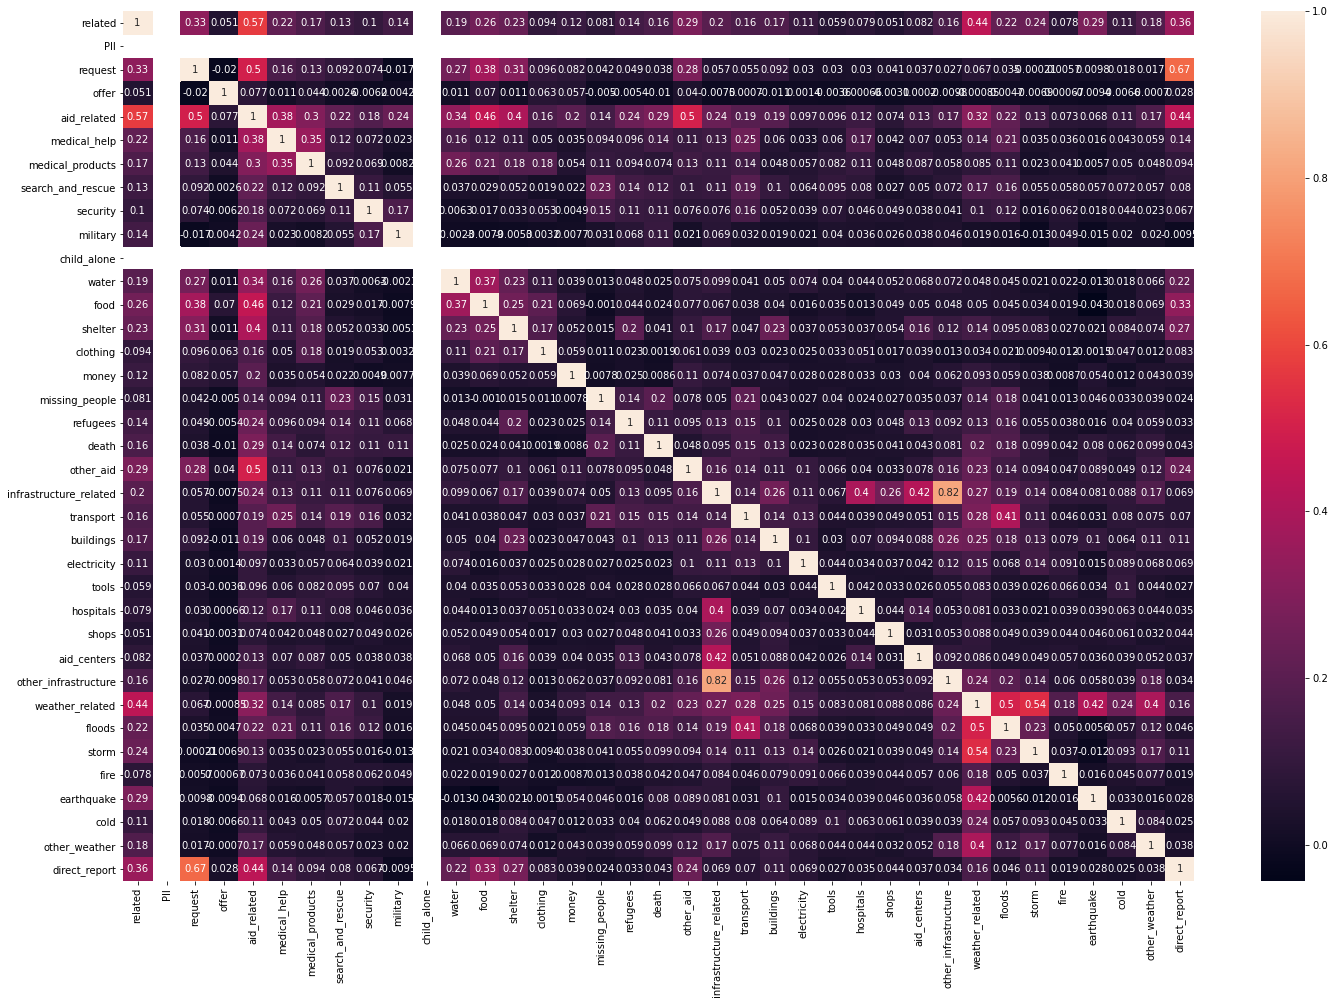

In [12]:
# use high correlations to identfiy tags that can be removed
dataset_corr = dataset.corr()
fig, ax = plt.subplots(figsize=(24,16))

sns.heatmap(dataset_corr, annot=True)

In [13]:
# minimising the dataset for R&I
dataset.drop(dataset.columns.difference(['message', 'related', 'cold','earthquake', 'fire', 'storm', 'medical_help','water','food','shelter','electricity','missing_people','infrastructure_related','hospitals']), 1, inplace=True)

In [14]:
dataset.sample(5)

message  related  \
19159  @overheardatmoo Wish I could have participated...        0   
10605  That is the only thing which will stop these s...        1   
18712  Still a bit sick  But working on 2 articles today        0   
5028   Is it possible to have another earthquake of 7...        1   
6953   This is why I love hurricanes Riding all night...        1   

       medical_help  water  food  shelter  missing_people  \
19159             0      0     0        0               0   
10605             0      0     0        0               0   
18712             0      0     0        0               0   
5028              0      0     0        0               0   
6953              0      0     0        0               0   

       infrastructure_related  electricity  hospitals  storm  fire  \
19159                       0            0          0      0     0   
10605                       0            0          0      0     0   
18712                       0            0          0      0     0   
5028                        0            0          0      0     0   
6953                        0            0          0      1     0   

       earthquake  cold  
19159           0     0  
10605           0     0  
18712           0     0  
5028            1     0  
6953            0     0

In [15]:
# Identifying the number of comments in each category (disaster related & weather related)
dr_tags = dataset.drop(['message'], axis=1)
counts = []
categories = list(dr_tags.columns.values)
for i in categories:
    counts.append((i, dr_tags[i].sum()))
dr_tags_stats = pd.DataFrame(counts, columns=['category', 'number_of_messages'])

In [16]:
# number of comments in each category
dr_tags_stats

category  number_of_messages
0                  related               20928
1             medical_help                2087
2                    water                1674
3                     food                2930
4                  shelter                2319
5           missing_people                 299
6   infrastructure_related                1705
7              electricity                 534
8                hospitals                 283
9                    storm                2448
10                    fire                 282
11              earthquake                3453
12                    cold                 530

In [17]:
# total number of rows in each category (about 1/4 are weather related and 3/4 are disaster related)
dr_tags.count()

related                   38263
medical_help              38263
water                     38263
food                      38263
shelter                   38263
missing_people            38263
infrastructure_related    38263
electricity               38263
hospitals                 38263
storm                     38263
fire                      38263
earthquake                38263
cold                      38263
dtype: int64

Text(0.5, 0, 'category')

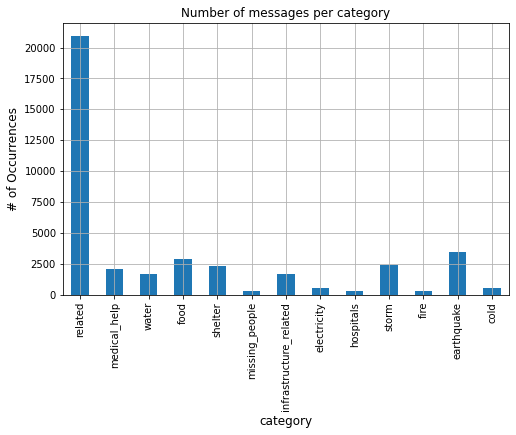

In [18]:
# visualising the categories
dr_tags_stats.plot(x='category', y='number_of_messages', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of messages per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

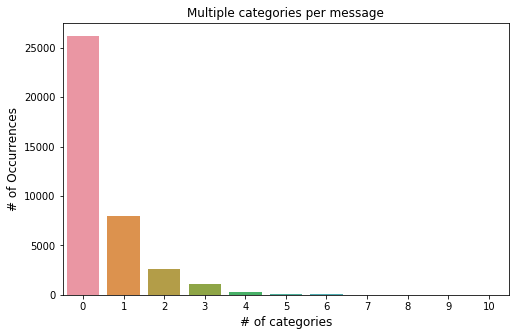

In [19]:
# How many comments have multi labels?
rowsums = dataset.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per message")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

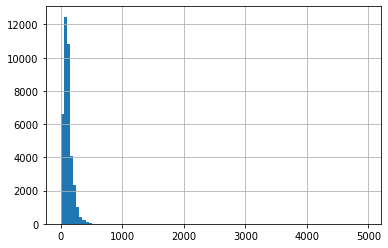

In [20]:
# distribution of the number of words: nothing above 600
# ylabel = number of messages
# xlabel = number of characters
lens = dataset.message.str.len()
lens.hist(bins = np.arange(0,5000,50))

In [21]:
print('Number of missing messages in message text:')
dataset['message'].isnull().sum()

Number of missing messages in message text:


0

In [22]:
# minimising the dataset further ready for model training
dataset.drop(dataset.columns.difference(['message', 'related']), 1, inplace=True)

In [23]:
dataset.sample(5)

message  related
20208  @SarahNicholas poor you, I once asked for pale...        0
24872  @IAMtheCOMMODORE i couldnt make it ! &gt;.&lt;...        0
404    starting from saint michel delatalay we have p...        1
6385   martelozzo Eu nÃ¢ÂÂÃÂ ÃÂ¶ÃÂ¬ÃÂ£o to em S...        0
9415         The cold wheather is increasing day by day.        1

In [24]:
# # # DATA CLEANING # # #

In [25]:
# having apeek at the first message
dataset['message'][0]

'Weather update - a cold front from Cuba that could pass over Haiti'

In [26]:
# function to clean the data
def clean_text(text):
    # make all text lowercase
    text = text.lower()
    # substitute common abbreviations
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    # removes any leading spaces at the beginning and trailing spaces at the end
    text = text.strip(' ')
    # new bit
    # remove punctuations
    words = text.split()
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in words]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # stemming of words
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    seperator = " "
    text = seperator.join(words)
    # print the keywords returned for analysis    
    print(words)
    print("---")
    return text

In [27]:
dataset['message'] = dataset['message'].map(lambda com : clean_text(com))

['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pass', 'haiti']
---
['hurricane']
---
['says', 'west', 'side', 'haiti', 'rest', 'country', 'today', 'tonight']
---
['storm', 'sacred', 'heart', 'jesus']
---
['please', 'need', 'tents', 'water', 'silo', 'thank']
---
['nothing', 'eat', 'water', 'starving', 'thirsty']
---
['thomassin', 'number', 'area', 'named', 'pyron', 'would', 'like', 'water', 'thank', 'god', 'fine', 'desperately', 'need', 'water', 'thanks']
---
['let', 'together', 'need', 'food', 'delma', 'didine', 'area']
---
['information', 'number', 'order', 'participate', 'see', 'use']
---
['comitee', 'delmas', 'rue', 'street', 'janvier', 'impasse', 'charite', 'people', 'temporary', 'shelter', 'dire', 'need', 'water', 'food', 'medications', 'tents', 'clothes', 'please', 'stop', 'see', 'us']
---
['need', 'food', 'water', 'klecin', 'dying', 'hunger', 'impasse', 'chretien', 'klecin', 'extended', 'extension', 'hungry', 'sick']
---
['would', 'like', 'know', 'earthquake', 'thanks'

['friends', 'living', 'difficult', 'situation', 'family', 'living', 'paris', 'want', 'communicate', 'need', 'help', 'put', 'top', 'phone', 'incomplete', 'contextual', 'educated', 'guess', 'mete', 'ti', 'kat', 'pou', 'mwen', 'please', 'top', 'phone']
---
['afka', 'oragnisation', 'city', 'arcahaie', 'lot', 'houses', 'damaged', 'need', 'help']
---
['simple', 'citizen', 'lives', 'area', 'mole', 'saint', 'nicolas', 'missing', 'word', 'probably', 'want', 'haitian', 'international', 'leaders', 'know', 'area', 'also', 'need', 'obscured', 'symbol', 'probably', 'aid', 'cut']
---
['us', 'temporary', 'shelter', 'grand', 'goave', 'every', 'day', 'people', 'coming', 'lot', 'problems', 'like', 'need', 'drinkable', 'water', 'food', 'medicine']
---
['asking', 'shelter', 'asking', 'help', 'please', 'take', 'anymore', 'things', 'become', 'expansive', 'money', 'buy', 'grand', 'goave', 'kanpion', 'campion', 'message', 'incomplete']
---
['even', 'clothes', 'wear']
---
['reponsable', 'authorities', 'please',

['received', 'anything', 'terms', 'aid', 'example', 'nee', 'food', 'medicine', 'doctors', 'tents', 'sleep', 'okay', 'sid']
---
['help', 'us', 'pelerin', 'provide', 'transportation']
---
['hello', 'sent', 'sms', 'alredy', 'yet', 'recive', 'aid', 'please', 'respond', 'give', 'site', 'west', 'rue', 'terre', 'rouge', 'ebenezer', 'church']
---
['scout', 'south', 'cayes', 'camp', 'perrin', 'eats', 'localize', 'locals', 'scout', 'south', 'cayes', 'camp', 'perrin', 'food', 'local', 'people', 'gps', 'location', 'may', 'verify', 'look', 'camp', 'perrin']
---
['hi', 'leave', 'gressier', 'really', 'far', 'nobody', 'ever', 'showed', 'help', 'us']
---
['people', 'dead', 'living', 'hungry', 'please', 'help', 'us']
---
['cyber', 'cafe', 'carefour', 'wayne', 'working', 'sent', 'rep', 'bring', 'food', 'us', 'waiting', 'help']
---
['many', 'us', 'mangonese', 'street', 'christ', 'roi', 'pap', 'need', 'food', 'water', 'tents', 'medical', 'assistance']
---
['urjent', 'need', 'need', 'food', 'pver', 'people'

['located', 'rue', 'st', 'martin', 'close', 'ruelle', 'mariela', 'need', 'help', 'since', 'earthquake', 'sleep', 'streets', 'need', 'water', 'food', 'tents', 'committee', 'sta', 'note', 'message', 'truncated', 'call', 'details']
---
['food', 'water', 'needed', 'benoit', 'batraville', 'school', 'laboule']
---
['address', 'radio', 'station', 'ask', 'need', 'drop', 'file', 'committee', 'created', 'thanks', 'advance']
---
['find', 'anything', 'even', 'little', 'water', 'help']
---
['location', 'dont', 'know', 'help', 'us', 'please']
---
['streets', 'dress', 'help', 'please']
---
['victim', 'south', 'department', 'aquin', 'havent', 'found', 'help', 'yet', 'lot', 'people', 'area', 'help', 'still']
---
['please', 'brothers', 'help', 'things', 'going', 'harder', 'harder', 'life', 'really', 'expensive', 'please', 'help']
---
['lot', 'people', 'left', 'city', 'go', 'province', 'rural', 'areas', 'need', 'encourage', 'decentralization', 'create', 'work', 'camp']
---
['called', 'radio', 'station', 

['leogane', 'red', 'gate', 'section', 'want', 'help', 'becaus', 'victim']
---
['good', 'evening', 'ile', 'de', 'la', 'tortue', 'lot', 'students', 'victims', 'port', 'au', 'prince', 'doiing', 'victims', 'lot', 'tue']
---
['us', 'need', 'help', 'suffering', 'hear', 'us']
---
['people', 'temporary', 'shelter', 'grand', 'goave', 'every', 'day', 'people', 'coming', 'lot', 'issues', 'drinking', 'water', 'food', 'medicine']
---
['mariani', 'prolong', 'received', 'even', 'drop', 'water']
---
['im', 'desalin', 'street', 'kastro', 'land', 'thanks']
---
['house', 'crushed', 'child', 'im', 'hungry', 'dont', 'clean', 'water', 'drink', 'need', 'much', 'im', 'gresye', 'billy', 'beach']
---
['comunity', 'called', 'kokoye', 'coconut', 'croix', 'des', 'bouquet', 'street']
---
['di', 'receive', 'nothing', 'yet', 'plaine', 'cul', 'de', 'sac', 'located', 'santo', 'empasse', 'souverin', 'number', 'thanks']
---
['hello', 'digicel', 'writing', 'tell', 'lot', 'problems', 'house', 'destroyed', 'food', 'water', 

['people', 'plaisance', 'north', 'country', 'problems', 'houses', 'people', 'came', 'pap', 'anything', 'eat', 'time', 'need', 'help']
---
['son', 'would', 'hurt', 'took', 'away', 'treatment', 'know', 'hospital']
---
['evening', 'true', 'aftershake', 'first', 'one']
---
['lot', 'people', 'saying', 'take', 'govt', 'buses', 'go', 'provinces', 'able', 'come', 'back', 'port', 'au', 'prince', 'true']
---
['would', 'like', 'know', 'aftershocks', 'going', 'end', 'thank', 'willy']
---
['child', 'would', 'like', 'foreigners', 'adopt', 'take', 'care']
---
['basically', 'said', 'unemployment', 'hunger', 'anymore', 'drinkable', 'water', 'school']
---
['hi', 'concerned', 'situation', 'haiti', 'country', 'writing', 'could', 'tell', 'us', 'conditions', 'country']
---
['would', 'like', 'know', 'done', 'police', 'officers', 'whose', 'houses', 'broken', 'families', 'hungry', 'died']
---
['person', 'asking', 'confirmation', 'possible', 'aftershake', 'week', 'end']
---
['would', 'like', 'know', 'aftershock

['gens', 'ont', 'information', 'qui', 'dit', 'que', 'si', 'moins', 'citoyens', 'americains', 'vit', 'ici', 'l', 'que', 'tout', 'aller', 'ok', 'tout', 'le', 'monde', 'vite', 'fil', 'pour', 'qu', 'essaie', 'survivre', 'people', 'information', 'say', 'american', 'citizens', 'live', 'ok', 'everyone', 'could', 'world', 'hurrying', 'try', 'make', 'us', 'survive']
---
['hello', 'would', 'like', 'know', 'even', 'injured', 'go', 'hospital', 'pounding', 'heart']
---
['information', 'dominican', 'republic']
---
['go', 'usa', 'daughter', 'married', 'american']
---
['young', 'student', 'works', 'hard', 'impractical', 'situation', 'know', 'hel', 'father', 'died', 'perhaps', 'incomplete', 'text', 'message']
---
['sleep', 'forgot', 'us', 'brought', 'nothing', 'bought', 'little', 'bottle', 'water', 'gourdes']
---
['hello', 'im', 'rue', 'du', 'centre', 'near', 'french', 'hospital', 'im', 'sleeping', 'underneath', 'tree', 'please', 'help', 'find', 'shelter']
---
['zone', 'hunger', 'killing', 'us', 'zone'

['would', 'like', 'known', 'many', 'people', 'died', 'natural', 'disaster', 'school', 'open', 'would', 'like', 'americans', 'gain', 'control', 'country', 'put', 'order']
---
['goupe', 'women', 'shada', 'need', 'help', 'shada']
---
['heard', 'creole', 'service', 'broadcast', 'voice', 'america', 'evidently', 'port', 'au', 'prince', 'house', 'demolished', 'god', 'killed', 'children', 'nothing']
---
['send', 'list', 'universities', 'faculties', 'collapsed', 'im', 'waiting', 'answer', 'thank']
---
['truck', 'fell', 'men', 'wondering', 'happen', 'us', 'zemich', 'carrefour']
---
['hello', 'student', 'want', 'information', 'opening', 'school', 'please']
---
['want', 'know', 'risk', 'another', 'magnitude', 'earthquake']
---
['im', 'pain', 'last', 'aftershock', 'fell', 'hips', 'im', 'bleeing', 'would', 'like', 'help', 'please', 'thank']
---
['everyone', 'pacot', 'zone', 'would', 'like', 'information', 'thank', 'help']
---
['front', 'l', 'eglise', 'salem', 'around', 'people', 'every', 'sort', 'pr

['dying', 'hunber', 'water', 'drink', 'people', 'houses', 'please', 'information', 'aftershocks', 'come']
---
['thank', 'answer', 'think', 'haitians', 'god', 'stronger']
---
['earthquake', 'haiti', 'info', 'long', 'last']
---
['occdi', 'greetings', 'digicell', 'lot', 'response', 'organization', 'working', 'community', 'carrefour', 'center', 'people', 'help', 'us']
---
['left', 'port', 'au', 'prince', 'since', 'january', 'hunger', 'killing', 'us', 'clothes', 'wear', 'little', 'cup', 'rice', 'support', 'take', 'first', 'section']
---
['kids', 'dropped', 'streets', 'without', 'dad', 'mom', 'brothers', 'sisters', 'according', 'government', 'get', 'go', 'countryside', 'without', 'anybody', 'future', 'kids', 'last', 'word', 'believed', 'kids', 'cut']
---
['part', 'j', 'c', 'n', 'ki', 'se', 'oganizasyon', 'jen', 'pou', 'devlopman', 'sosyal', 'ak', 'kiltirel', 'nan', 'nazon', 'organization', 'national', 'social', 'cultural', 'development', 'base', 'pierre', 'baptiste', 'please', 'help', 'us', 

['please', 'give', 'help', 'asking', 'help']
---
['delmas', 'need', 'help', 'hungry', 'thirsty', 'please', 'help', 'us', 'thank']
---
['dying', 'delmas', 'something', 'us']
---
['delmas', 'anything', 'since', 'tuesday', 'people', 'died', 'back']
---
['bnc', 'building', 'airport', 'people', 'going']
---
['location', 'ou', 'se', 'trouve', 'l', 'ambassade', 'du', 'sngal', 'en', 'haiti']
---
['put', 'helicopter', 'air', 'dropping', 'tiny', 'bags', 'water', 'need', 'receiving', 'god', 'please', 'help', 'people']
---
['victim', 'live', 'bon', 'repos', 'sleeping', 'wife', 'small', 'child', 'food', 'give', 'please', 'directors', 'see']
---
['protect', 'head', 'aftershocks']
---
['past', 'january', 'since', 'know', 'alive', 'dead', 'found', 'body', 'ok']
---
['friends', 'take', 'anymore', 'home', 'suffering', 'wife', 'two', 'children', 'clothes', 'gone', 'hungry']
---
['live', 'zone', 'called', 'karade', 'south', 'route', 'tabarre', 'people', 'live', 'south', 'without', 'food', 'water']
---
['n

['hello', 'concerned', 'look', 'delmas', 'area', 'top', 'national', 'school', 'big', 'public', 'officer', 'starting', 'ruin', 'area', 'wife']
---
['sarte', 'impasse', 'philadelphia', 'lost', 'everything', 'dont', 'food']
---
['sleeping', 'alleys', 'help', 'us', 'please']
---
['help', 'outlying', 'areas']
---
['someone', 'got', 'shot', 'foot']
---
['find', 'water', 'delmas', 'water', 'treatment', 'plant', 'named', 'eacra']
---
['lamentin', 'road', 'untill', 'receive', 'help']
---
['please', 'borther', 'need', 'tent', 'help', 'find', 'one']
---
['hello', 'need', 'help', 'live', 'street', 'teenagers', 'call', 'please']
---
['house', 'pernier', 'floors', 'starting', 'crumble', 'danger', 'population', 'owner', 'heard', 'going', 'send', 'specialists']
---
['hello', 'ile', 'vache', 'trou', 'milieu', 'area', 'people', 'babys', 'among']
---
['live', 'juvenat', 'people', 'house']
---
['people', 'house', 'alexandre', 'petion', 'road', 'near', 'school', 'haurace', 'p', 'sannon']
---
['person', 'so

['cold', 'front', 'discovered', 'cuba', 'morning', 'could', 'cross', 'haiti', 'tomorrow', 'isolated', 'rain', 'showers', 'predicted', 'region', 'tonight']
---
['clercine', 'requesting', 'assistance', 'shape', 'tents']
---
['requesting', 'water', 'home', 'collapsed', 'solino', 'ground']
---
['requesting', 'council', 'regards', 'shock', 'treatment']
---
['asking', 'authorities', 'forget', 'la', 'gonave', 'distributing', 'tents', 'schools', 'also', 'damaged']
---
['founder', 'college', 'jerusalem', 'la', 'gonave', 'use', 'school', 'shelter', 'people', 'sleep', 'people', 'need', 'aid']
---
['hello', 'please', 'help', 'someone', 'debris', 'since', 'days', 'ago', 'canape', 'vert', 'school', 'gone', 'learn', 'part', 'education']
---
['hello', 'radio', 'bbc', 'please', 'come', 'zone', 'croix', 'des', 'bossales', 'found', 'anything', 'terms', 'aid', 'please', 'pass', 'message', 'us']
---
['need', 'information', 'protection']
---
['people', 'debrosse', 'canapevert', 'need', 'food', 'water']
---


['dear', 'friends', 'starving', 'food', 'cold', 'desperate']
---
['food', 'water', 'medicine', 'tents', 'coleman', 'pads', 'feminine', 'hygiene', 'menses', 'alix', 'roi', 'street', 'impasse', 'champagne']
---
['notes', 'talking', 'gas', 'prices']
---
['please', 'thre', 'people', 'person', 'hearts', 'united', 'debrie', 'carefourre', 'feurre', 'ask', 'governmnet', 'give', 'haiti', 'chance', 'since', 'miserable']
---
['morning', 'lestere', 'started', 'lot', 'wind', 'dust']
---
['living', 'really', 'badly', 'eat', 'place', 'live', 'writing', 'please', 'least', 'help', 'find', 'job']
---
['good', 'morning', 'les', 'samaritains', 'would', 'like', 'know', 'give', 'help', 'asked', 'let', 'message', 'voice', 'america', 'possibilities', 'still', 'ok']
---
['good', 'evening', 'zone', 'bcten', 'carrefour', 'yet', 'received', 'aid', 'giving', 'please', 'send', 'anything', 'us', 'happy', 'receive', 'thanks']
---
['good', 'evening', 'need', 'help', 'water', 'medicaments', 'wc', 'paper', 'tent', 'cole

['longer', 'hospital', 'find', 'please']
---
['need', 'information', 'behave', 'earthquake']
---
['would', 'like', 'know', 'find', 'help', 'neighborhood', 'organised', 'go', 'find', 'help', 'thank']
---
['sick', 'thanks', 'god', 'however', 'dire', 'need', 'food', 'order', 'survive']
---
['pregnant', 'wife', 'hospital', 'st', 'therese', 'miragoane', 'hit', 'debris', 'told', 'foetus', 'moved', 'money']
---
['dear', 'god', 'let', 'sick', 'injured', 'need', 'food', 'eat']
---
['injured', 'family', 'friends', 'hospital', 'hinche']
---
['want', 'let', 'know', 'space', 'people', 'sleep']
---
['notes', 'discard', 'emergency']
---
['population', 'hopeful', 'without', 'hope', 'life', 'makes', 'sense']
---
['get', 'reply', 'elevator']
---
['kids', 'skin', 'problems', 'go']
---
['people', 'grand', 'saline', 'le', 'lambi', 'asking', 'help', 'neglected', 'date', 'difficulties', 'reservoir', 'flooded']
---
['notes', 'statement', 'emergency']
---
['notes', 'stench', 'death', 'overwhelming', 'citizens'

['notes', 'need', 'water', 'health', 'care', 'rue', 'cadet', 'jeremie', 'carrefour', 'feuilles', 'thank']
---
['difficult', 'situation', 'dessalines', 'city']
---
['anyway', 'people', 'sleeping', 'brush', 'find', 'food', 'water', 'material', 'build', 'tents', 'sleep', 'cold', 'morning', 'dew']
---
['good', 'evening', 'please', 'send', 'message', 'order', 'bring', 'little', 'bit', 'food', 'us', 'carrefour', 'nobody', 'visited', 'us', 'far', 'please']
---
['location', 'provided', 'need', 'information', 'aid']
---
['need', 'information', 'country']
---
['social', 'services', 'public', 'services', 'offices', 'reopen']
---
['find', 'hospital', 'delmas']
---
['people', 'asking', 'help', 'ruelle', 'dessaline', 'impass', 'l', 'union']
---
['need', 'information', 'news']
---
['going', 'cshool', 'teachers', 'dead', 'dont', 'money', 'pay']
---
['let', 'let', 'food', 'go', 'ok', 'thanks']
---
['need', 'international', 'community', 'help', 'us', 'way', 'would', 'like']
---
['need', 'know', 'people'

['would', 'like', 'information', 'situation', 'across', 'haiti']
---
['money', 'hands', 'since', 'years', 'want', 'give', 'participation', 'save', 'lives', 'want', 'send', 'medecins', 'sans', 'frontieres']
---
['hello', 'university', 'student', 'school', 'science', 'topography', 'major', 'would', 'like', 'offer', 'services', 'ngo', 'needs']
---
['people', 'haitian', 'community', 'haitian', 'people', 'say', 'true', 'thanks']
---
['forget', 'site', 'next', 'giving', 'aid', 'give', 'bed', 'please']
---
['center', 'kids', 'need', 'know']
---
['cant', 'find', 'anything', 'eat', 'hunger', 'kill', 'us']
---
['still', 'bus', 'people', 'go', 'south', 'find']
---
['would', 'like', 'information', 'distribution', 'food', 'thank']
---
['student', 'university', 'faculte', 'des', 'sciences', 'need', 'participate', 'reconstruction', 'country']
---
['croix', 'des', 'bouquets', 'road', 'malpasse', 'bridge', 'michaud', 'hungry']
---
['selling', 'selling', 'hungry', 'cannot', 'eat', 'give', 'one', 'bed', 

['sms', 'good', 'evening', 'live', 'leogane', 'legan', 'leaders', 'earthquake', 'sources', 'interest', 'provide', 'map', 'part', 'pay', 'back']
---
['worried', 'another', 'earthquake', 'requesting', 'tents']
---
['one', 'come', 'see', 'us', 'delmas', 'pinson', 'school']
---
['delmas', 'myrthe', 'impass', 'faustin', 'premier', 'area', 'received', 'aid', 'yet']
---
['live', 'please', 'send', 'message', 'government', 'days', 'since', 'disaster', 'never', 'found', 'help', 'got', 'surgery', 'wife', 'pregnant']
---
['notes', 'asking', 'intervention', 'aid', 'la', 'gonave']
---
['delmas', 'impasse', 'myrthe', 'zone', 'faustin', 'nothing', 'people', 'need', 'tents', 'food', 'babies']
---
['left', 'port', 'au', 'prince', 'relocated', 'lasile', 'situation', 'terrible', 'except', 'refugees', 'injured', 'well', 'population', 'need', 'aid', 'particularly', 'medicine', 'food', 'rescue', 'please']
---
['delma', 'find', 'potable', 'water', 'food', 'medecine']
---
['staying', 'makajou', 'road', 'childr

['cold', 'front', 'found', 'cuba', 'morning', 'coming', 'haiti', 'tomorrow', 'looks', 'like', 'another', 'round', 'rain', 'showers', 'evening']
---
['would', 'like', 'know', 'giving', 'coupons', 'food', 'distribution']
---
['need', 'food', 'water']
---
['group', 'young', 'men', 'machetes', 'causing', 'trouble', 'abri', 'area', 'site', 'militaire', 'need', 'police', 'presence', 'please']
---
['many', 'young', 'men', 'terrorizing', 'people', 'machetes', 'temporary', 'shelter', 'priest', 'house', 'cite', 'militaire', 'asking', 'police', 'presence', 'hurry', 'hurry', 'come', 'quick', 'shelter', 'please']
---
['fontamara', 'received', 'anything', 'since', 'earthquake']
---
['streets', 'please', 'let', 'authorities', 'know', 'us', 'thatus', 'sleep', 'eat']
---
['located', 'marassa', 'commune', 'croix', 'des', 'bouquets']
---
['gressier', 'yet', 'received', 'anything', 'especially', 'downtown', 'gressier']
---
['dumilso', 'area', 'second', 'section', 'thomazeau', 'need', 'food', 'tools', 'wor

['normal', 'take', 'haitians', 'dogs', 'drop', 'food', 'helicopter', 'really', 'deserve', 'respect', 'thanks', 'efforts']
---
['organisations', 'always', 'missing', 'point', 'give', 'gouvernment', 'millions', 'dont', 'help', 'us', 'keep']
---
['child', 'seriously', 'injured']
---
['survivor', 'pap', 'need', 'help']
---
['ethere', 'people', 'job', 'killed']
---
['ask', 'authorities', 'help', 'us', 'people', 'dufour', 'next', 'miragoane', 'need', 'food', 'kids', 'hungry']
---
['ojcad', 'organisation', 'leogane', 'duffort', 'area', 'families', 'need', 'help', 'thanks', 'lot']
---
['need', 'help', 'bon', 'repos', 'la', 'plaine']
---
['tigoave', 'lots', 'problems', 'send', 'help', 'us', 'cant', 'get', 'help', 'dying', 'hunger', 'dont', 'tents']
---
['dumas', 'hungry', 'croix', 'des', 'bouquets', 'area', 'come', 'waiting']
---
['people', 'canape', 'vert', 'people', 'cote', 'de', 'fer', 'area', 'need', 'aid']
---
['misery', 'house', 'brocken', 'found', 'nothing', 'eat', 'please', 'help']
---


['wrote', 'twice', 'already', 'answer', 'waiting', 'please']
---
['asking', 'information', 'news']
---
['bainet', 'people', 'need', 'medication', 'diarrhea', 'vomiting', 'outbreaks', 'community']
---
['please', 'need', 'bit', 'information', 'country', 'going']
---
['lazil', 'commune', 'school', 'director', 'made', 'decision', 'behind', 'minister', 'back', 'open', 'school', 'march', 'means', 'students', 'still', 'streets']
---
['earthquake', 'victim']
---
['united', 'nation', 'said', 'shoould', 'take', 'stones', 'away']
---
['could', 'forget', 'suffering', 'three', 'reasons', 'first', 'food', 'second', 'work', 'third', 'sleep', 'suffer']
---
['bring', 'food', 'refugees', 'city', 'gonaives']
---
['tell', 'bit', 'happened', 'country', 'quake', 'homeland']
---
['never', 'received', 'message', 'angry', 'sending', 'messages', 'long', 'time']
---
['understand', 'sick', 'decided', 'nothing']
---
['live', 'marechal', 'gressier', 'commune', 'need', 'tent', 'potable', 'water', 'food']
---
['un', 

['want', 'sign', 'program', 'please']
---
['please', 'good', 'driver', 'would', 'like', 'know', 'find', 'job', 'life', 'hard', 'would', 'like', 'work', 'thank']
---
['get', 'details', 'type', 'aid', 'needed', 'precise', 'location']
---
['big', 'liar', 'fool', 'gotten', 'aid', 'going', 'denounce', 'radio', 'caribe']
---
['would', 'like', 'know', 'food', 'water', 'distributed', 'carrefour', 'areas']
---
['need', 'help', 'croix', 'de', 'bouquet', 'around', 'national']
---
['croix', 'depres', 'deskolin', 'need', 'treated', 'drinkable', 'water']
---
['delma', 'park', 'need', 'tent', 'rains', 'trouble']
---
['need', 'tents', 'food', 'electricity', 'anything']
---
['please', 'mother', 'dead', 'kids', 'street', 'sleeping', 'streets', 'get', 'food', 'water', 'writing', 'help', 'die']
---
['carrefour', 'mahotiere', 'rue', 'desdune', 'never', 'found', 'anything', 'even', 'bag', 'water']
---
['impasse', 'placide', 'delmas', 'route', 'delmas']
---
['still', 'gotten', 'help']
---
['people', 'carrefo

['vcan', 'rain', 'season', 'protect', 'us', 'rain']
---
['planning', 'city', 'cap', 'haitian']
---
['wer', 'around', 'ruelle', 'canne', 'sucre', 'carrefour', 'tants']
---
['would', 'like', 'know', 'information', 'today']
---
['survived', 'earthquake', 'get', 'chance', 'want', 'participate', 'releive', 'program']
---
['letting', 'people', 'know', 'selling', 'aid', 'give', 'people', 'food', 'fill', 'bellies', 'someone', 'take', 'measures']
---
['count', 'help', 'beg', 'deceive', 'family', 'need', 'tents', 'food', 'help', 'please']
---
['hello', 'please', 'finding', 'help', 'delmas']
---
['croix', 'des', 'bouquets', 'rue', 'falaise']
---
['many', 'people', 'died', 'port', 'au', 'prince']
---
['please', 'give', 'bit', 'info', 'reconstructing', 'haiti']
---
['orient', 'find', 'job', 'survive', 'family', 'saint', 'croix', 'dying']
---
['letting', 'die', 'hunger', 'found', 'anything', 'find', 'work']
---
['hello', 'front', 'house', 'tied', 'sheets', 'participated', 'help']
---
['croix', 'de',

['tell', 'supposed']
---
['already', 'arranged', 'shelters', 'enough']
---
['hi', 'since', 'two', 'weeks', 'kmep', 'give', 'water', 'bas', 'peu', 'de', 'chose', 'please', 'send', 'one', 'sos', 'us', 'tanks']
---
['understend', 'message', 'sent', 'ong']
---
['one', 'left', 'family', 'nothing', 'please', 'help']
---
['dont', 'need', 'shelter', 'money', 'buy', 'please', 'help']
---
['ong', 'say', 'old', 'person', 'take', 'medecine', 'drug', 'r']
---
['person', 'sick', 'suffer', 'hypertension', 'write', 'orthers', 'later']
---
['thank', 'advises', 'forget', 'us', 'shartage', 'food', 'country', 'country', 'affected']
---
['tent', 'find', 'one', 'lend', 'come', 'w', 'find', 'espace']
---
['thanks', 'advices', 'forget', 'everybody', 'hungry', 'cause', 'country', 'hited', 'study', 'find', 'food']
---
['problem', 'schelter', 'sleep', 'sheet', 'give', 'one', 'one', 'family', 'two', 'families']
---
['need', 'shelter']
---
['food', 'card', 'please', 'want', 'find', 'thing', 'eat']
---
['earthquake

['house', 'distroying', 'must', 'many', 'people', 'living', 'port', 'au', 'prince', 'goes', 'countryside', 'time', 'find', 'help', 'advive', 'delivered', 'held', 'people', 'outside', 'capital']
---
['residence', 'house', 'cracked']
---
['lyer', 'moment', 'nothing', 'want', 'lend', 'services', 'un', 'volunteer']
---
['girl', 'would', 'like', 'know', 'way', 'please']
---
['person', 'lost', 'father', 'mother']
---
['paticipate', 'law', 'reorganizations']
---
['lose', 'house', 'mon', 'repos']
---
['lost', 'house', 'get', 'help']
---
['www', 'cicr', 'org', 'really', 'website', 'people', 'wants', 'let', 'know', 'loved', 'one', 'life']
---
['lost', 'home', 'nazon', 'find', 'organization', 'help', 'us', 'street', 'children', 'ask', 'help', 'need', 'help']
---
['thanks', 'law', 'human', 'advice', 'millions', 'claim', 'million', 'gourdes', 'every', 'haitain']
---
['temperature', 'today']
---
['ask', 'fr', 'help', 'got', 'answer', 'hungry']
---
['today', 'temperature']
---
['hearthquake', 'take',

['sufering', 'delma', 'see', 'help']
---
['foods', 'asistance', 'water', 'seems', 'rain', 'suffer', 'lot', 'delmas']
---
['need', 'help', 'corail', 'department', 'grand', 'anse']
---
['association', 'work', 'advancement', 'aquinois', 'resident', 'aquin', 'way', 'try', 'best', 'transparency', 'every', 'body', 'understand', 'realization']
---
['national', 'education', 'minister', 'help', 'private', 'teachers', 'since', 'earthquaque', 'anything', 'lagonave']
---
['age', 'someone', 'take', 'vaccination']
---
['hungry', 'nt', 'find', 'help', 'need', 'job', 'lost', 'morther', 'father', 'searching', 'job']
---
['live', 'six', 'persons', 'would', 'like', 'find', 'tent', 'food', 'dlo', 'thanks', 'lot']
---
['earthquake', 'chile', 'would', 'like', 'information']
---
['united', 'nations', 'need', 'organization', 'give', 'means']
---
['please', 'help', 'lost', 'mother', 'father']
---
['gave', 'tablets', 'treat', 'water', 'enough', 'instructions', 'use', 'well', 'please']
---
['good', 'evening', 'w

['comity', 'koupo', 'want', 'find', 'sanitary', 'help', 'like', 'latrines', 'cause', 'find', 'help', 'yet', 'section', 'address', 'koupo']
---
['needs', 'tent', 'santo', 'blind', 'alley', 'blanc']
---
['croix', 'des', 'bouquets', 'edh', 'refuse', 'give', 'power']
---
['would', 'like', 'know', 'risk']
---
['water', 'served', 'st', 'peter', 'place']
---
['water', 'us', 'drink', 'st', 'peter', 'place', 'way', 'us', 'get', 'urgently']
---
['information', 'case', 'someone', 'need', 'tent']
---
['need', 'know', 'information', 'hurricane', 'education', 'health']
---
['put', 'electricity', 'tent', 'playing', 'radio', 'television']
---
['humain', 'mind', 'earthquake', 'put']
---
['needs', 'mobil', 'toilet', 'leogane', 'way', 'gressier', 'face', 'face', 'agoman', 'acireh', 'action', 'citizen', 'renovation', 'haiti']
---
['ask', 'authority', 'vaccination', 'campaign', 'epidemic']
---
['neighborhood', 'bathroom', 'make', 'street', 'sun', 'hot', 'cannot', 'respire']
---
[]
---
['camp', 'responsible

['typho', 'malaria', 'fever', 'must', 'make']
---
['good', 'afternoon', 'please', 'give', 'pam', 'address', 'find', 'information', 'find', 'help']
---
['united', 'nations', 'want', 'tell', 'lot', 'problems', 'tabarre']
---
['find', 'anything', 'delmas', 'street', 'bereniche', 'pleases', 'us', 'go', 'need', 'help']
---
['naturals', 'disaster', 'haiti']
---
['good', 'morning', 'hear', 'announcements', 'live', 'canape', 'vert', 'cite', 'saint', 'hillaire', 'need', 'help', 'never', 'found', 'help', 'please']
---
['would', 'like', 'know', 'service', 'new', 'pass', 'port', 'restarts']
---
['tell', 'us', 'people', 'silo', 'near', 'kamep', 'water']
---
['thomazeau', 'food', 'forget', 'us', 'zone', 'hardly', 'hungry']
---
['cellular', 'phone', 'losing', 'since', 'catastrophe', 'january', 'must']
---
['sleep', 'outside', 'us', 'wet', 'rain', 'help', 'us', 'pleases', 'baby', 'us']
---
['think', 'reconstruction', 'country', 'possible', 'yes']
---
['transf', 'mess', 'transf', 'mess', 'yow']
---
['c

['children', 'three', 'areas', 'help', 'us', 'may', 'god', 'bless', 'keep', 'work', 'thanks']
---
['ro', 'computer', 'light', 'etc', 'church', 'children', 'need', 'chairs', 'medicts', 'pleasethink', 'us', 'comes', 'visit', 'us']
---
['problem', 'children', 'need', 'food', 'bed', 'shoes', 'tents', 'school', 'orphelina', 'constrution', 'pay', 'teacher', 'table', 'office']
---
['salut', 'respect', 'great', 'name', 'jesus', 'would', 'like', 'pur', 'water', 'foods', 'tent', 'medicine', 'care']
---
['please', 'would', 'like', 'know', 'information', 'earthquake']
---
['notes', 'message', 'information']
---
['would', 'like', 'informations', 'effect', 'last', 'earthquake', 'january']
---
['hi', 'darling', 'night', 'hope', 'good', 'different', 'yesterday', 'darling', 'going', 'explain']
---
['need', 'shelter', 'potable', 'water', 'tigoave', 'betirak']
---
['drink', 'solino']
---
['dinepa', 'stop', 'water', 'distribution', 'solino']
---
['minustha', 'give', 'tent', 'school', 'establishment']
---


['yet', 'follow', 'advice', 'hurricane', 'season']
---
['need', 'help', 'please', 'father', 'died', 'mother', 'help', 'thank']
---
['provided', 'happens', 'country']
---
['notes', 'message', 'sens']
---
['ok', 'media', 'tigoav', 'needs', 'aids', 'gas', 'affairs', 'energy', 'juste', 'give', 'information', 'thanks']
---
['residents', 'bizoton', 'polong', 'since', 'earthquake', 'never', 'find', 'anything', 'ask', 'tell', 'message', 'please']
---
['predicted', 'earthquake', 'may', 'last', 'longer']
---
['much', 'hurricane', 'forecast', 'haiti', 'year']
---
['im', 'asking', 'help', 'country', 'god', 'everything', 'trust']
---
['period', 'cyclone']
---
['earthaquake', 'going', 'happen']
---
['informations', 'port', 'au', 'prince']
---
['want', 'know', 'possible', 'find', 'earthquake', 'tsunami', 'nord', 'department']
---
['information', 'find', 'upcoming', 'cyclon']
---
['one', 'never', 'gives', 'us', 'food', 'cayes', 'jacmel', 'locality', 'raymond', 'population', 'dies', 'hunger']
---
['ask

['heard', 'say', 'school', 'closed', 'monday', 'true']
---
['rains', 'everyday', 'north', 'information', 'people', 'north']
---
['sunamia', 'rainig', 'time']
---
['hurricane', 'cap', 'often', 'rains']
---
['good', 'evening', 'would', 'like', 'information', 'important', 'informations']
---
['honey', 'go', 'need', 'health', 'illness', 'sunday', 'pretty', 'since', 'friday', 'seen', 'search', 'see', 'team']
---
['earthquake', 'reply', 'week', 'end', 'end', 'month']
---
['heard', 'earthquake', 'right', 'said', 'might', 'sunamia']
---
['hangry', 'need', 'water', 'plus', 'food', 'right', 'please', 'located', 'lagonav']
---
['information', 'earthquake', 'cap', 'haitien']
---
['good', 'evening', 'haiti', 'many', 'problems', 'haitians', 'tou', 'nan', 'manch', 'unicef', 'ong', 'made', 'gifts', 'public', 'schools', 'make', 'inventories', 'children', 'n', 'sit']
---
['school', 'open', 'back', 'form']
---
['foresee', 'flood', 'haiti']
---
['see', 'earthquaque']
---
['make', 'house', 'cracking']
---


['wonder', 'another', 'earthquake']
---
['family', 'tent', 'ask', 'sleep', 'crack', 'house']
---
['living', 'cayes', 'find', 'tent', 'sleeping', 'family', 'really', 'need', 'thank', 'advance']
---
['let', 'living', 'heard', 'someone', 'living', 'crown', 'always', 'call']
---
['health', 'work', 'food', 'protection']
---
['list', 'thugs', 'wanted', 'police', 'january', 'twelve', 'earthquake', 'terrible', 'replica', 'frequent', 'shake', 'strengh', 'collapsed', 'house', 'cracked', 'everywhere', 'victims', 'sequel', 'latranblade', 'traumatisme', 'tectonique', 'plate', 'fault', 'epicentre', 'temporary', 'shelter']
---
['z', 'x', 'x']
---
['important', 'work', 'finished', 'school', 'study', 'electricity', 'electronic', 'informatic', 'never', 'find', 'job']
---
['universities', 'left', 'capital', 'settle', 'cities', 'province', 'earthquake', 'return']
---
['need', 'two', 'sheets', 'pilow', 'ice', 'akasan', 'bag', 'water']
---
['stand', 'u', 'got', 'every', 'card', 'put', 'phone', 'messages', '

['university', 'nebraska', 'lincoln', 'nebraskans', 'ties', 'haiti', 'hold', 'breath', 'news', 'earthquake']
---
['major', 'quake', 'hits', 'haiti', 'many', 'casualties', 'expected', 'port', 'au', 'prince', 'haiti', 'ap', 'powerful', 'earthquake', 'struck', 'h', 'http', 'ow', 'ly']
---
['rt', 'cnnhour', 'http', 'bit', 'ly', 'battered', 'major', 'quake', 'haiti', 'braces', 'huge', 'death', 'toll', 'major', 'earthquake', 'struck', 'southern', 'haiti']
---
['rt', 'aplusk', 'want', 'donate', 'haiti', 'earthquake', 'relief', 'http', 'tinyurl', 'com', 'via', 'damiendw']
---
['haiti', 'earthquake', 'twitter', 'pictures', 'sweep', 'across', 'web', 'photos', 'mashable', 'blog', 'nphotos', 'taken', 'journalist', 'c', 'http', 'bit', 'ly']
---
['another', 'earthquake', 'finally', 'fighting', 'back']
---
['earthquake', 'haiti', 'join', 'anybody', 'dying', 'right', 'god', 'help', 'haiti', 'believe', 'stop', 'crying']
---
['orange', 'earthquake', 'alert', 'haiti', 'potentially', 'affecting', 'million

['rt', 'mashable', 'haiti', 'earthquake', 'twitter', 'pictures', 'sweep', 'across', 'web', 'photos', 'http', 'bit', 'ly']
---
['catholic', 'relief', 'services', 'haiti', 'hit', 'largest', 'earthquake', 'years']
---
['p', 'haiti', 'hit', 'largest', 'earthquake', 'years', 'catholic', 'relief', 'services']
---
['catholic', 'relief', 'services', 'haiti', 'hit', 'largest', 'earthquake', 'years']
---
['http', 'bit', 'ly', 'haiti', 'hit', 'largest', 'earthquake', 'years', 'haiti', 'earthquake']
---
['sheselusive', 'heard', 'news', 'earthquake', 'read', 'earlier', 'u', 'tweeted']
---
['haiti', 'hit', 'largest', 'earthquake', 'years', 'http', 'bit', 'ly', 'haiti', 'earthquake']
---
['rt', 'newsearthquakes', 'orange', 'earthquake', 'alert', 'haiti', 'potentially', 'affecting', 'million', 'people', 'http', 'eu']
---
['behalf', 'longhorn', 'weather', 'hearts', 'go', 'affected', 'haiti', 'earthquake', 'links', 'donate', 'blog']
---
['haiti', 'earthquake', 'twitter', 'pictures', 'sweep', 'across', '

['rt', 'cnn', 'rt', 'cnnireport', 'magnitude', 'earthquake', 'reported', 'near', 'haiti', 'share', 'information', 'images', 'cnn', 'http', 'bit', 'ly']
---
['help', 'haiti', 'earthquake', 'aftermath', 'giving', 'green', 'http', 'rep', 'ly']
---
['earthquake', 'hits', 'haiti', 'first', 'film', 'horror', 'jan', 'http', 'bit', 'ly']
---
['images', 'haiti', 'rt', 'swissjourno', 'earthquake', 'hits', 'haiti', 'http', 'bit', 'ly', 'photo', 'photography', 'earthquake']
---
['tajikistan', 'vanj', 'earthquake', 'situation', 'report', 'http', 'tinyurl', 'com']
---
['earthquake', 'haiti', 'come', 'yet', 'even', 'yet', 'safe', 'guys']
---
['rt', 'mhefneratm', 'rt', 'losoatm', 'happened', 'n', 'haiti', 'gt', 'da', 'whole', 'situation', 'turn', 'ugly', 'xhi', 'xhi', 'lmao', 'nah', 'earthquake', 'wrd', 'hyt', 'brazzi']
---
['concreteloop', 'com', 'news', 'major', 'earthquake', 'hits', 'haiti', 'help', 'na', 'haitian', 'woman', 'helped', 'http', 'bit', 'ly']
---
['following', 'haitian', 'earthquake', 

['goes', 'remote', 'desktop', 'connection', 'rt', 'reutersus', 'con', 'edison', 'shuts', 'power', 'part', 'lower', 'manhattan', 'due', 'sandy', 'http', 'co', 'xdkarnvr']
---
['help', 'towards', 'christmas', 'food', 'towards', 'meals', 'gifts']
---
['manhattan', 'car', 'time', 'bring', 'food', 'tools', 'si', 'afternoon']
---
['storms', 'ever', 'give', 'l', 'break', 'first', 'sandy', 'easter', 'still', 'power', 'long', 'beach', 'expected', 'wks', 'c', 'monman']
---
['supermarket', 'food', 'scary', 'hurricanesandy', 'nopower', 'instahub', 'instafood', 'instagram', 'super', 'stop', 'shop', 'http', 'co']
---
['austeremoi', 'always', 'good', 'weather', 'storm', 'good', 'food', 'wine', 'would', 'love']
---
['cooking', 'assistance', 'food', 'prep', 'utensils', 'misc', 'cooking', 'supplies']
---
['everyone', 'tweets', 'yesterday', 'included', 'sandy', 'food', 'getting', 'fat']
---
['new', 'used', 'clothing', 'new', 'toiletries', 'bottled', 'water']
---
['power', 'strips', 'toiletries', 'toilet'

['experience', 'public', 'school', 'teacher', 'teaching', 'artist', 'comfortable', 'public', 'speaking', 'intermediate', 'spanish', 'language', 'skills', 'distribute', 'food', 'information']
---
['back', 'jerzeynoize', 'clubzonefm', 'miss', 'mrvargas', 'ilovenotbeingu', 'sandy', 'slowed', 'us', 'never', 'stopped', 'us']
---
['first', 'episode', 'homeland', 'sure', 'made', 'tense', 'sandy', 'winds', 'frankenstorm']
---
['many', 'residents', 'lower', 'east', 'side', 'still', 'without', 'power', 'heat', 'warming', 'center', 'need', 'supplies', 'listed', 'flashlights', 'batteries', 'toilet', 'paper', 'paper', 'towels', 'napkins', 'hand', 'body', 'wipes', 'hand', 'body', 'sanitizer', 'basic', 'toiletries', 'hygiene', 'products', 'coats', 'gloves', 'hats', 'etc']
---
['booked', 'vacation', 'new', 'york', 'thanksgiving', 'coming', 'germany', 'military', 'overseas', 'family', 'would', 'like', 'help', 'bring', 'money', 'supplies', 'many', 'able', 'bodied', 'volunteers', 'ready', 'work', 'please

['gently', 'used', 'clothing', 'like', 'new', 'coats', 'non', 'perishable', 'food', 'items', 'hygiene', 'items', 'drop', 'thursday', 'friday', 'thanks']
---
['water', 'bottles', 'baby', 'diapers', 'size']
---
['doesnt', 'feel', 'like', 'halloween', 'much', 'devastation', 'hurricanesandy']
---
['need', 'groceries', 'storm', 'legit', 'need', 'groceries']
---
['prepare', 'food', 'serve', 'bring', 'people', 'need']
---
['offer', 'food', 'supplies', 'blankets', 'etc']
---
['help', 'prepare', 'food', 'people', 'need', 'red', 'hook', 'car', 'bike', 'help', 'bring', 'goods']
---
['hope', 'able', 'provide', 'transport', 'able', 'get', 'gas', 'today', 'also', 'cook', 'food', 'prep', 'helps']
---
['omg', 'hurricane', 'sandys', 'whore', 'blew', 'east', 'coast', 'lol', 'sound', 'stupid', 'person', 'hurricane']
---
['please', 'use', 'driving', 'delivering', 'supplies', 'especially', 'food', 'food', 'serving']
---
['provide', 'sandwiches', 'fruit', 'food', 'kids', 'babies', 'baby', 'supplies', 'non',

['rockaways', 'also', 'need', 'mops', 'ready', 'eat', 'food', 'cleaning', 'supplies', 'saturday', 'pm']
---
['lots', 'toilet', 'paper', 'rolls', 'think', 'bottled', 'water', 'shampoo', 'women', 'winter', 'coats']
---
['set', 'tables', 'outside', 'surge', 'protectors', 'people', 'charge', 'devices', 'sandy']
---
['hi', 'trying', 'get', 'information', 'help', 'neighborhood', 'fo', 'co', 'op', 'philadelphia', 'coordinate', 'donation', 'collection', 'interest', 'collecting', 'items', 'clothes', 'bottled', 'water', 'baby', 'supplies', 'toiletries', 'etc', 'get', 'need', 'interest', 'transportation', 'may', 'problem', 'also', 'interest', 'expressed', 'providing', 'temporary', 'shelter', 'extra', 'bedroom', 'example', 'interested', 'know', 'something', 'like', 'assistance', 'provide', 'help', 'us', 'give', 'helping', 'hand', 'others', 'would', 'greatly', 'appreciated']
---
['childrens', 'clothing', 'canned', 'food', 'toys']
---
['ca', 'even', 'wrap', 'mind', 'around', 'images', 'atlantic', 'c

['lliottyamin', 'please', 'stay', 'quiet', 'news', 'bad', 'santiago', 'viã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'fine', 'take', 'easy', 'cont', 'http', 'tl', 'gd']
---
['fishing', 'pal', 'huge', 'strike', 'ocean', 'fishing', 'places', 'like', 'duao', 'iloca', 'constitucion', 'curanipe', 'pelluhue']
---
['today', 'uploading', 'videos', 'santiago', 'chile', 'earthquake']
---
['sunrise', 'day', 'sad', 'sun', 'rises', 'cloudy', 'skies', 'santiago', 'chile', 'morning', 'keep', 'praying', 'chilenos', 'http', 'bit', 'ly', 'auckto']
---
['santiago', 'communications', 'funtioning', 'north', 'side', 'quilicura', 'rence', 'conchali', 'etc', 'starts', 'receive', 'energy', 'soon']
---
['chile', 'terremotochile', 'latinforums', 'argentinean', 'government', 'mobile', 'hospital', 'arrived', 'santiago', 'airport']
---
['due', 'damage', 'buildings', 'canadian', 'embasy', 'consulate', 'operating', 'callao', 'con', 'augusto', 'leguia', 'santiago', 'chile']
---
['eolaporte', 'spent', 'night'

['wow', 'concepcion', 'city', 'meters', 'west', 'earthquake', 'santiago', 'city', 'moved', 'cm', 'toward', 'west']
---
['everusrocks', 'thanks', 'ok', 'santiago', 'lot', 'damage', 'south']
---
['internship', 'tv', 'news', 'reporter', 'sent', 'stories', 'constituciã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'â', 'n', 'city', 'ravaged', 'tsunami', 'latism']
---
['look', 'whatã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'left', 'fishermenã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'homes', 'constituciã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'â', 'n', 'http', 'bit', 'ly', 'help', 'rebuild', 'homes', 'latism']
---
['video', 'devastation', 'chile', 'whatã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'left', 'dichato', 'http', 'bit', 'ly', 'pls', 'help', 'rebuild', 'donating', 'latism']
---
['iss', 'pass', 'santiago', 'mag', 'moves', 'â', 'ã', 'â', 'ã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'elevation', 'w', 'â', 'ã', 'â', 'ã', 'â', 'â', 'ã', 'â', 'ã',

['poor', 'man', 'youngr', 'children', 'local', 'government', 'says', 'eligible', 'receve', 'watan', 'card', 'please', 'issue', 'watan', 'card', 'c', 'n', 'c']
---
['alaikum', 'u', 'c', 'rojhan', 'sharqi', 'rojhan', 'saheja', 'tabah', 'awam', 'khudara', 'hamary', 'dhia']
---
['basti', 'jam', 'gulab', 'pahore', 'basti', 'ghulam', 'haider', 'pahore', 'mouza', 'pahoran', 'u', 'c', 'chachran', 'teh', 'khan', 'pur', 'distt', 'rahim', 'yar', 'khan', 'due', 'recent', 'flood', 'houses', 'completely', 'damaged', 'still', 'staying', 'tents', 'suffering', 'severe', 'cold']
---
['near', 'houses', 'basti', 'jam', 'gulab', 'pahore', 'basti', 'ghulam', 'haidar', 'pahore', 'destroyed', 'recent', 'flood', 'compensation', 'provided', 'till', 'date', 'received', 'one', 'quilt', 'chief', 'minister', 'punjab', 'winter', 'making', 'children', 'sick']
---
['area', 'jam', 'gulab', 'pahore', 'area', 'ghulam', 'haidar', 'pahore', 'almost', 'houses', 'damaged', 'due', 'recent', 'flood', 'di', 'receive', 'housing'

['maoza', 'u', 'rep']
---
['syed', 'ejaz', 'bukhari', 'maoza', 'shah', 'wali', 'tehsil', 'ali', 'pur', 'distt', 'muzafar', 'garh', 'u', 'ur', 'rep']
---
['syed', 'mazahir', 'abbas', 'mouza', 'shahwali', 'tehsil', 'ali', 'pur', 'district', 'muzaffar', 'garh', 'housholds', 'starvation', 'rescue', 'team', 'reached']
---
['syed', 'mazahir', 'abbas', 'mouza', 'shahwali', 'tehsil', 'ali', 'pur', 'district', 'muzaffar', 'garh', 'housholds', 'starvation', 'rescue', 'team', 'reached']
---
['taluka', 'kn', 'shah', 'district', 'dadu', 'heavily', 'affected', 'flood']
---
['tauseef', 'khan', 'akbar', 'din', 'mianwali', 'teh', 'essa', 'khel', 'via', 'kala', 'bagh', 'p', 'tola', 'mangli', 'village', 'muhabbat', 'khel', 'sir', 'may', 'selab', 'say', 'motaser', 'howa', 'houn', 'leken', 'mujy', 'koi', 'emdad', 'wagera', 'nhi', 'mili', 'mujy', 'omeed', 'hai', 'k', 'ap', 'meri', 'madad', 'zaroor', 'fermaygy', 'shokria']
---
['teh', 'suhbat', 'pur', 'vill', 'naseer', 'khan', 'khosa', 'present', 'loc']
---


['hurricane', 'party', 'rachelabramczyk', 'dogsofintagram', 'casesofwine', 'giantsgame', 'http', 'co', 'frankenstorm', 'nofilter', 'carl', 'schurz', 'park', 'http', 'co', 'jjnrimjf']
---
['hejakattack', 'tomorrow', 'sandy', 'queens', 'ny', 'http', 'co', 'sandy', 'gucc', 'chea']
---
['getting', 'ready', 'hurricane', 'jersey', 'shore', 'wild', 'couple', 'days', 'billsmafia']
---
['okay', 'admit', 'weather', 'reports', 'spooked', 'even', 'breeze', 'seems', 'ominous', 'sandy', 'dogwalk']
---
['hurricane', 'must', 'real', 'nyc', 'starbucks', 'closed', 'tomorrow', 'frankenstorm']
---
['shell', 'gas', 'sandy', 'shell', 'gas', 'station', 'pic', 'http', 'co']
---
['frankenstormapocalypse', 'times', 'square', 'w', 'others', 'pic', 'http', 'co']
---
['hurricane', 'sandy', 'coming', 'hear', 'wind', 'outside']
---
['frankenstorm', 'coming', 'time', 'batten', 'hatches', 'move', 'work', 'three', 'days', 'http', 'co', 'srtfkhtgwell', 'work', 'today', 'stuck', 'home', 'storm', 'anyway', 'good', 'time',

['pissed', 'lost', 'power', 'atleast', 'generator', 'thankgod', 'sandynj']
---
['well', 'hurricane', 'sandy', 'managed', 'open', 'front', 'door', 'air', 'pressure', 'amiright']
---
['stressing', 'sandy', 'http', 'co']
---
['leave', 'family', 'think', 'good', 'idea', 'sit', 'outside', 'steps', 'watch', 'stormsandy', 'stay', 'safe', 'dry', 'mandatory']
---
['four', 'story', 'building', 'collapsed', 'nyc', 'perhaps', 'underestimated', 'sandy', 'storm', 'great', 'breaking', 'wine', 'fridge']
---
['power', 'outages', 'new', 'jersey', 'counting', 'fuckyousandycan', 'stop', 'sneezing', 'clearly', 'allergic', 'hurricanes', 'sandy']
---
['wtf', 'superstormyou', 'wish', 'sandy', 'fondue', 'neighbors', 'casa', 'di', 'famiglia', 'grillo', 'http', 'co']
---
['imloh', 'power', 'connpost', 'going', 'iphone', 'sandy', 'sandy', 'customer', 'hey', 'man', 'around', 'dealer', 'dude', 'nuts', 'hurricane', 'outside', 'customer', 'gonna', 'around']
---
['wish', 'agavenyc', 'right', 'nowã', 'â', 'â', 'ã', 'â'

['sandy', 'got', 'rink', 'lil', 'sandy', 'fish', 'swimming', 'intherink', 'mckennafarole']
---
['wsj', 'beauty', 'beast', 'nasa', 'timelapse', 'superstorm', 'sandy', 'space', 'http', 'co', 'cbjylyetã', 'â', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'â', 'ã', 'â']
---
['helping', 'put', 'classrooms', 'back', 'together', 'hurricane', 'prep', 'damage', 'classrooms', 'thankfully', 'http', 'co', 'wgtwgffx', 'hurricane', 'think', 'many', 'people', 'outside', 'since', 'may', 'safe']
---
['sandy', 'fuck', 'sun', 'coming', 'rain', 'bitch', 'rain', 'ridgefield', 'please', 'continue', 'treat', 'wires', 'live', 'may', 'energize', 'time', 'drive', 'ctsandy']
---
['help', 'em', 'dens', 'rt', 'hittdog', 'calling', 'food', 'trucks', 'rescue', 'eastvillage', 'pleaseee', 'need', 'frankenstorm', 'fabnyc', 'halloween', 'hurricanesandy', 'http', 'co']
---
['comes', 'sun', 'say', 'right', 'nyc', 'mend', 'sandy', 'hurricane', 'sandy', 'recovery', 'http', 'co']
---
['still', 'power', 'apt', 'building', 'ny', 'hopes'

['nyc', 'sandy', 'relief', 'efforts', 'donation', 'dropoff', 'points', 'one', 'walked', 'found', 'inf', 'new', 'york', 'http', 'co', 'hurricane', 'sandy', 'gone', 'snowstorm', 'way', 'wednesday', 'apparently', 'oh', 'joy', 'ordered', 'restoretheshore', 'shirt', 'amp', 'truckers', 'hat', 'ergoclothing', 'proceeds', 'go', 'hurricane', 'sandy', 'relief', 'get', 'sandyhelp']
---
['three', 'casks', 'made', 'storm', 'starting', 'kuhnhenn', 'aldebaran', 'mi', 'double', 'imperial', 'ipa', 'http', 'co', 'staten', 'island', 'turnpike', 'imagine', 'horrors', 'see', 'sandy']
---
['standing', 'middle', 'deserted', 'west', 'side', 'hwy', 'morning', 'sandy', 'nyc', 'christopher', 'street', 'pier', 'http', 'co']
---
['nyc', 'marathon', 'participants', 'running', 'staten', 'island', 'portion', 'backpacks', 'full', 'supplies', 'priorities', 'sandyhelpfirst', 'real', 'meal', 'since', 'sandy', 'calzonezone']
---
['picture', 'speaks', 'thousand', 'words', 'newyorkmagazine', 'cover', 'sandy', 'eerie', 'dark

['rajkot', 'recent', 'unseasonal', 'rains', 'hit', 'farmers', 'hard', 'also', 'made', 'life', 'miserable', 'salt', 'pan', 'workers', 'little', 'rann', 'kutch']
---
['addition', 'tons', 'food', 'pre', 'positioned', 'meet', 'expected', 'needs', 'case', 'flooding', 'snow', 'melts', 'chaghcharan', 'city', 'capital', 'ghor', 'province']
---
['nevertheless', 'sub', 'regions', 'area', 'experiencing', 'severe', 'drought', 'conditions', 'people', 'travel', 'lengthy', 'periods', 'obtain', 'water']
---
['government', 'initiated', 'emergency', 'response', 'trucking', 'rescue', 'workers', 'including', 'military', 'police', 'fire', 'brigades', 'rain', 'hampered', 'search', 'efforts', 'said']
---
['gmt', 'mogadishu', 'november', 'afp', 'least', 'people', 'feared', 'dead', 'ferocious', 'storm', 'battering', 'somalia', 'northeastern', 'puntland', 'region', 'local', 'government', 'said', 'monday', 'warning', 'hundreds', 'missing']
---
['people', 'died', 'another', 'million', 'rendered', 'homeless', 'mag

['b', 'wfp', 'deliveries', 'distributions', 'implemented', 'planned', 'week', 'except', 'manufahi', 'food', 'deliveries', 'suspended', 'due', 'security', 'search', 'operation', 'district']
---
['severe', 'drought', 'parching', 'east', 'africa', 'left', 'million', 'facing', 'hunger', 'scope', 'one', 'world', 'worst', 'unfolding', 'humanitarian', 'disasters', 'conjured', 'memories', 'ethiopia', 'devastating', 'famine']
---
['santa', 'barbara', 'ca', 'response', 'tsunami', 'triggered', 'strong', 'undersea', 'earthquake', 'coast', 'indonesia', 'java', 'island', 'monday', 'killed', 'least', 'people', 'direct', 'relief', 'international', 'contacted', 'local', 'partner', 'networks', 'advise', 'available', 'inventories', 'medical', 'supplies', 'offer', 'direct', 'relief', 'disaster', 'response', 'capabilities']
---
['icrc', 'supported', 'dprk', 'rc', 'establishing', 'orthopaedic', 'workshop', 'songrim', 'providing', 'modern', 'prostheses', 'amputees', 'well', 'training', 'orthopaedic', 'surgeo

['cholera', 'seasonal', 'influenza', 'bloody', 'diarrhoea', 'caused', 'shigella', 'bacteria', 'detected', 'morobe', 'well', 'neighbouring', 'eastern', 'highlands', 'province']
---
['june', 'september', 'west', 'africa', 'experienced', 'exceptionally', 'heavy', 'rainfall', 'flash', 'floods', 'tropical', 'storms']
---
['canadians', 'yesterday', 'see', 'individual', 'donations', 'matched', 'government', 'response', 'pool', 'nepal', 'disaster', 'tens', 'thousands', 'made', 'generous', 'contributions', 'relief', 'efforts']
---
['meteorology', 'climatology', 'geophysics', 'agency', 'bmkg', 'predicted', 'el', 'niã', 'â', 'weather', 'phenomenon', 'reach', 'peak', 'october', 'prolonged', 'drought', 'caused', 'harvest', 'failures', 'several', 'rice', 'producing', 'regions']
---
['today', 'horn', 'africa', 'million', 'people', 'affected', 'one', 'region', 'worst', 'droughts', 'years', 'said', 'referring', 'crisis', 'war', 'torn', 'somalia', 'alone', 'already', 'killed', 'tens', 'thousands', 'peop

['six', 'consecutive', 'poor', 'harvests', 'farm', 'families', 'aftout', 'resource', 'poor', 'enclave', 'absolute', 'poverty', 'south', 'central', 'part', 'country', 'straddling', 'brakna', 'gorgol', 'assaba', 'tagant', 'regions', 'facing', 'yet', 'another', 'bleak', 'harvest']
---
['el', 'nino', 'disrupts', 'ocean', 'currents', 'air', 'blamed', 'severe', 'drought', 'hit', 'eastern', 'indonesia']
---
['efforts', 'required', 'affected', 'countries', 'monitor', 'current', 'infestations', 'undertake', 'necessary', 'control', 'operations', 'order', 'prevent', 'locusts', 'increasing', 'spreading', 'countries', 'region']
---
['tonnes', 'food', 'water', 'tents', 'medical', 'supplies', 'trucked', 'flown', 'main', 'cities', 'towns', 'areas', 'hit', 'flash', 'floods', 'triggered', 'torrential', 'rains']
---
['taiwan', 'meanwhile', 'pushed', 'ahead', 'massive', 'reconstruction', 'effort', 'widespread', 'outrage', 'government', 'slow', 'disaster', 'response', 'threatened', 'turn', 'full', 'blown',

['india', 'meteorological', 'department', 'predicted', 'likely', 'duststorm', 'thunderstorm', 'activity', 'northwest', 'india', 'day', 'temperatures', 'likely', 'fall', 'next', 'two', 'three', 'days']
---
['cereals', 'maize', 'millet', 'sorghum', 'land', 'rice', 'saw', 'favourable', 'growth', 'despite', 'grasshopper', 'infestations', 'previous', 'months']
---
['afghanistan', 'reeling', 'severe', 'winter', 'storms', 'jica', 'dispatching', 'blankets', 'sleeping', 'mats', 'plastic', 'sheeting', 'embattled', 'country']
---
['contexts', 'intervention', 'open', 'conflicts', 'natural', 'disasters', 'reconstruction', 'phases', 'also', 'countries', 'lacking', 'infrastructure', 'absence', 'national', 'policy', 'compromises', 'development', 'survival', 'part', 'population']
---
['silver', 'spring', 'maryland', 'dangerous', 'snow', 'storms', 'devastated', 'china', 'central', 'southern', 'southwestern', 'regions', 'winter', 'adventist', 'development', 'relief', 'agency', 'adra', 'responded', 'immed

['several', 'reservoirs', 'overflowed', 'causing', 'extensive', 'flooding', 'downstream', 'villages', 'homes', 'reportedly', 'damaged', 'destroyed']
---
['likewise', 'possible', 'locations', 'near', 'within', 'shaded', 'region', 'affected', 'dryness', 'erratic', 'seasonal', 'rains']
---
['scant', 'rainfall', 'august', 'enough', 'help', 'standing', 'crops', 'survive']
---
['exposed', 'sweltering', 'temperatures', 'sudden', 'downpours', 'filthy', 'conditions', 'making', 'sitting', 'ducks', 'infections', 'aid', 'workers', 'said']
---
['team', 'united', 'nations', 'disaster', 'assessment', 'coordination', 'undac', 'arrived', 'capital', 'dhaka', 'support', 'bangladesh', 'cleanup', 'efforts', 'oil', 'spill', 'sundarbans', 'statement', 'un', 'said']
---
['fundraising', 'appeal', 'launched', 'immediate', 'grant', 'sent', 'area', 'salvation', 'army', 'international', 'headquarters', 'kick', 'start', 'relief', 'operation']
---
['qrc', 'initiated', 'urgent', 'relief', 'intervention', 'favor', 'ma

['buildings', 'islands', 'western', 'coast', 'indonesia', 'sumatra', 'island', 'buckled', 'magnitude', 'undersea', 'temblor', 'struck', 'shortly', 'pm', 'local', 'time', 'crushing', 'rubble']
---
['hanoi', 'july', 'afp', 'death', 'toll', 'torrential', 'storms', 'lashed', 'vietnam', 'mountainous', 'north', 'last', 'week', 'risen', 'another', 'people', 'missing', 'feared', 'dead', 'officials', 'said', 'tuesday']
---
['precaution', 'antibiotics', 'administered', 'patients', 'combat', 'potential', 'bacterial', 'infections', 'associated', 'gastrointestinal', 'illness']
---
['area', 'hit', 'devastating', 'quake', 'early', 'reports', 'indicate', 'earthquake', 'destructive', 'toppled', 'buildings', 'triggered', 'landslides', 'disrupted', 'phone', 'power', 'connections', 'mountainous', 'lushan', 'county']
---
['southwestern', 'sichuan', 'province', 'least', 'three', 'people', 'died', 'missing', 'mudslide', 'buried', 'roadworkers', 'late', 'wednesday', 'evening', 'china', 'news', 'service', 'sai

['urban', 'flooding', 'considered', 'recent', 'phenomenon', 'national', 'disaster', 'management', 'authority', 'ndma']
---
['previously', 'many', 'refugees', 'kabul', 'living', 'tents', 'nothing', 'insulate', 'cold', 'damp', 'ground', 'little', 'fuel', 'heating']
---
['neighboring', 'gansu', 'province', 'people', 'killed', 'massive', 'quake', 'water', 'supply', 'restored', 'affected', 'although', 'three', 'districts', 'southern', 'somalia', 'parts', 'horn', 'africa', 'currently', 'experiencing', 'famine', 'conditions', 'eleven', 'million', 'people', 'across', 'region', 'currently', 'estimated', 'need', 'food', 'assistance', 'following', 'worst', 'drought', 'years']
---
['pakistan', 'meteorological', 'department', 'pmd', 'issuing', 'warnings', 'since', 'onset', 'pre', 'monsoon', 'season', 'mid', 'june', 'issues', 'continuous', 'weather', 'flood', 'advisories', 'warnings', 'assist', 'emergency', 'relief', 'http', 'www', 'pakmet', 'com', 'pk', 'heavy', 'persistent', 'rainfall', 'recorded'

['problems', 'stemming', 'near', 'failure', 'monsoonal', 'rains', 'past', 'two', 'years', 'include', 'severe', 'agricultural', 'stress', 'pasture', 'degradation']
---
['visit', 'www', 'redcross', 'org', 'au', 'make', 'secure', 'online', 'donation']
---
['last', 'week', 'least', 'people', 'killed', 'vietnam', 'rainfall', 'swelled', 'rivers', 'already', 'overflowing', 'season', 'heavy', 'rains']
---
['government', 'indonesia', 'already', 'stretched', 'various', 'natural', 'disasters', 'including', 'imminent', 'eruption', 'mt', 'merapi', 'limited', 'resources', 'respond', 'emergency', 'said', 'atrocious', 'weather', 'north', 'country', 'could', 'increase', 'chances', 'pneumonia', 'polluted', 'water', 'supplies', 'increased', 'risk', 'waterborne', 'diseases', 'quakes', 'flattened', 'hundreds', 'houses', 'cracked', 'roads', 'triggered', 'fires', 'police', 'municipal', 'officials', 'said', 'kathmandu', 'aug', 'afp', 'police', 'soldiers', 'reached', 'remote', 'nepalese', 'village', 'people', 

['soaking', 'rains', 'first', 'ten', 'days', 'july', 'additional', 'heavy', 'rains', 'expected', 'across', 'central', 'portions', 'troubled', 'darfur', 'region', 'sudan', 'adjacent', 'chadian', 'prefectures', 'ouaddai', 'biltine']
---
['every', 'summer', 'period', 'excessive', 'heat', 'nobody', 'remembers', 'ever', 'lasting', 'long', 'venkateshwarlu', 'local', 'administrative', 'official', 'told', 'afp']
---
['around', 'middle', 'february', 'federal', 'ministry', 'agriculture', 'received', 'first', 'reports', 'large', 'forest', 'fires', 'burning', 'control', 'borena', 'bale', 'administrative', 'zones', 'oromiya']
---
['given', 'flat', 'terrain', 'semi', 'arid', 'soil', 'significant', 'parts', 'sindh', 'province', 'south', 'remain', 'water']
---
['northern', 'kenya', 'lorries', 'carrying', 'foodstuffs', 'fuel', 'essential', 'commodities', 'worth', 'million', 'destined', 'marsabit', 'moyale', 'ethiopia', 'stuck', 'mud', 'serolevi', 'merrille', 'loisamis', 'loglogo', 'trading', 'centres',

['small', 'hydraulic', 'structures', 'destroyed']
---
['twelve', 'quake', 'survivors', 'died', 'landslide', 'near', 'muzaffarabad', 'pakistani', 'kashmir', 'july', 'landslides', 'blocked', 'route', 'city', 'scenic', 'neelum', 'valley']
---
['beijing', 'nov', 'xinhua', 'via', 'comtex', 'early', 'heavy', 'snow', 'storms', 'north', 'china', 'killed', 'people', 'destroyed', 'nearly', 'hectares', 'winter', 'crops', 'caused', 'nearly', 'billion', 'yuan', 'one', 'billion', 'us', 'dollars', 'direct', 'economic', 'losses', 'p', 'sunday', 'according', 'ministry', 'civil', 'affairs']
---
['within', 'team', 'main', 'tasks', 'bakornas', 'coordinate', 'emergency', 'response', 'forest', 'fires', 'country', 'ministry', 'forestry', 'responsible', 'land', 'fire', 'suppression']
---
['unconfirmed', 'reports', 'indicate', 'total', 'people', 'died', 'result', 'two', 'successive', 'earthquakes', 'measuring', 'richter', 'scale', 'december', 'consequent', 'tsunamis']
---
['reservoir', 'levels', 'seriously', '

['typhoon', 'kammuri', 'hit', 'north', 'country', 'august', 'caused', 'widespread', 'devastation', 'provinces', 'lao', 'cai', 'yen', 'bai', 'phu', 'tho']
---
['lisbon', 'oct', 'xinhua', 'via', 'comtex', 'portugal', 'delivered', 'first', 'batch', 'relief', 'supplies', 'lisbon', 'thursday', 'earthquake', 'striken', 'areas', 'pakistan']
---
['areas', 'also', 'tried', 'make', 'artificial', 'rains', 'proved', 'little', 'help', 'lack', 'rain', 'cloud']
---
['thailand', 'bureau', 'epidemiology', 'investigating', 'dengue', 'hemorrhagic', 'fever', 'cases', 'phuket', 'following', 'increased', 'case', 'reports']
---
['last', 'african', 'armyworm', 'outbreak', 'west', 'africa', 'occurred', 'ghana']
---
['happy', 'allowed', 'return', 'home', 'house', 'still', 'mess', 'due', 'thick', 'volcanic', 'ash']
---
['flames', 'licked', 'rafters', 'ate', 'way', 'bedroom', 'late']
---
['even', 'though', 'major', 'natural', 'disaster', 'year', 'tsunami', 'hurricane', 'katrina', 'donors', 'already', 'contributed

['scientists', 'also', 'warned', 'jakarta', 'would', 'suffer', 'floods', 'coming', 'years', 'due', 'human', 'induced', 'climate', 'change', 'rising', 'sea', 'levels']
---
['followed', 'several', 'strong', 'aftershocks', 'second', 'quake', 'measuring', 'hit', 'province', 'october', 'far', 'along', 'coast', 'original', 'quake']
---
['however', 'much', 'expected', 'landfall', 'sunday', 'cyclone', 'generate', 'squally', 'wind', 'touching', 'speed', 'along', 'north', 'andhra', 'pradesh', 'south', 'odisha', 'coasts', 'morning', 'october', 'onwards', 'met', 'office', 'cautioned']
---
['disaster', 'bureau', 'said', 'panels', 'would', 'future', 'set', 'higher', 'avoid', 'danger', 'electrocution']
---
['action', 'committee', 'food', 'security', 'crisis', 'management', 'casagc', 'mission', 'reports', 'harvest', 'decreased', 'toward', 'end', 'season', 'pest', 'attacks', 'northern', 'batha', 'biltine']
---
['strongest', 'aftershock', 'since', 'magnitude', 'wenchuan', 'county', 'quake', 'may', 'also

['dust', 'combined', 'unfavourable', 'hygienic', 'conditions', 'might', 'also', 'lead', 'increase', 'helminthic', 'infestations', 'eye', 'skin', 'infections']
---
['may', 'magnitude', 'earthquake', 'struck', 'afternoon', 'aid', 'distribution', 'multiple', 'strong', 'aftershocks', 'followed']
---
['parameters', 'nst', 'nph', 'dmin', 'km', 'rmss', 'sec', 'gp', 'â', 'type', 'moment', 'magnitude', 'mw', 'version']
---
['wfp', 'counterparts', 'quickly', 'set', 'telethons', 'replace', 'lost', 'commodities', 'assist', 'families', 'restarting', 'projects']
---
['head', 'agency', 'seismology', 'centre', 'fauzi', 'said', 'received', 'report', 'tsunami', 'affected', 'areas']
---
['earthquake', 'hit', 'p', 'epicenter', 'located', 'kms', 'southwest', 'dali', 'yingjiang', 'county', 'yunnan', 'province']
---
['people', 'died', 'series', 'avalanches', 'blinding', 'blizzards', 'since', 'weekend', 'northern', 'indian', 'state', 'jammu', 'kashmir', 'experienced', 'heaviest', 'snowfall', 'years']
---
['wf

['learn', 'make', 'donation', 'visit', 'www', 'thrivent', 'com', 'call', 'lwr', 'lwr']
---
['four', 'times', 'flight', 'diarrhea', 'common', 'concerning', 'sign', 'ebola', 'since', 'lead', 'rapid', 'dehydration']
---
['taipei', 'city', 'million', 'people', 'firefighters', 'battled', 'blazes', 'construction', 'cranes', 'fire', 'ladders', 'used', 'rescue', 'people', 'trapped', 'ruins', 'buildings']
---
['concern', 'centres', 'especially', 'cities', 'problems', 'expected', 'persist', 'floodwaters', 'recede', 'sewage', 'drainage', 'uncollected', 'waste', 'contributing', 'foul', 'water', 'contaminated', 'food']
---
['valley', 'towards', 'snowy', 'peaks', 'mark', 'start', 'himalayas', 'tens', 'thousands', 'people', 'received', 'nothing']
---
['flash', 'flood', 'triggered', 'seasonal', 'rain', 'poured', 'bogor', 'depok', 'area', 'jakarta', 'since', 'tuesday', 'january', 'overflow', 'ciliwung', 'jakarta', 'small', 'rivers', 'hit', 'least', 'sub', 'districts', 'jakarta', 'depok']
---
['together

['also', 'warned', 'harvests', 'might', 'endangered', 'regions', 'path', 'ash', 'clouds', 'local', 'acid', 'rain']
---
['changing', 'climate', 'also', 'bad', 'good', 'effects', 'people', 'threat', 'heat', 'waves', 'instance', 'elderly', 'people', 'also', 'survive', 'better', 'milder', 'winters']
---
['three', 'graphs', 'figure', 'provide', 'overview', 'situation', 'remaining', 'three', 'catchment', 'areas']
---
['secretary', 'general', 'saddened', 'learn', 'loss', 'life', 'damage', 'property', 'jammu', 'kashmir', 'due', 'avalanches', 'heavy', 'snows', 'past', 'two', 'weeks']
---
['snuggled', 'vellar', 'estuary', 'north', 'coleroon', 'estuary', 'south', 'pichavaram', 'forest', 'spans', 'hectares', 'complex', 'root', 'system', 'inter', 'tidal', 'ecosystem', 'offering', 'sturdy', 'barrier', 'seawater', 'intrusion', 'waves', 'flooding']
---
['situations', 'patients', 'terrible', 'conditions', 'way', 'health', 'centres', 'volunteers', 'trained', 'administer', 'oral', 'rehydration', 'salts',

['weather', 'forecast', 'indicates', 'rains', 'go', 'least', 'late', 'december', 'severe', 'drought', 'parching', 'east', 'africa', 'left', 'million', 'facing', 'hunger', 'scope', 'one', 'world', 'worst', 'unfolding', 'humanitarian', 'disasters', 'conjured', 'memories', 'ethiopia', 'devastating', 'famine', 'seismologists', 'agree', 'padang', 'face', 'earthquakes', 'future', 'warn', 'much', 'larger', 'quake', 'far', 'greater', 'destructive', 'force', 'inevitable', 'region', 'flash', 'floods', 'followed', 'torrential', 'monsoonal', 'rains', 'north', 'west', 'pakistan', 'july', 'caused', 'great', 'loss', 'life', 'wide', 'spread', 'damage', 'infrastructure', 'livestock', 'property', 'villages', 'lesotho', 'swaziland', 'would', 'also', 'experience', 'scattered', 'rains', 'noted', 'floodwaters', 'subsided', 'areas', 'fresh', 'flooding', 'north', 'state', 'heavy', 'rainfall', 'forecast', 'elsewhere', 'approximately', 'million', 'people', 'affected', 'past', 'week', 'heavy', 'torrential', 'mon

['beginning', 'rainy', 'season', 'expected', 'heavier', 'rains', 'come', 'september', 'october', 'exacerbating', 'situation', 'ocha', 'added']
---
['harvests', 'across', 'much', 'sahel', 'fairly', 'good', 'year', 'following', 'steady', 'rains', 'vulnerability', 'remain', 'crisis', 'back', 'crises', 'left', 'many', 'families', 'heavily', 'indebted', 'severely', 'depleted', 'assets', 'seeds', 'plant']
---
['b', 'area', 'planted', 'staple', 'maize', 'crop', 'percent', 'last', 'year', 'already', 'low', 'levels', 'according', 'latest', 'agricultural', 'research', 'extension', 'fortnightly', 'crop', 'livestock', 'report']
---
['rdrt', 'comprise', 'trained', 'disaster', 'response', 'specialist', 'various', 'national', 'red', 'cross', 'red', 'crescent', 'societies', 'asean', 'provide', 'collaborative', 'effort', 'major', 'disasters', 'calamities']
---
['weather', 'forecasters', 'said', 'expected', 'heavy', 'rains', 'devastated', 'country', 'north', 'northeast', 'continue', 'extending', 'floods

['intikhab', 'hanif', 'lahore', 'pakistan', 'meteorological', 'department', 'pmd', 'issued', 'friday', 'another', 'severe', 'weather', 'warning', 'forecasting', 'torrential', 'rain', 'across', 'country', 'especially', 'chitral', 'gilgit', 'baltistan', 'upper', 'parts', 'sunday', 'thursday']
---
['generosity', 'shown', 'donors', 'impressive', 'hope', 'see', 'countries', 'organizations', 'individuals', 'joining', 'us', 'partnership', 'support', 'unique', 'life', 'saving', 'fund', 'aspires', 'everyone', 'everyone']
---
['evacuated', 'living', 'open', 'operation', 'overflowing', 'waters', 'encircling', 'abu', 'hamad', 'town', 'market', 'water', 'station', 'northern', 'state', 'al', 'ayam', 'independent', 'daily', 'quoted', 'official', 'report', 'saying']
---
['downpours', 'whirlwinds', 'swept', 'binh', 'dai', 'district', 'southern', 'province', 'ben', 'tre', 'may', 'damaging', 'tens', 'houses', 'injuring', 'people']
---
['kathmandu', 'november', 'irin', 'kathmandu', 'one', 'seismically', '

['monsoon', 'rains', 'pakistan', 'coupled', 'glacial', 'melting', 'flash', 'floods', 'claimed', 'nine', 'lives', 'affected', 'people', 'provinces', 'punjab', 'khyber', 'pakhtunkhwa', 'gilgit', 'baltistan', 'baluchistan', 'causing', 'urban', 'flooding', 'major', 'cities', 'lahore', 'rawalpindi', 'islamabad']
---
['serious', 'damage', 'coffee', 'plantations', 'heavy', 'winds', 'major', 'growing', 'areas', 'eastern', 'coast', 'reported', 'banana', 'orange', 'avocado', 'cocoa', 'trees', 'also', 'seriously', 'affected']
---
['magnitude', 'earthquake', 'increased', 'chance', 'pneumonic', 'plague', 'outbreak', 'spread', 'marmots', 'said', 'jie', 'xuehui', 'provincial', 'official', 'overseeing', 'public', 'health']
---
['farmers', 'advised', 'closely', 'pay', 'attention', 'weather', 'change', 'irrigating', 'farmland', 'daily', 'temperature', 'rises', 'degrees', 'celsius']
---
['msf', 'rehabilitation', 'work', 'set', 'infection', 'control', 'upgrade', 'equipment', 'triage', 'consultation', 'roo

['provision', 'water', 'purification', 'systems', 'well', 'cleaning', 'identified', 'caritas', 'priorities', 'prevent', 'spread', 'disease', 'shelter', 'issue', 'resolved']
---
['december', 'belgium', 'announced', 'new', 'million', 'euro', 'contribution', 'united', 'nations', 'world', 'food', 'programme', 'wfp', 'capping', 'record', 'year', 'donated', 'total', 'million', 'euro', 'help', 'fight', 'hunger', 'worldwide']
---
['dhaka', 'may', 'xinhua', 'via', 'comtex', 'people', 'still', 'missing', 'cyclone', 'aila', 'hit', 'bangladesh', 'southwestern', 'coast', 'monday', 'already', 'left', 'least', 'people', 'dead', 'officials', 'said', 'thursday']
---
['nzaid', 'government', 'international', 'aid', 'development', 'agency', 'also', 'said', 'several', 'hundred', 'thousand', 'dollars', 'made', 'available', 'relief', 'efforts']
---
['main', 'gaps', 'terms', 'funding', 'continue', 'early', 'recovery', 'shelter', 'livelihood', 'support']
---
['farmers', 'mekong', 'delta', 'first', 'phase', 'ha

['tandavam', 'dance', 'flood', 'water', 'deluged', 'eight', 'districts', 'ap', 'claiming', 'lives', 'inundating', 'hundreds', 'villages', 'paralyzing', 'road', 'rail', 'traffic', 'damaging', 'crops', 'lakhs', 'hectares']
---
['patients', 'suffering', 'asthma', 'viral', 'fever', 'fractures', 'breathing', 'difficulties', 'lay', 'roadside']
---
['total', 'impact', 'grain', 'production', 'unclear', 'china', 'said', 'flooding', 'slashed', 'summer', 'grain', 'output', 'percent', 'last', 'year', 'harvest']
---
['weather', 'service', 'forecast', 'storm', 'would', 'make', 'landfall', 'near', 'xiamen', 'city', 'province', 'midnight']
---
['flooded', 'streets', 'caused', 'much', 'chaos', 'traffic', 'gridlocks', 'affecting', 'many', 'local', 'vendors']
---
['high', 'temperatures', 'recent', 'days', 'accelerated', 'glacier', 'melting', 'thus', 'increasing', 'inflow', 'lake', 'sources', 'say']
---
['rains', 'fell', 'yesterday', 'drizzling', 'morning']
---
['followed', 'tidal', 'waves', 'metres', 'hi

['mosquito', 'nets', 'also', 'big', 'need', 'protect', 'people', 'anopheles', 'mosquito', 'transmitting', 'disease']
---
['constantly', 'research', 'keep', 'ahead', 'insect', 'population', 'viruses', 'parasites', 'case', 'malaria']
---
['worst', 'incident', 'occurred', 'july', 'unprecedented', 'collapse', 'gumti', 'river', 'embankment', 'due', 'rapid', 'onrush', 'water', 'upstream']
---
['hit', 'lowest', 'monsoon', 'rains', 'since', 'left', 'rice', 'sugar', 'cane', 'groundnut', 'crops', 'shrivel', 'hot', 'sun', 'food', 'prices', 'soared']
---
['also', 'heavy', 'rains', 'weekend', 'caused', 'several', 'accidents', 'tree', 'falls', 'floods', 'interior', 'areas', 'capital']
---
['third', 'grant', 'awarded', 'irc', 'saerf', 'organized', 'administered', 'u', 'based', 'committee', 'encouraging', 'corporate', 'philanthropy']
---
['monday', 'february', 'torrential', 'rains', 'subsided', 'intermittent', 'showers', 'rain', 'maputo', 'province']
---
['high', 'atmospheric', 'temperature', 'humidit

['longmenshan', 'region', 'underlain', 'highly', 'fractured', 'sedimentary', 'rock', 'weakened', 'repeated', 'earthquakes', 'long', 'time', 'scales', 'therefore', 'highly', 'prone', 'failure']
---
['strong', 'smell', 'putrefaction', 'whilst', 'body', 'retrieval', 'commenced', 'assumed', 'still', 'hundreds', 'possibly', 'thousands', 'bodies', 'remaining', 'underneath', 'debris']
---
['storm', 'moving', 'northeastward', 'km', 'per', 'hour', 'may', 'leave', 'zhejiang', 'saturday', 'morning', 'weaken', 'according', 'zhejiang', 'meteorological', 'center']
---
['three', 'country', 'regions', 'north', 'central', 'south', 'affected', 'year', 'southern', 'lower', 'shire', 'region', 'stretches', 'border', 'mozambique', 'suffered', 'due', 'low', 'marshy', 'terrain', 'presence', 'several', 'rivers', 'flowing', 'already', 'swollen', 'shire', 'river']
---
['commission', 'member', 'states', 'also', 'finalising', 'preliminary', 'response', 'threat', 'bio', 'terrorism', 'form', 'surveillance', 'control

['goal', 'responding', 'increasingly', 'desperate', 'situation', 'southern', 'sindh', 'province', 'pakistan', 'hundreds', 'thousands', 'people', 'immediate', 'danger', 'rising', 'flood', 'waters']
---
['humanitarian', 'organisations', 'estimate', 'children', 'could', 'died', 'areas', 'cut', 'aid', 'medical', 'assistance', 'snowdrifts']
---
['organization', 'provided', 'million', 'wholesale', 'value', 'medicines', 'supplies', 'equipment', 'health', 'projects', 'countries', 'enough', 'provisions', 'keep', 'hundreds', 'local', 'health', 'professionals', 'clinics', 'productively', 'engaged', 'provide', 'full', 'courses', 'medical', 'treatment', 'million', 'people']
---
['january', 'january', 'doctors', 'worldwide', 'turkey', 'sent', 'team', 'four', 'specialized', 'paediatric', 'surgeons', 'urologists', 'order', 'implement', 'paediatric', 'surgical', 'camp', 'within', 'sayyidah', 'fatimah', 'hospital']
---
['malaria', 'epidemicity', 'endemicity', 'districts', 'sanoat', 'pakhtaaral', 'analys

['walking', 'roong', 'charoen', 'market', 'still', 'site', 'emergency', 'evacuation', 'centre', 'sounds', 'drills', 'dust', 'particles', 'air', 'promise', 'economic', 'recovery', 'bustling', 'province']
---
['addition', 'logistics', 'eru', 'finnish', 'red', 'cross', 'sent', 'relief', 'items', 'family', 'tents', 'kitchen', 'sets', 'nepal', 'contributed', 'shared', 'bursary', 'paying', 'local', 'regional', 'purchases', 'items', 'needed', 'relieve', 'plight', 'affected', 'people']
---
['usaid', 'activities', 'mauritania', 'predominantly', 'focus', 'combating', 'food', 'insecurity']
---
['metres', 'separating', 'school', 'front', 'gate', 'seashore', 'force', 'waves', 'washed', 'away', 'classrooms', 'flooded', 'building']
---
['road', 'networks', 'badly', 'damaged', 'floods', 'wfp', 'times', 'forced', 'send', 'south', 'bound', 'food', 'distant', 'central', 'northern', 'regions', 'rather', 'maputo', 'order', 'circumvent', 'blockages', 'along', 'main', 'national', 'road', 'often', 'adding', '

['new', 'techniques', 'control', 'pests', 'diseases', 'focus', 'land', 'management']
---
['additional', 'midwives', 'eight', 'midwife', 'coordinators', 'received', 'training', 'well', 'special', 'lessons', 'use', 'mobile', 'phones', 'communicate', 'remotely', 'doctors', 'obstetricians']
---
['tropical', 'cyclone', 'yemyin', 'hit', 'baluchistan', 'three', 'days', 'another', 'storm', 'struck', 'karachi', 'pakistan', 'biggest', 'city', 'killing', 'people', 'many', 'fierce', 'wind', 'brought', 'slum', 'houses']
---
['weather', 'turns', 'warmer', 'living', 'tents', 'become', 'unbearable', 'heat', 'increased', 'threat', 'infectious', 'disease']
---
['occasional', 'squalls', 'rough', 'sea', 'experienced', 'along', 'myanmar', 'coasts', 'surface', 'wind', 'speed', 'squalls', 'reaching', 'p', 'h', 'according', 'mhd']
---
['one', 'mashlak', 'camp', 'outside', 'herat', 'brutal', 'unforgiving', 'place', 'dusty', 'windy', 'home', 'idps']
---
['police', 'helped', 'district', 'authorities', 'evacuate'

['aziz', 'said', 'telecommunications', 'electricity', 'supplies', 'restored', 'pakistani', 'kashmir', 'capital', 'muzaffarabad', 'spraying', 'begun', 'reduce', 'risk', 'disease', 'decomposing', 'bodies', 'trapped', 'beneath', 'rubble', 'ruptured', 'sewage', 'pipes']
---
['rain', 'damaged', 'homes', 'cut', 'roads', 'forced', 'least', 'three', 'big', 'industrial', 'plants', 'halt', 'operations', 'city']
---
['morn', 'july', 'unidentified', 'gunmen', 'shot', 'dead', 'muslim', 'civilian', 'ganesh', 'lane', 'palaiyootu', 'suburb', 'km', 'trincomalee', 'town']
---
['victims', 'bodaboda', 'operator', 'client', 'brenda', 'owomuntu', 'cashier', 'barclays', 'bank', 'riding', 'rain', 'katwe', 'kalitunsi', 'road', 'motorcycle', 'suddenly', 'swept', 'away']
---
['one', 'mobile', 'kitchen', 'emergency', 'response', 'vehicle', 'moved', 'contaminated', 'taean', 'county', 'coastline', 'day', 'one']
---
['food', 'shortages', 'year', 'blamed', 'last', 'year', 'floods', 'hit', 'half', 'country', 'district

['serious', 'things', 'happening', 'ecological', 'system', 'going', 'wrong', 'zrcs', 'task', 'force', 'formed', 'cholera', 'outbreaks', 'facilitated', 'coordination', 'implementation', 'assessments', 'suicide', 'bomber', 'succeed', 'blowing', 'report', 'said', 'adding', 'military', 'explosives', 'expert', 'seriously', 'injured', 'apparently', 'defusing', 'device']
---
['petrol', 'pump', 'play', 'ground', 'water', 'tanks', 'pipelines', 'also', 'reported', 'damaged', 'due', 'floods', 'landslides']
---
['bagadia', 'gram', 'panchayat', 'affected', 'place', 'many', 'people', 'suffering', 'skin', 'infections', 'like', 'rashes', 'boils', 'eczema', 'like', 'symptoms', 'spreads', 'fast']
---
['latest', 'assessment', 'national', 'office', 'disaster', 'management', 'reported', 'dead', 'injured', 'people', 'affected', 'houses', 'totally', 'destroyed', 'houses', 'damaged']
---
['furthermore', 'water', 'points', 'including', 'borehole', 'wells', 'reported', 'destroyed', 'varying', 'degrees', 'distri

['due', 'early', 'start', 'season', 'farmers', 'northern', 'highlands', 'completed', 'planting', 'beginning', 'march', 'end', 'month', 'crops', 'growth', 'stages', 'ranging', 'emergence', 'full', 'canopy', 'coverage']
---
['problems', 'population', 'face', 'include', 'finding', 'food', 'clean', 'water', 'staying', 'healthy', 'recovering', 'illness', 'virulently', 'unhealthy', 'flood', 'post', 'flood', 'environment', 'gastro', 'enteric', 'diseases', 'pneumonia', 'snake', 'bite', 'drowning', 'hazards']
---
['plan', 'revealed', 'wednesday', 'tepco', 'continue', 'pour', 'water', 'reactors', 'coolant', 'debris', 'removed']
---
['japan', 'contribution', 'nearly', 'us', 'million', 'towards', 'iom', 'operations', 'year', 'testament', 'robust', 'growing', 'partnership', 'response', 'global', 'humanitarian', 'peace', 'building', 'activities', 'well', 'migration', 'challenges', 'facing', 'japan', 'including', 'migrant', 'integration', 'human', 'trafficking', 'refugee', 'resettlement', 'iom', 'dir

['number', 'people', 'internally', 'displaced', 'cã', 'â', 'te', 'ivoire', 'following', 'publication', 'presidential', 'election', 'results', 'continued', 'rise']
---
['today', 'addition', 'work', 'people', 'gao', 'kidal', 'timbuktu', 'repairing', 'wells', 'used', 'herders', 'installing', 'hand', 'pumps', 'rural', 'areas']
---
['pakistan', 'military', 'ruler', 'general', 'pervez', 'musharraf', 'condemned', 'hardline', 'islamists', 'called', 'civilians', 'shun', 'religious', 'fanaticism', 'bbc', 'reported', 'tuesday']
---
['site', 'electrified', 'water', 'pumped', 'stored', 'vast', 'tank', 'cubic', 'metres', 'hill', 'city', 'supplying', 'population', 'gravity']
---
['world', 'bank', 'group', 'funds', 'providing', 'support', 'schools', 'reopened', 'including', 'ensuring', 'cleaning', 'sanitizing', 'schools', 'building', 'repairing', 'handwashing', 'stations', 'water', 'points', 'schools', 'training', 'teachers', 'use', 'thermometers']
---
['supplies', 'primarily', 'transported', 'overlan

['two', 'days', 'worn', 'wanted', 'felt', 'liberty', 'religious', 'zealots', 'chased']
---
['families', 'suffering', 'food', 'shortages', 'lack', 'clean', 'drinking', 'water', 'extremely', 'poor', 'sanitary', 'conditions']
---
['ajws', 'grantmaking', 'area', 'continues', 'support', 'organizations', 'moving', 'conflict', 'disaster', 'peace', 'development']
---
['beijing', 'april', 'afp', 'two', 'wagon', 'loads', 'dynamite', 'shunted', 'siding', 'hit', 'live', 'electrical', 'wires', 'sparking', 'massive', 'explosion', 'north', 'korea', 'united', 'nations', 'told', 'afp', 'friday', 'citing', 'north', 'korean', 'foreign', 'ministry']
---
['people', 'reported', 'hearing', 'gunfire', 'several', 'minutes', 'security', 'forces', 'shouting', 'vacate', 'immediately']
---
['result', 'today', 'decisions', 'world', 'bank', 'group', 'mobilize', 'us', 'million', 'development', 'financing', 'third', 'phase', 'promoting', 'basic', 'services', 'pbs', 'iii', 'program', 'serves', 'approximately', 'million

['effects', 'record', 'high', 'temperatures', 'uper', 'el', 'niã', 'â', 'already', 'felt', 'papua', 'new', 'guinea', 'hit', 'torrential', 'rains', 'caused', 'landslides', 'drought', 'severe', 'heat', 'withered', 'crops', 'affecting', 'million', 'people', 'tonga', 'samoa', 'fiji', 'solomon', 'islands', 'experiencing', 'reduced', 'rainfall', 'affecting', 'crops', 'water', 'supplies']
---
['steps', 'taken', 'disinfect', 'wells', 'reservoirs', 'provide', 'better', 'drinking', 'water', 'eliminating', 'bacteria', 'deadly', 'parasites']
---
['bill', 'targets', 'authors', 'criminal', 'attacks', 'acts', 'inhibit', 'proper', 'functioning', 'public', 'services']
---
['least', 'people', 'killed', 'fresh', 'clashes', 'rival', 'communities', 'tana', 'river', 'district', 'kenya', 'coast', 'province', 'police', 'say']
---
['large', 'number', 'landline', 'telephones', 'restored', 'work', 'progress']
---
['feared', 'work', 'predominantly', 'ethnic', 'areas', 'would', 'destabilise', 'government', 'effort

['mozambique', 'botswana', 'efforts', 'remain', 'focused', 'rescue', 'priority', 'needs', 'shelter', 'tents', 'blankets', 'food', 'basic', 'rations', 'cereals', 'pulses', 'vegetable', 'oil', 'water', 'water', 'purification', 'tablets', 'units', 'water', 'bladder', 'tanks', 'water', 'collection', 'tanks', 'sanitation', 'temporary', 'mobile', 'toilets', 'insecticide', 'sprays', 'health']
---
['dadaab', 'reports', 'health', 'centers', 'indicate', 'increased', 'number', 'diarrhoea', 'patients', 'including', 'recent', 'reports', 'nine', 'confirmed', 'cases', 'bacterial', 'dysentery', 'attributed', 'poor', 'sanitation', 'hygiene', 'new', 'settlement', 'areas', 'outskirts', 'camps']
---
['experts', 'civil', 'defense', 'rescue', 'workers', 'forensic', 'specialists', 'specialist', 'doctors', 'counseling', 'repatriations', 'humanitarian', 'supplies', 'metric', 'tons', 'sent', 'medicines', 'clothing', 'tents', 'foodstuffs', 'water', 'purification', 'units', 'technical', 'equipment', 'maritime', '

['joint', 'assessment', 'undertaken', 'four', 'islands', 'located', 'southern', 'part', 'maldives', 'chain', 'january', 'indicated', 'affected', 'households', 'saline', 'sewerage', 'contaminated', 'rainwater', 'tanks']
---
['death', 'toll', 'flooding', 'around', 'dire', 'dawa', 'hovering', 'said', 'frantic', 'rescue', 'efforts', 'continued', 'conceded', 'chances', 'slim', 'locating', 'alive', 'people', 'still', 'unaccounted']
---
['explained', 'unspent', 'funds', 'sheer', 'volume', 'donations', 'non', 'government', 'organisations']
---
['serious', 'things', 'happening', 'ecological', 'system', 'going', 'wrong', 'separately', 'yasin', 'malik', 'head', 'jammu', 'kashmir', 'liberation', 'front', 'renounced', 'violence', 'wants', 'region', 'independent', 'india', 'pakistan', 'called', 'two', 'countries', 'leaders', 'negotiate', 'immediately', 'president', 'advisers', 'told', 'us', 'get', 'go', 'antiterror', 'campaign', 'take', 'long', 'time', 'require', 'use', 'many', 'nonmilitary', 'means

['malaria', 'typhoid', 'fever', 'shigellosis', 'cholera', 'leptospirosis', 'plague', 'rickettsiosis', 'relapsing', 'fever', 'meningitis', 'hepatitis', 'viral', 'haemorrhagic', 'fevers', 'differential', 'diagnosis', 'consider', 'patients']
---
['said', 'assistance', 'mainly', 'focus', 'supply', 'construction', 'materials', 'tents', 'foodstuffs', 'clothing', 'medical', 'aid', 'bacterial', 'diseases']
---
['land', 'cleared', 'world', 'vision', 'begin', 'constructing', 'temporary', 'shelters', 'displaced', 'families']
---
['gourmet', 'center', 'located', 'less', 'minute', 'walk', 'undp', 'office', 'building', 'site', 'minute', 'shoot', 'policemen', 'alleged', 'kidnappers', 'midday', 'august']
---
['far', 'tzu', 'chi', 'prepared', 'blankets', 'following', 'research', 'preferred', 'diet', 'region', 'prepared', 'ready', 'eat', 'vegetarian', 'meal', 'packages', 'immediate', 'transportation', 'disaster', 'areas', 'air', 'tzu', 'chi', 'assessment', 'team', 'reaches', 'specify', 'need']
---
['com

['graduation', 'cws', 'provided', 'complete', 'set', 'welding', 'equipment']
---
['house', 'kept', 'safe', 'worst', 'winters', 'long', 'years', 'cross', 'border', 'shelling', 'indian', 'pakistani', 'forces', 'exchanged', 'artillery', 'fire', 'near', 'village', 'teetwal', 'separatist', 'insurgency', 'raged']
---
['criss', 'crossing', 'close', 'proximity', 'ht', 'cables', 'rivers', 'hampered', 'winching', 'operations']
---
['hectares', 'crops', 'affected', 'thousands', 'houses', 'collapsed', 'widespread', 'power', 'outages', 'reported', 'roads', 'blocked', 'number', 'flights', 'cancelled', 'causing', 'serious', 'disruption', 'financial', 'loss']
---
['heavy', 'duty', 'suction', 'pumps', 'airlifted', 'jodhpur', 'raipur']
---
['nations', 'willing', 'send', 'army', 'helicopters', 'assist', 'somalia', 'remembering', 'downing', 'us', 'helicopter', 'gunship', 'somali', 'militia', 'men', 'mogadishu', 'three', 'years', 'ago']
---
['health', 'officials', 'daily', 'basis', 'visiting', 'homes', 'tr

['poor', 'local', 'people', 'lost', 'little', 'mud', 'thatch', 'homes', 'lined', 'main', 'roads', 'raising', 'hands', 'mute', 'appeals', 'help', 'whenever', 'aid', 'vehicle', 'approached']
---
['srinagar', 'india', 'nov', 'afp', 'leading', 'separatist', 'leader', 'angered', 'teargassing', 'earthquake', 'survivors', 'surged', 'towards', 'kashmir', 'frontier', 'called', 'tuesday', 'india', 'pakistan', 'ease', 'travel', 'restrictions', 'kashmiris']
---
['prostate', 'cancer', 'vaccine', 'prostvac', 'bavarian', 'nordic', 'leading', 'targeted', 'immunotherapy', 'candidate']
---
['sensitive', 'nationalist', 'opinion', 'long', 'running', 'battle', 'armed', 'separatists', 'aceh', 'indonesian', 'government', 'told', 'foreign', 'troops', 'leave', 'mar']
---
['southern', 'districts', 'land', 'centimetres', 'higher', 'brackish', 'estuarine', 'water', 'large', 'swathes', 'agricultural', 'land', 'becoming', 'arid', 'crop', 'yields', 'shrinking', 'result', 'increased', 'salinity', 'due', 'rising', 'wa

['classic', 'problem', 'providing', 'assistance', 'war', 'criminals', 'genocidaires', 'found', 'among', 'hundreds', 'thousands', 'refugees', 'camps', 'eastern', 'zaire', 'tanzania', 'would', 'emerged', 'unhcr', 'states', 'implemented', 'refugee', 'convention', 'separated', 'prosecuted', 'people', 'genuine', 'refugees']
---
['since', 'million', 'people', 'directly', 'affected', 'cyclone', 'caused', 'extensive', 'damages', 'houses', 'water', 'sanitation', 'infrastructures', 'harvests', 'food', 'stocks', 'livelihoods', 'also', 'killing', 'livestock', 'destroying', 'fishing', 'material', 'income', 'generating', 'assets']
---
['addition', 'rebuilding', 'schools', 'aim', 'create', 'capacity', 'formulate', 'policy', 'train', 'teachers', 'refine', 'curriculum', 'textbooks']
---
['samangan', 'province', 'hardest', 'hit', 'several', 'fatalities', 'many', 'injuries', 'significant', 'damage', 'houses', 'public', 'buildings']
---
['pm', 'gedi', 'call', 'voluntary', 'disarmament', 'mogadishu', 'last

['tarps', 'draped', 'makeshift', 'dwellings', 'others', 'make', 'due', 'leaky', 'roofs']
---
['donors', 'assured', 'maximum', 'transparency', 'global', 'visibility', 'donations', 'un', 'publicly', 'accessible', 'website', 'tracks', 'financial', 'contributions', 'un', 'humanitarian', 'appeals']
---
['risk', 'outbreaks', 'waterborne', 'diseases', 'remains', 'high', 'since', 'camps', 'surrounded', 'stagnant', 'polluted', 'water', 'sanitation', 'conditions', 'bad']
---
['snow', 'also', 'caused', 'collapse', 'pylons', 'kilovolts']
---
['recent', 'evaluation', 'meeting', 'nepalese', 'government', 'officers', 'non', 'government', 'organizations', 'acknowledged', 'temporary', 'learning', 'centers', 'built', 'salesian', 'missionaries', 'students', 'high', 'quality', 'could', 'possibly', 'serve', 'permanent', 'school', 'buildings']
---
['sri', 'lankan', 'army', 'aims', 'recruit', 'muslim', 'men', 'new', 'infantry', 'battalion', 'deployed', 'tsunami', 'affected', 'district', 'ampara', 'largest', 

['urge', 'everyone', 'support', 'ngos', 'fundraising', 'campaigns', 'problems', 'reported', 'common', 'spent', 'fuel', 'pool', 'river', 'barriers', 'north', 'korean', 'authorities', 'built', 'help', 'irrigate', 'crops', 'affected', 'recent', 'drought', 'may', 'contributed', 'destruction', 'caused', 'floods', 'certain', 'parts', 'country', 'sources', 'inside', 'isolated', 'nation', 'said', 'prime', 'minister', 'inspects', 'damage', 'embankment', 'pyidawtha', 'yegyanbyin', 'railroad', 'section', 'support', 'national', 'health', 'structures', 'undertaking', 'mass', 'measles', 'immunisation', 'campaigns', 'accelerated', 'widespread', 'addition', 'iodine', 'salt', 'almost', 'eliminated', 'goitre', 'iodine', 'deficiency', 'symptoms', 'many', 'countries', 'survivors', 'virus', 'rampant', 'guinea', 'liberia', 'sierra', 'leone', 'since', 'earlier', 'year', 'killed', 'percent', 'patients', 'suffer', 'symptoms', 'extremes', 'include', 'amenorrhea', 'absence', 'menstruation', 'erectile', 'dysfunct

['beijing', 'nairobi', 'october', 'multi', 'million', 'dollar', 'bid', 'reduce', 'risk', 'devastating', 'floods', 'one', 'world', 'mightiest', 'rivers', 'yangtze', 'drawn', 'scientists']
---
['rights', 'activists', 'accuse', 'authorities', 'illegally', 'holding', 'displaced', 'heavily', 'guarded', 'camps', 'government', 'says', 'first', 'weed', 'liberation', 'tigers', 'tamil', 'eelam', 'ltte', 'fighters', 'clear', 'thousand', 'landmines', 'go', 'home']
---
['winter', 'rains', 'lash', 'area', 'lightning', 'flashes', 'across', 'night', 'skies', 'thousands', 'continue', 'lie', 'open']
---
['priority', 'given', 'food', 'items', 'white', 'rice', 'canned', 'fish', 'vegetable', 'oil', 'fish', 'soya', 'source', 'iodine', 'salt', 'non', 'food', 'items', 'plastic', 'sheeting', 'water', 'containers', 'filters', 'mosquito', 'nets', 'hygienic', 'materials', 'blankets', 'etc']
---
['also', 'reminded', 'audience', 'first', 'second', 'line', 'antimicrobials', 'failed', 'raising', 'spectre', 'post', 'a

['ready', 'eat', 'food', 'packets', 'weighting', 'tonnes', 'airlifted']
---
['ministry', 'health', 'reported', 'deaths', 'people', 'rift', 'valley', 'fever', 'thought', 'mosquito', 'borne', 'disease']
---
['using', 'antibacterial', 'soap', 'gives', 'added', 'protection', 'organisms', 'may', 'present', 'flood', 'waters']
---
['top', 'five', 'diseases', 'found', 'flood', 'affected', 'areas', 'athlete', 'foot', 'influenza', 'aches', 'pains', 'digestive', 'system', 'diseases']
---
['teachers', 'receive', 'addition', 'teaching', 'materials', 'kit', 'family', 'kit', 'contains', 'blankets', 'kitchen', 'set', 'paraffin', 'stove', 'paraffin', 'lantern', 'litres', 'paraffin', 'pack', 'matches', 'water', 'jug', 'bucket', 'soap', 'sugar', 'salt', 'long', 'stocks', 'last', 'last', 'year']
---
['example', 'south', 'african', 'rand', 'gains', 'united', 'states', 'dollar', 'zimbabwe', 'dollar', 'losing', 'rand', 'united', 'states', 'dollar', 'actually', 'currently', 'case', 'zimbabwe', 'faces', 'huge'

['caritas', 'purchase', 'chemicals', 'support', 'government', 'extension', 'agents', 'initiate', 'chemical', 'treatment', 'needed']
---
['among', 'lived', 'town', 'next', 'nuclear', 'reactor', 'fukushima', 'badly', 'damaged', 'tsunami', 'since', 'leaking', 'radiation']
---
['even', 'built', 'laundry', 'drying', 'racks', 'room', 'dividers', 'tents']
---
['additional', 'relief', 'material', 'consignment', 'board', 'much', 'larger', 'quantity', 'include', 'temporary', 'shelters', 'prefabricated', 'huts', 'life', 'saving', 'medical', 'care', 'earth', 'moving', 'plants']
---
['measles', 'spreads', 'air', 'infectious', 'droplets', 'coughing', 'sneezing', 'highly', 'contagious']
---
['government', 'appealing', 'immediate', 'assistance', 'evacuees', 'form', 'heated', 'tents', 'blankets', 'cooking', 'equipment']
---
['time', 'ask', 'life', 'story', 'reflect', 'family', 'may', 'left', 'behind', 'red', 'cross', 'team', 'disinfects', 'everything', 'might', 'touched', 'moves', 'onto', 'next', 'hous

['medair', 'working', 'closely', 'established', 'partners', 'identify', 'remote', 'unreached', 'villages', 'sindhupalchowk', 'mountainous', 'district', 'north', 'kathmandu']
---
['demanded', 'governor', 'khyber', 'pakhtunkhwa', 'sardar', 'mehtab', 'ahmed', 'khan', 'look', 'matter', 'order', 'immidiate', 'functioning', 'cold', 'storage', 'would', 'help', 'storing', 'anti', 'polio', 'vaccine']
---
['isaf', 'offering', 'commodity', 'airlift', 'capacity', 'kabul', 'mazar', 'helicopter', 'shuttle', 'service', 'lift', 'commodities', 'affected', 'region']
---
['items', 'distributed', 'across', 'niger', 'help', 'children', 'fixed', 'therapeutic', 'feeding', 'centres', 'outreach', 'therapeutic', 'centres']
---
['floods', 'also', 'recorded', 'city', 'jingdezhen', 'expected', 'boyang', 'lake', 'one', 'china', 'largest', 'freshwater', 'lakes', 'yangtze']
---
['tele', 'communication', 'links', 'mobile', 'phone', 'masts', 'landlines', 'could', 'well', 'damaged', 'making', 'communications', 'difficul

['however', 'opposition', 'farmers', 'transformation', 'farmlands', 'permanent', 'water', 'retention', 'ponds', 'ease', 'seasonal', 'flood', 'damages']
---
['hudur', 'emergency', 'flood', 'response', 'hefr', 'intervention', 'benefited', 'estimated', 'individuals', 'persons', 'helped', 'alleviate', 'sanitation', 'crisis', 'hudur', 'town']
---
['say', 'aftershocks', 'continuing', 'frightened', 'residents', 'staying', 'outdoors', 'cold']
---
['blankets', 'tarps', 'rolls', 'plastic', 'sheeting', 'kitchen', 'sets', 'five', 'gallon', 'buckets', 'lids']
---
['unicef', 'wfp', 'ministry', 'health', 'currently', 'undertaking', 'supplementary', 'feeding', 'programme', 'evaluation', 'six', 'provinces', 'affected', 'drought', 'hiv', 'aids']
---
['hebei', 'urban', 'environment', 'project', 'aims', 'provide', 'safe', 'environmental', 'setting', 'sustain', 'long', 'term', 'economic', 'growth', 'urban', 'areas', 'hebei', 'province']
---
['would', 'still', 'far', 'needed', 'sufficiently', 'recharge', 'd

['somali', 'waters', 'among', 'dangerous', 'world', 'pirate', 'hijackings']
---
['worst', 'affected', 'people', 'poor', 'rural', 'areas', 'include', 'farmers', 'day', 'labourers', 'rickshaw', 'van', 'pullers', 'small', 'traders', 'fishermen', 'inland', 'lakes', 'ponds', 'significant', 'urban', 'population', 'whose', 'homes', 'flooded', 'livelihoods', 'damaged', 'particularly', 'dhaka', 'sylhet']
---
['nationally', 'coordinated', 'decontamination', 'effort', 'needed', 'right', 'including', 'proper', 'waste', 'management']
---
['existing', 'single', 'lane', 'damaged', 'concrete', 'bridge', 'deck']
---
['bangladeshi', 'rescue', 'workers', 'reaching', 'remote', 'village', 'one', 'worst', 'affected', 'districts', 'meherpur', 'said', 'people', 'missing', 'since', 'weekend', 'monsoon', 'flooding', 'lush', 'rice', 'farms', 'sprawling', 'sugar', 'cane', 'plantations']
---
['cited', 'smelter', 'southern', 'china', 'guangdong', 'province', 'dumped', 'poisonous', 'chemicals', 'beijiang', 'river', 

['money', 'provide', 'families', 'plastic', 'tarpaulin', 'plastic', 'ground', 'sheet', 'ropes', 'tent', 'poles', 'portable', 'clay', 'oven']
---
['decided', 'self', 'quarantined', 'know', 'lot', 'fears', 'misconceptions', 'among', 'people', 'especially', 'old', 'folks', 'ebola', 'whole', 'issue', 'quarantine', 'said', 'foday']
---
['pilot', 'projects', 'rainwater', 'harvestingand', 'recovery', 'material', 'salvaged', 'houses', 'also', 'started', 'lampaya']
---
['far', 'three', 'hong', 'kong', 'delegates', 'attended', 'jewellery', 'exhibition', 'las', 'vegas', 'confirmed', 'infected', 'human', 'swine', 'influenza']
---
['water', 'programme', 'recognises', 'approximately', 'surface', 'area', 'igad', 'region', 'occupied', 'international', 'surface', 'groundwater', 'basins']
---
['lists', 'casualties', 'health', 'advice', 'public', 'could', 'found', 'ministry', 'public', 'health', 'web', 'site', 'http', 'www', 'moph', 'go', 'th']
---
['dozens', 'flights', 'delayed', 'around', 'flights', 'c

['confident', 'outlook', 'liquid', 'fuels', 'barring', 'violent', 'exogenous', 'factors', 'set', 'make', 'sustainable', 'contribution', 'zimbabwean', 'economy', 'unicef', 'also', 'works', 'youth', 'advocacy', 'organizations', 'world', 'association', 'girl', 'guides', 'girl', 'scouts', 'children', 'changing', 'climate', 'new', 'design', 'broken', 'new', 'ground', 'design', 'county', 'hospitals', 'within', 'dprk', 'incorporating', 'elements', 'improve', 'efficiency', 'staff', 'patient', 'movement', 'space', 'utilisation', 'patient', 'comfort', 'well', 'improving', 'safety', 'standards', 'improving', 'utility', 'clinical', 'patient', 'care', 'areas', 'state', 'emergency', 'proclaimed', 'local', 'authorities', 'throughout', 'region', 'established', 'virus', 'killed', 'infected', 'cases', 'western', 'uganda', 'new', 'strain', 'ebola', 'characterized', 'high', 'fever', 'abdominal', 'pain', 'diarrhea', 'less', 'internal', 'external', 'bleeding', 'world', 'bank', 'agriculture', 'action', 'plan

['please', 'use', 'secure', 'form', 'make', 'tax', 'deductible', 'donation']
---
['two', 'years', 'fast', 'track', 'land', 'reform', 'led', 'violent', 'clashes', 'displaced', 'black', 'farm', 'workers', 'reduced', 'total', 'amount', 'tilled', 'land', 'percent']
---
['parcels', 'worth', 'contain', 'flour', 'sunflower', 'oil', 'sugar', 'macaroni', 'beans', 'rice', 'yeast', 'canned', 'tomatoes', 'salt']
---
['amity', 'immediately', 'provide', 'tarpaulins', 'convenience', 'foods', 'meet', 'urgent', 'needs', 'affected', 'people']
---
['shipment', 'tons', 'goods', 'consisting', 'tube', 'feed', 'nourishments', 'baby', 'food', 'milk', 'powder', 'drugs', 'urgently', 'needed', 'disaster', 'region', 'symbol', 'hope', 'day']
---
['usaid', 'working', 'aia', 'united', 'nations', 'ensure', 'afghan', 'children', 'returned', 'school', 'march', 'teachers', 'books', 'educational', 'materials', 'teacher', 'training', 'nourishing', 'meals']
---
['satun', 'province', 'local', 'people', 'sarai', 'island', 'm

['assistance', 'stepping', 'stone', 'towards', 'independence', 'investing', 'rebuilding', 'infrastructure', 'including', 'water', 'sanitation', 'systems', 'bridges', 'roads', 'jetties', 'emergency', 'shelters', 'schools']
---
['regard', 'comprehensive', 'plan', 'developed', 'address', 'requirements', 'office', 'living', 'accommodations']
---
['changai', 'area', 'tents', 'quilts', 'kitchen', 'sets', 'distributed', 'among', 'afghan', 'local', 'population']
---
['unhcr', 'leading', 'relief', 'effort', 'balochistan', 'far', 'sent', 'weather', 'family', 'tents', 'plastic', 'tarpaulins', 'well', 'thousands', 'kitchen', 'sets', 'jerry', 'cans', 'buckets', 'sleeping', 'mats', 'blankets', 'quilts', 'affected', 'communities', 'sibi', 'jaffarabad', 'nasirabad', 'districts']
---
['two', 'people', 'killed', 'tree', 'uprooted', 'wind', 'fell', 'village', 'chandpur', 'district', 'km', 'miles', 'southeast', 'capital', 'dhaka', 'sunday']
---
['home', 'return', 'many', 'exhausted', 'evacuees', 'cleaning

['stilfontein', 'south', 'africa', 'march', 'afp', 'rescuers', 'thursday', 'recovered', 'body', 'miner', 'deep', 'gold', 'pit', 'hauling', 'safety', 'others', 'trapped', 'underground', 'quake', 'hit', 'south', 'africa', 'mining', 'heartland']
---
['contrast', 'denialists', 'claimed', 'radiation', 'concerns', 'mere', 'hysteria', 'continued', 'living', 'working', 'near', 'alienation', 'zone', 'drinking', 'water', 'eating', 'locally', 'harvested', 'highly', 'radioactive', 'mushrooms']
---
['upper', 'respiratory', 'infection', 'skin', 'eruption', 'fungus', 'infection', 'external', 'injury', 'diarrhoea', 'high', 'blood', 'pressure', 'majorly', 'reported']
---
['south', 'africa', 'miners', 'trapped', 'underground']
---
['used', 'build', 'sandbag', 'dikes', 'could', 'protect', 'us', 'shares']
---
['even', 'flimsy', 'toy', 'tents', 'sent', 'devastated', 'areas', 'manufacturers', 'giant', 'colourful', 'canopies', 'used', 'weddings', 'asked', 'convert']
---
['inspecting', 'heavy', 'machinery', '

['additional', 'funding', 'also', 'needed', 'continuation', 'expanded', 'programme', 'immunisation', 'epi', 'seeks', 'halt', 'spread', 'preventable', 'diseases', 'national', 'vaccination', 'programme']
---
['british', 'pulling', 'helicopters', 'used', 'relief', 'although', 'flood', 'swollen', 'rivers', 'posing', 'fresh', 'threat', 'several', 'communities', 'cut', 'roads', 'rapidly', 'repaired', 'enable', 'aid', 'get']
---
['people', 'feared', 'dead', 'authorities', 'scrambling', 'bring', 'reactors', 'control', 'two', 'nuclear', 'plants', 'japanese', 'officials', 'asked', 'nations', 'provide', 'sniffer', 'dogs', 'help', 'search', 'trapped', 'survivors']
---
['repressive', 'measures', 'broken', 'palestinian', 'people', 'reject', 'occupation', 'humiliating', 'conditions', 'imposed']
---
['areas', 'greater', 'cairo', 'identified', 'unsafe', 'government', 'master', 'plan', 'develop', 'city', 'appears', 'little', 'consultation', 'communities', 'affected']
---
['lack', 'clean', 'drinking', 'w

['killed', 'eight', 'people', 'two', 'women', 'six', 'men', 'member', 'vigilante', 'group', 'neighbouring', 'village', 'told', 'afp']
---
['communicable', 'diseases', 'important', 'terms', 'magnitude', 'acute', 'intestinal', 'infections', 'malaria', 'viral', 'hepatitis', 'risk', 'evenly', 'spread', 'country']
---
['msf', 'providing', 'emergency', 'medical', 'supplies', 'emergency', 'shelter', 'people', 'severely', 'affected', 'floods']
---
['process', 'compensating', 'seriously', 'injured', 'kedarnath', 'rudrapryag', 'district', 'still']
---
['many', 'places', 'organizations', 'working', 'behalf', 'flood', 'victims', 'apart', 'local', 'authorities', 'provided', 'hot', 'meals']
---
['said', 'erra', 'begun', 'planning', 'first', 'phase', 'reconstruction', 'cooperation', 'many', 'international', 'organizations', 'priority', 'phase', 'would', 'housing', 'shelter', 'basic', 'infrastructure', 'like', 'roads', 'communication', 'network']
---
['southwest', 'guizhou', 'province', 'districts', '

['north', 'eastern', 'city', 'gao', 'situation', 'grew', 'desperate', 'reports', 'rape', 'widespread', 'looting', 'restrictions', 'movement', 'emerged', 'motley', 'crew', 'rebels', 'criminal', 'groups']
---
['french', 'able', 'eradicate', 'jihadist', 'groups', 'retreated', 'mountainous', 'region']
---
['ongoing', 'crisis', 'mali', 'led', 'serious', 'human', 'rights', 'violations', 'including', 'extrajudicial', 'killings', 'rape', 'torture', 'says', 'united', 'nations', 'report', 'released', 'today', 'warns', 'increasing', 'ethnic', 'tensions', 'could', 'alarming', 'consequences', 'north', 'african', 'nation']
---
['month', 'ago', 'narrowly', 'escaped', 'assassination', 'attempt', 'killed', 'two', 'somalia', 'top', 'sports', 'officials']
---
['stage', 'greece', 'first', 'country', 'send', 'hired', 'aircraft', 'olympic', 'airlines', 'phuket', 'pick', 'first', 'wave', 'stranded', 'tourists', 'finally', 'result', 'continuous', 'collaboration', 'european', 'union', 'member', 'states', 'spec

['similar', 'operation', 'would', 'foster', 'agricultural', 'development', 'populations', 'residing', 'near', 'wadi', 'shebele', 'thereby', 'helping', 'improve', 'food', 'situation']
---
['several', 'community', 'water', 'taps', 'residents', 'complain', 'lack', 'adequate', 'toilets', 'usually', 'clogged', 'water', 'waste', 'rainy', 'season']
---
['said', 'firemen', 'put', 'fires', 'past', 'hours', 'new', 'fires', 'broken', 'period']
---
['upon', 'arrival', 'camp', 'refugees', 'given', 'food', 'supplies', 'including', 'tents', 'sleeping', 'mats', 'kerosene', 'lamps', 'stoves', 'fuel', 'blankets', 'jerry', 'cans']
---
['best', 'send', 'limited', 'amounts', 'using', 'airdrops', 'said']
---
['state', 'government', 'opened', 'relief', 'centres', 'mirwaiz', 'manzil', 'jamia', 'masjid']
---
['furthermore', 'usaid', 'ofda', 'provided', 'two', 'technical', 'assistance', 'missions', 'vietnam', 'visit', 'national', 'oceanic', 'atmospheric', 'administration', 'national', 'weather', 'service', 'noa

['need', 'urgently', 'increase', 'response', 'capacity', 'supporting', 'national', 'societies', 'reach', 'victims', 'disaster', 'areas', 'basic', 'commodities', 'make', 'difference', 'affected', 'adds']
---
['shebab', 'militia', 'groups', 'tried', 'exploit', 'power', 'vacuum', 'somalia', 'effective', 'central', 'authority', 'since', 'plunging', 'war', 'years', 'ago', 'president', 'mohamed', 'siad', 'barre', 'toppled']
---
['learned', 'fear', 'beat', 'ebola', 'bravery', 'action']
---
['sudanese', 'aircrafts', 'observed', 'frequently', 'patrolling', 'border', 'additional', 'chadian', 'security', 'forces', 'including', 'republican', 'presidential', 'units', 'reportedly', 'deployed', 'tine', 'birak', 'axis']
---
['ministry', 'health', 'epidemiology', 'unit', 'reported', 'following', 'incidents', 'communicable', 'diseases', 'today', 'diarrhea', 'viral', 'fever', 'dysentery', 'skin', 'diseases', 'measles', 'respiratory', 'tract', 'infections', 'conjunctivitis']
---
['support', 'unicef', 'ten

['focus', 'practical', 'issues', 'affect', 'welfare', 'afflicted', 'populace', 'related', 'humanitarian', 'work', 'status', 'transport', 'routes', 'humanitarian', 'supplies', 'personnel', 'area', 'relevant', 'administrative', 'commercial', 'developments', 'air', 'including', 'strategic', 'airlift', 'helicopter', 'operations', 'customs', 'immigration', 'matters', 'availability', 'accommodation', 'fuels']
---
['kabul', 'nov', 'afp', 'already', 'suffering', 'deadly', 'insurgency', 'crushing', 'poverty', 'afghanistan', 'faces', 'new', 'burden', 'swine', 'flu', 'fear', 'palpable', 'across', 'country', 'deaths', 'less', 'two', 'weeks']
---
['stress', 'migration', 'rural', 'populations', 'centres', 'supplementing', 'food', 'supplies', 'wild', 'foods', 'still', 'continuing']
---
['men', 'digging', 'better', 'drainage', 'channels', 'tuesday']
---
['emergency', 'operations', 'centre', 'control', 'room', 'national', 'headquarters', 'functioning', 'round', 'clock', 'monitor', 'flood', 'situation',

['mapping', 'also', 'ongoing', 'information', 'collected', 'assessments', 'allow', 'clearly', 'identify', 'victims', 'better', 'know', 'needs']
---
['five', 'morning', 'like', 'every', 'morning', 'arrived', 'bring', 'vegetables', 'fruit', 'dried', 'fish', 'many', 'things', 'sell', 'post', 'kyoto', 'climate', 'change', 'agreement', 'must', 'accept', 'compromises', 'sustainable', 'development', 'objectives', 'least', 'developed', 'countries', 'warned']
---
['surveillance', 'management', 'communicable', 'disease', 'outbreaks', 'latest', 'acute', 'jaundice', 'syndrome', 'confirmed', 'hepatitis', 'e', 'malaria', 'continues', 'priority']
---
['early', 'hours', 'wednesday', 'women', 'gathered', 'open', 'spaces', 'children', 'huddled', 'around']
---
['doctors', 'say', 'wells', 'streams', 'many', 'villages', 'become', 'polluted', 'poor', 'sanitary', 'conditions']
---
['addition', 'sample', 'presented', 'evidence', 'oedema', 'giving', 'rise', 'suspected', 'kwashiorkor']
---
['around', 'morning',

['ensure', 'trouble', 'free', 'passage', 'flood', 'water', 'prevent', 'flooding', 'houses', 'necessary', 'organizational', 'practical', 'measures', 'taken', 'press', 'service', 'oblast', 'akimat', 'said', 'program', 'requires', 'reconstruction', 'work', 'stick', 'conbination', 'reconstrctuion', 'urban', 'housing', 'development', 'urbanization', 'reconstruction', 'rural', 'housing', 'construction', 'socialism', 'news', 'countries', 'poverty', 'relief', 'governmental', 'management', 'marketing', 'exercise', 'housing', 'strengthening', 'reparing', 'housing', 'building', 'workers', 'also', 'preparing', 'purchase', 'large', 'quantities', 'tin', 'order', 'repair', 'hundreds', 'homes', 'damaged', 'storms', 'women', 'able', 'come', 'riverbed', 'scoop', 'sand', 'find', 'water', 'rather', 'walking', 'hours', 'search', 'life', 'sustaining', 'resource', 'labutta', 'township', 'adra', 'partnering', 'various', 'donors', 'including', 'united', 'states', 'agency', 'international', 'development', 'usai

['permanent', 'mission', 'islamic', 'state', 'afghanistan', 'united', 'nations', 'new', 'york', 'issued', 'appeal', 'islamic', 'state', 'afghanistan', 'office', 'president', 'united', 'nations', 'international', 'committee', 'red', 'cross', 'friendly', 'governments', 'international', 'relief', 'agencies', 'non', 'governmental', 'organizations', 'respond', 'generously', 'humanitarian', 'aid', 'needs', 'earthquake', 'victims']
---
['nepal', 'contributed', 'peacekeepers', 'united', 'nations', 'peacekeeping', 'missions', 'since']
---
['however', 'stagnant', 'waters', 'submerged', 'several', 'villages', 'mainly', 'districts', 'murshidabad', 'nadia', 'north', 'parganas']
---
['meanwhile', 'petition', 'challenging', 'constitutionality', 'presidential', 'decree', 'banning', 'opposition', 'lawsuits', 'last', 'june', 'disputed', 'election', 'results', 'heard', 'supreme', 'court', 'january', 'news', 'reports', 'said']
---
['children', 'families', 'displaced', 'earthquake', 'tsunami', 'sheltered',

['sustained', 'minor', 'injuries', 'due', 'falling', 'objects', 'discharged', 'treatment']
---
['many', 'gutters', 'bacteria', 'germs']
---
['mother', 'brought', 'therapeutic', 'feeding', 'centre', 'outside', 'maradi', 'bassira', 'already', 'malnourished', 'contracted', 'malaria', 'slipped', 'coma']
---
['basically', 'dealing', 'two', 'major', 'issues', 'one', 'pacification', 'moving', 'door', 'door', 'trying', 'clear', 'al', 'shabab', 'remnants', 'might', 'sneaked', 'behind', 'even', 'mingled', 'local', 'people', 'really', 'tedious', 'time', 'consuming']
---
['using', 'local', 'workforce', 'also', 'removes', 'need', 'bring', 'heavy', 'plant', 'equipment', 'would', 'difficult', 'expensive', 'risk', 'militia', 'attack', 'site']
---
['also', 'sending', 'two', 'large', 'transport', 'jets', 'carrying', 'british', 'emergency', 'personnel', 'area', 'well', 'inflatable', 'boats', 'outboard', 'motors', 'life', 'rafts', 'several', 'emergency', 'response', 'vehicles', 'equipped', 'satellite', 'c

['due', 'fedex', 'inkind', 'contribution', 'free', 'trucking', 'airfreight', 'seven', 'ton', 'air', 'shipment', 'fedex', 'picked', 'yesterday', 'carrying', 'require', 'expenditure', 'direct', 'relief', 'funds']
---
['aid', 'removal', 'unmas', 'launched', 'five', 'week', 'training', 'programme', 'earlier', 'month', 'members', 'malian', 'security', 'defense', 'forces', 'mdsf', 'police', 'gendarmerie', 'garde', 'nationale', 'du', 'mali', 'national', 'civilian', 'protection', 'office']
---
['tens', 'thousands', 'people', 'thought', 'died', 'pakistan', 'side', 'disputed', 'region', 'quake', 'measuring', 'richter', 'scale', 'centred']
---
['aerial', 'bombardment', 'bama', 'nigeria', 'military', 'seemed', 'upper', 'hand', 'boko', 'haram', 'fighters', 'launched', 'pre', 'dawn', 'raid', 'monday', 'troops', 'deployed', 'town', 'apparent', 'bid', 'recapture', 'gwoza']
---
['beijing', 'feb', 'country', 'two', 'major', 'power', 'firms', 'told', 'speed', 'repair', 'work', 'snow', 'hit', 'regions', '

['approximately', 'mt', 'food', 'commodities', 'including', 'rice', 'fortified', 'noodles', 'biscuits', 'canned', 'fish', 'vegetable', 'oil', 'distributed', 'throughout', 'districts', 'nad', 'north', 'sumatra', 'province', 'current', 'beneficiary', 'group', 'total', 'assessed', 'caseload']
---
['p', 'sunday', 'one', 'person', 'whose', 'name', 'given', 'killed', 'others', 'injured', 'suining', 'civil', 'affairs', 'ministry', 'said', 'statement', 'posted', 'website']
---
['sea', 'level', 'increased', 'overnight', 'areas', 'situation', 'adversely', 'affected', 'blocking', 'drainage', 'canals', 'victims', 'homeless', 'pavement', 'dwellers', 'beggars', 'power', 'communications', 'totally', 'disrupted', 'cyclone', 'swept', 'bay', 'bengal', 'evening', 'nov', 'windspeeds', 'red', 'cross', 'society', 'china', 'rcsc', 'sent', 'financial', 'aid', 'taipei', 'first', 'day', 'disaster', 'opened', 'nationally', 'advertised', 'bank', 'account', 'public', 'donations', 'well', 'keeping', 'hour', 'nation

['height', 'displacement', 'crisis', 'area', 'highest', 'density', 'idp', 'population', 'somalia']
---
['important', 'effort', 'enhance', 'protection', 'particularly', 'women', 'children', 'put', 'solar', 'lighting', 'posts', 'main', 'access', 'passageways', 'within', 'settlement']
---
['addressing', 'correspondents', 'secretary', 'general', 'peacekeeping', 'operations', 'hervã', 'â', 'ladsous', 'said', 'discussions', 'security', 'council', 'indicated', 'common', 'position', 'see', 'operation', 'way', 'mali', 'deteriorating', 'security', 'political', 'humanitarian', 'situation', 'overlapping', 'sahel', 'subregion', 'coalesced', 'last', 'march', 'overthrow', 'malian', 'government', 'occupation', 'country', 'northern', 'two', 'thirds', 'rebel', 'militias']
---
['flooding', 'may', 'initially', 'flush', 'mosquito', 'breeding', 'grounds', 'waters', 'recede', 'breeding', 'areas', 'likely', 'reappear']
---
['march', 'recent', 'military', 'intervention', 'northern', 'mali', 'followed', 'seriou

['stocks', 'vaccine', 'take', 'week', 'arrive', 'meantime', 'available', 'tetanus', 'toxoid', 'vaccine', 'used']
---
['jakarta', 'indonesia', 'relief', 'green', 'helmets', 'germany', 'completed', 'construction', 'wooden', 'houses', 'tsunami', 'survivors', 'village', 'pulau', 'kayu', 'subdistrict', 'susoh', 'southwest', 'aceh']
---
['loans', 'tons', 'maize', 'meal', 'wfp', 'cote', 'ivoire', 'tons', 'bulgur', 'wheat', 'catholic', 'relief', 'services', 'crs', 'liberia', 'help', 'meet', 'cereal', 'requirements', 'august', 'september']
---
['addition', 'initiated', 'distribution', 'mts', 'calcium', 'hypochlorite']
---
['ec', 'contributions', 'mostly', 'cash', 'help', 'wfp', 'purchase', 'food', 'farmers', 'developing', 'nations', 'help', 'combat', 'hunger']
---
['farmers', 'completely', 'cut', 'flooding', 'swept', 'away', 'underground', 'optical', 'fibers', 'destroying', 'telecommunications']
---
['funds', 'also', 'released', 'disaster', 'relief', 'emergency', 'fund', 'support', 'awareness',

['world', 'vision', 'also', 'provided', 'fishing', 'boats', 'nets', 'ice', 'boxes', 'diesel', 'engines', 'auto', 'rickshaws', 'petty', 'shops', 'livelihood', 'recovery', 'interventions', 'andhra', 'pradesh']
---
['ensure', 'safety', 'local', 'railway', 'authorities', 'closed', 'tracks', 'one', 'side', 'rail', 'line']
---
['related', 'development', 'mr', 'ban', 'noted', 'government', 'decision', 'proceed', 'constitutional', 'referendum', 'scheduled', 'may', 'postponing', 'areas', 'affected', 'cyclone']
---
['week', 'capsizing', 'first', 'incident', 'reported']
---
['said', 'years', 'demonstrated', 'trust', 'commitment', 'ensuring', 'lassa', 'fever', 'hemorrhagic', 'fevers', 'prevented', 'control', 'adding', 'handing', 'rehabilitated', 'annex', 'ward', 'continued', 'commitment', 'tulane', 'project', 'public', 'health', 'system', 'country']
---
['clothes', 'cooled', 'perishable', 'food', 'labourers', 'manpower', 'required']
---
['urge', 'infinite', 'jihad', 'struggle', 'infidel', 'regimes

['q', 'given', 'deplorable', 'conditions', 'reports', 'coming', 'jalozai', 'refugee', 'settlement', 'surely', 'government', 'may', 'want', 'reconsider', 'position', 'establishing', 'camps', 'pakistan']
---
['wish', 'reiterate', 'eu', 'firm', 'condemnation', 'heinous', 'attack', 'convey', 'condolences']
---
['addition', 'new', 'cases', 'cutaneous', 'leishmaniasis', 'reported', 'kabul']
---
['one', 'witness', 'said', 'soldiers', 'showed', 'detainees', 'photo', 'one', 'alleged', 'coup', 'plotters', 'killed', 'detention', 'days', 'earlier']
---
['earlier', 'year', 'provided', 'two', 'doses', 'oral', 'cholera', 'vaccines', 'percent', 'people', 'living', 'camp', 'effort', 'mitigate', 'impact', 'possible', 'outbreak']
---
['resolution', 'first', 'discussed', 'weeks', 'ago', 'opposition', 'renamo', 'electoral', 'union', 'tried', 'set', 'separate', 'ad', 'hoc', 'parliamentary', 'commission', 'supervise', 'flood', 'relief']
---
['disaster', 'management', 'department', 'official', 'bihar', 'state

['tens', 'thousands', 'believed', 'taken', 'refuge', 'makeshift', 'settlements', 'within', 'neighbouring', 'host', 'communities', 'remain', 'undocumented']
---
['chechens', 'displaced', 'russian', 'military', 'air', 'strikes', 'artillery', 'shelling', 'seeking', 'safety', 'nearby', 'ingushetia', 'daghestan', 'north', 'ossetia']
---
['water', 'levels', 'fully', 'recede', 'infrastructure', 'repaired', 'wfp', 'depend', 'helicopters', 'boats', 'get', 'food', 'reception', 'sites']
---
['grawa', 'place', 'birth', 'known', 'fertile', 'land', 'surplus', 'production', 'cereals', 'recently']
---
['families', 'previously', 'living', 'camps', 'identified', 'development', 'authority', 'muzaffarabad', 'camp', 'management', 'organization', 'include', 'people', 'serious', 'medical', 'conditions', 'mental', 'physical', 'handicaps', 'elderly', 'female', 'headed', 'households', 'orphans']
---
['mt', 'sorghum', 'seed', 'taken', 'dozen', 'armed', 'men', 'apparently', 'rogue', 'elements', 'rahanwein', 'resi

['ability', 'pick', 'dengue', 'influenza', 'crucial', 'dengue', 'progress', 'serious', 'illness', 'called', 'dengue', 'haemorrhagic', 'fever', 'dhf']
---
['federation', 'chartered', 'ship', 'arrived', 'lae', 'relief', 'supplies', 'quickly', 'unloaded', 'aitape']
---
['result', 'aceh', 'province', 'many', 'prefabricated', 'shelters', 'unhealthy', 'large', 'number', 'survivors', 'continue', 'live']
---
['decided', 'vehicle', 'movement', 'farchana', 'abeche', 'goz', 'beida', 'refugee', 'camps', 'internally', 'displaced', 'person', 'idp', 'sites', 'done', 'convoys', 'least', 'two', 'vehicles', 'military', 'escort']
---
['tendency', 'link', 'deforestation', 'large', 'floods', 'according', 'report', 'driven', 'popular', 'misconceptions', 'political', 'expediency']
---
['new', 'constitution', 'declares', 'omalia', 'federal', 'sovereign', 'democratic', 'republic', 'founded', 'inclusive', 'representation', 'people', 'multiparty', 'system', 'social', 'justice', 'article']
---
['providing', 'clea

['wanttss', 'go']
---
['going', 'sleep', 'tonite']
---
['worried', 'tired', 'post', 'tonight']
---
['could', 'get', 'shit', 'done', 'today', 'screwed']
---
['job', 'interview', 'cardiff', 'today', 'wish', 'luck', 'got', 'hours', 'sleep']
---
['stustone', 'show', 'whack', 'way', 'worse', 'whack', 'wiggety', 'whack']
---
['djalizay', 'really', 'think', 'people', 'choose', 'way', 'think', 'chose', 'accept', 'family', 'help', 'might', 'dead']
---
['eloquentembrace', 'going', 'kill', 'seen', 'waiting', 'till', 'one', 'solid', 'week', 'sitting']
---
['cheechbud', 'think', 'ur', 'right', 'hahaha', 'hrs']
---
['hate', 'see', 'spartans', 'sad']
---
['mind', 'body', 'severely', 'protesting', 'quot', 'getting', 'quot', 'thing', 'nightmares', 'boot']
---
['mysteezradio', 'goin', 'follow', 'u', 'since', 'u', 'lol', 'go', 'angels']
---
['mandayyy']
---
['think', 'want', 'read', 'books', 'library']
---
['nap', 'interrupted', 'many', 'times', 'today', 'going', 'japanese', 'nts']
---
['kind', 'longs', 

---
['qweendassah', 'still', 'miss', 'n']
---
['chiefdelphi']
---
['http', 'twitpic', 'com', 'according', 'bro', 'new', 'puppy', 'poo', 'fight', 'covered', 'poop', 'picture', 'stolen']
---
['playing', 'game', 'home', 'new', 'boss', 'call', 'yet']
---
['su', 'yin', 'huen', 'tweeted', 'feel', 'unbearable', 'guilt', 'made', 'staff', 'cry', 'http', 'tinyurl', 'com']
---
['poor', 'joshy', 'sick', 'damn', 'tejanos']
---
['thoughts', 'sandra', 'cantu', 'family', 'difficult', 'sad', 'time']
---
['franzglaus', 'know', 'wanted', 'let', 'everybody', 'know', 'happening']
---
['michigan', 'know', 'sigh', 'shameful']
---
['fill', 'two', 'hours']
---
['alicayaba', 'cuuute', 'hey', 'miss', 'na', 'seeing', 'girls', 'everyday']
---
['jonathanrknight', 'oh', 'mention', 'quot', 'gooooood', 'moooorniiiiiiing', 'quot', 'germany', 'im', 'back', 'cage', 'better', 'office']
---
['throat', 'closing', 'string', 'cheese', 'good', 'idea']
---
['aww', 'sandra', 'cantu', 'found', 'dead', 'suitcase', 'missing', 'chil

['snickthedog', 'izzy', 'cat', 'tree', 'stare', 'floor', 'chases', 'runs']
---
['officially', 'banning', 'godaddy', 'com', 'comp', 'head', 'hurts', 'small', 'print', 'wasted', 'could', 'happily', 'gone', 'boba']
---
['humanopium', 'pretty', 'much', 'scary']
---
['ilovepie', 'mines', 'finding', 'well', 'hard', 'get', 'fit']
---
['good', 'morning', 'ready', 'go', 'want', 'go', 'back', 'bed']
---
['hates', 'waiting', 'mails']
---
['wheat', 'bread', 'dollar', 'store', 'toast', 'nicely', 'going', 'taxes', 'calling', 'early', 'night']
---
['kutner', 'mean', 'knew', 'something', 'going', 'happen', 'someone', 'sad', 'lt', 'house', 'well', 'done', 'still', 'sad']
---
['jonathanrknight', 'aw', 'ok', 'goonite']
---
['ill', 'cant', 'go', 'cinema']
---
['fell', 'asleep', 'really', 'mean', 'christina']
---
['kelleyrowe', 'hey', 'remember', 'time', 'used', 'friends', 'ugh', 'vomit', 'sick', 'need', 'sleep']
---
['lymph', 'nodes', 'massive', 'rahm', 'emanuel', 'balls', 'right']
---
['oh', 'computer', 

['redvinylgirl', 'mom', 'wish', 'best', 'luck']
---
['hate', 'homeworks', 'head', 'hurts', 'bad']
---
['got', 'ebay', 'blues', 'item', 'want', 'jumped', 'bidders', 'hour', 'still', 'hours', 'go', 'would', 'better', 'get', 'hopes']
---
['gigdiary', 'know', 'little', 'depressed', 'ate', 'much', 'last', 'night', 'leftovers', 'today']
---
['well', 'pc', 'living', 'room', 'suffered', 'fatal', 'partion', 'lost', 'itunes', 'library', 'gone', 'docs', 'pics']
---
['sad', 'day', 'manu', 'season']
---
['stephenkruiser', 'poor', 'spunky', 'sad', 'rotti', 'made', 'go', 'path', 'know', 'feel']
---
['im', 'sooo', 'sad', 'right', 'need', 'hug']
---
['wants', 'step', 'brother', 'home', 'im', 'worried', 'dont', 'even', 'know', 'hope', 'knows', 'much', 'care']
---
['heidimontag', 'got', 'done', 'watching', 'hills', 'loved', 'excited', 'next', 'episode', 'im', 'sad', 'last', 'season']
---
['ryanmwilson', 'aww', 'stinks', 'hugs']
---
['tired', 'feel', 'like', 'crap', 'world', 'feels', 'crummy', 'make', 'ha

['totally', 'like', 'four', 'girl', 'options', 'none', 'seem', 'viable']
---
['far', 'veiws', 'sites', 'put', 'together', 'checking', 'updates', 'made']
---
['listening', 'bjork', 'full', 'love', 'crying']
---
['omg', 'hills', 'love', 'aww', 'think', 'becky', 'buckwild', 'goes']
---
['craving', 'tantan', 'nabe', 'http', 'plurk', 'com', 'p', 'mzxcs']
---
['c', 'mon', 'sean', 'man']
---
['watching', 'quot', 'league', 'quot', 'makes', 'miss', 'mint', 'chocolate', 'ice', 'cream', 'cones', 'grand', 'fuck']
---
['lost', 'phone', 'maybe', 'grass', 'long', 'hope', 'rain']
---
['tomatosalsa', 'hope', 'referring', 'say', 'hello', 'new', 'stalker', 'lol']
---
['brettyboo', 'u', 'sleeping', 'ur', 'gonna', 'night', 'ur', 'bike', 'ride']
---
['slessard', 'wanna', 'listen', 'masters']
---
['sephystryx', 'looking', 'good', 'stuff', 'write', 'also', 'loads', 'uni', 'work']
---
['feel', 'unloved', 'dropped', 'tweeters']
---
['london', 'day', 'thursday', 'gonna', 'raining', 'oh', 'fab', 'wo', 'see', 'muc

['benpritchett', 'goodness', 'find', 'good', 'hear', 'ben', 'still', 'video', 'game', 'book', 'apologize']
---
['jap', 'girls', 'leaving']
---
['poor', 'little', 'girl', 'baaaad', 'rash', 'bum', 'isnt', 'feeling', 'good']
---
['nicolerichie', 'yes', 'vhs', 'cried', 'old', 'man', 'died']
---
['argh', 'got', 'early', 'girls', 'aloud', 'freshly', 'squeezed', 'video']
---
['travian', 'total', 'cost', 'atk', 'aggressor', 'resources', 'said', 'done', 'guessing', 'going', 'let', 'slide']
---
['waiting', 'kelly', 'call']
---
['mhm', 'good', 'day', 'blah', 'blah', 'blah']
---
['octopuseatspie', 'got', 'chezburger', 'book', 'lobo', 'look', 'wif']
---
['trying', 'work', 'last', 'assignment', 'year', 'get', 'spark', 'want', 'lay', 'grass', 'read']
---
['robertfperez', 'ugh', 'course', 'thursday', 'friday', 'sat', 'kids']
---
['kalpenn', 'oh', 'gosh', 'still', 'emotionally', 'dying', 'fact', 'kutner', 'gone', 'arggg', 'kal', 'ily']
---
['kaozdesign', 'think', 'found', 'face', 'unfortunately', 'find

['missoliviaa', 'nooo', 'brat', 'west', 'coast', 'hahaa', 'quite', 'making', 'sad']
---
['oh', 'everyone', 'going', 'sleep', 'much', 'wish', 'could', 'im', 'work']
---
['one', 'thing', 'hate', 'dozing', 'lects', 'wake', 'sheaf', 'wet', 'badly', 'smudged', 'notes']
---
['sleepy', 'head', 'chances', 'actually', 'sleeping', 'slim', 'fucking', 'none']
---
['money', 'gone']
---
['battery']
---
['kristenjstewart', 'watched', 'trailer', 'adventureland', 'itunes', 'looks', 'funny', 'pity', 'think', 'get', 'australia']
---
['tired', 'get', 'go', 'school', 'holidays', 'time', 'xxx']
---
['omg', 'people', 'death', 'toll', 'italy']
---
['thisismyiq', 'layin', 'dont', 'feel', 'well']
---
['sccskwerl', 'aww', 'depressing']
---
['theblondetheory', 'ditch', 'another', 'parish', 'really', 'sick', 'people', 'world']
---
['yo', 'jimo', 'cant', 'talk', 'aim', 'anymore', 'glitching', 'ill', 'cya', 'later', 'hope', 'u', 'see']
---
['gave', 'msu', 'fan', 'car', 'rental', 'discount', 'looked', 'sad', 'could',

['think', 'im', 'coming', 'something']
---
['newing', 'twitter']
---
['lindseyviloria', 'gonna', 'mexico']
---
['sweetlyaroundme', 'ps', 'woke', 'morning', 'cant', 'access', 'websites', 'havent', 'cleaned', 'computer', 'completely']
---
['hates', 'hearing', 'girl', 'ill', 'nothing', 'though']
---
['stevediamond', 'know', 'trouble', 'never', 'heard', 'thing', 'many', 'recommendations', 'mrtweet']
---
['scarlettdane', 'mary', 'amp', 'going', 'go', 'dress', 'shopping', 'tomorrow']
---
['noelclarke', 'good', 'morning', 'stop', 'ignoring', 'cos', 'said', 'like', 'cough', 'take', 'sad', 'boo', 'hoo']
---
['feeling', 'light', 'headed', 'gross']
---
['thanks', 'chaffie', 'thousand', 'apologies', 'please', 'fogive', 'sinned']
---
['itschelseastaub', 'goodnight', 'chels', 'sorry', 'major', 'layout', 'delay', 'lt']
---
['collakaaubrey', 'oh', 'joking', 'well', 'crushed', 'totally', 'gonna', 'stand', 'middle', 'field', 'wave', 'arms']
---
['waitin', 'th', 'break', 'service', 'somethin', 'fallen', 

['darkbutterfly', 'thought', 'looked', 'paler', 'probably', 'drama', 'filming', 'jun', 'looks', 'healthier', 'ever', 'though']
---
['sad', 'hear', 'discovery', 'little', 'girl', 'tracy', 'poor', 'family']
---
['supposed', 'think']
---
['keep', 'working', 'places', 'scheme', 'disc', 'halfauds', 'good', 'enough']
---
['office', 'irritating', 'work', 'worst', 'client', 'ever', 'cant', 'choose', 'project', 'ur', 'employee']
---
['wye', 'river', 'really', 'cold', 'internet', 'really', 'expensive']
---
['jammed', 'finger', 'hurts', 'really', 'badly']
---
['damn', 'pc', 'completely', 'given', 'sucks']
---
['let', 'everquest', 'subscription', 'lapse', 'play', 'anymore', 'time']
---
['flu', 'shot', 'work', 'arm', 'hurts']
---
['heidimontag', 'love', 'hills', 'missed', 'show', 'tonight']
---
['jesmayhemwa', 'still', 'trying', 'sell', 'prelude']
---
['katsun', 'point', 'trying', 'remain', 'optimistic', 'wo', 'delayed', 'getting', 'harder', 'day']
---
['twitter']
---
['kalpenn', 'omg', 'mad', 'fav

['bed', 'work']
---
['rain', 'please']
---
['gabysslave', 'thanks', 'essay', 'write']
---
['fuck', 'len', 'wein', 'house', 'caught', 'fire', 'earlier', 'today', 'family', 'safe', 'lost', 'dog']
---
['thinks', 'factorial', 'designs', 'going', 'death', 'test', 'quot', 'quot', 'comes', 'confusing', 'quot', 'mathy', 'quot', 'stuff', 'ugh']
---
['schnicklefritz', 'omg', 'problem', 'lent', 'someone', 'never', 'gave', 'back']
---
['friendlypharm', 'bad', 'true', 'part']
---
['thecamacho', 'danm', 'wanted', 'hear', 'studying', 'sucks']
---
['yay', 'hannah', 'montanas', 'disney', 'channel', 'fun']
---
['photos', 'try', 'upload', 'big']
---
['somewhere', 'world', 'right', 'sun', 'shining', 'people', 'busy']
---
['chat', 'broked']
---
['ruthclayton', 'oh', 'aint', 'gonna', 'ur', 'bitch', 'muwahaha']
---
['caught', 'looking', 'iphone', 'promised', 'would', 'torcher', 'still', 'months', 'left', 'current', 'contract']
---
['goodnight', 'everyone', 'well', 'feeling', 'much', 'better', 'going', 'docto

['dadiiyal', 'get', 'familiar', 'twitter', 'pretty', 'soon', 'coming', 'back', 'summer', 'means', 'dont', 'even', 'see']
---
['loves', 'get', 'drunk']
---
['hole', 'favourite', 'top', 'bought', 'sale', 'christmas', 'even', 'get', 'exchange', 'might', 'try', 'fixing', 'later']
---
['feeling', 'poorly', 'sorry', 'swallow', 'ow', 'stupid', 'glands']
---
['streetwearbear', 'yes', 'thanks', 'reaveling', 'world', 'bro', 'fuck', 'life', 'hahaha']
---
['cherrytreerec', 'see', 'anything', 'stupid', 'youtube', 'location', 'restrictions', 'speedo']
---
['wants', 'mmmf', 'except', 'play', 'supporting', 'role', 'would', 'mind', 'two', 'guys', 'huge', 'cocks']
---
['banned', 'sims', 'forums', 'rest', 'week', 'aww', 'feels', 'weird', 'sticking', 'chanel']
---
['willadam', 'treated', 'latte', 'appointment', 'horrible', 'need', 'wisdom', 'teeth', 'surgically', 'removed']
---
['celestechong', 'oh', 'mine', 'ceramic', 'ex', 'abit', 'less', 'visible', 'inside', 'ones', 'ex', 'double', 'price', 'n', 'doubl

['cough', 'cough', 'cough', 'seem', 'right']
---
['kalpenn', 'confusing', 'hour', 'life']
---
['another', 'long', 'slow', 'day', 'ahead', 'sigh']
---
['well', 'didnt', 'even', 'consult', 'see', 'plans', 'maybe', 'changed', 'thanks']
---
['dang', 'lazy', 'begun', 'three', 'short', 'stories', 'last', 'three', 'weeks', 'never', 'finished', 'anything', 'focus']
---
['lostmeself', 'uh', 'february', 'something', 'haha', 'imy']
---
['mizzchievouz', 'sorry', 'say', 'still', 'air']
---
['holy', 'shindigs', 'thats', 'hot']
---
['thinking', 'going', 'reinstall', 'wow', 'simply', 'refuses', 'update', 'irritating', 'times', 'take', 'forever']
---
['okie', 'dokie', 'tweoples', 'long', 'day', 'city', 'boooooooooooo', 'good', 'night', 'lovelies', 'lt']
---
['hoping', 'fall', 'asleep', 'watching', 'knowing', 'definitely', 'national', 'treasure']
---
['think', 'email', 'domain', 'blocked', 'akismet']
---
['blip', 'fm', 'undergoing', 'maintenance', 'http', 'blip', 'fm']
---
['yayfuckbuddies', 'haha', 'wo

['ladyldn', 'hope', 'feel', 'better', 'soon', 'ill', 'fun']
---
['finally', 'home', 'shitty', 'day', 'work', 'floorset']
---
['maybe', 'insomniac', 'nocturnal']
---
['eliteforce', 'told', 'friends', 'constantly', 'circle', 'globe', 'flight', 'uk', 'downunder', 'worst', 'ever']
---
['queue', 'ticket', 'phantasialand', 'looks', 'busy', 'school', 'holidays', 'ftl', 'silver', 'mine', 'winjas', 'fear', 'closed']
---
['cherrytreerec', 'oh', 'man', 'see', 'vid', 'ot', 'available', 'country']
---
['tryin', 'take', 'nap', 'sleep']
---
['bivancamp', 'update', 'itunes', 'new', 'version', 'lost', 'new', 'software', 'update', 'killed', 'ipod']
---
['wondering', 'sunshine', 'went']
---
['got', 'nappy', 'wet', 'split', 'back', 'going', 'nice', 'baby', 'bath', 'back', 'nappies', 'go']
---
['honeymunchkin', 'anger', 'getting', 'bigger', 'every', 'minute', 'goes', 'got', 'uglycomments', 'one', 'videos']
---
['today', 'day', 'government', 'kills', 'us']
---
['talk', 'aaliyah', 'love', 'miss', 'wife', 'sa

['bed', 'trying', 'helplessly', 'breathe', 'nose', 'without', 'coming', 'across', 'itchy', 'need', 'sneeze', 'allergies', 'suck', 'many', 'things']
---
['sun', 'sets', 'way', 'early']
---
['hello', 'tuesday', 'hope', 'better', 'think', 'wo', 'tweet', 'hours', 'later']
---
['mileycyrus', 'http', 'twitpic', 'com', 'want', 'sofie', 'helllza', 'cute']
---
['chewbeka', 'yeah', 'brutal', 'least', 'june', 'lmao', 'excited', 'get', 'onto', 'another', 'plane', 'canada', 'lol']
---
['first', 'workathlon', 'sets', 'management', 'accounts', 'one']
---
['dhughesy', 'thats', 'birthday', 'already', 'plans']
---
['msdivineknight', 'see', 'thats', 'never', 'go', 'bed', 'early', 'cause', 'u', 'sleep', 'u', 'miss', 'things', 'slept', 'missed', 'joe', 'unhappy']
---
['struggling', 'type', 'morning', 'maybe', 'still', 'suffering', 'day', 'glo', 'overload', 'friday', 'fest']
---
['episode', 'house', 'cuddy', 'hook', 'apo', 'meetings', 'fault']
---
['waiting', 'love', 'get', 'home', 'getting', 'sad', 'wo', '

['mother', 'fuckers', 'changing', 'rotas', 'without', 'telling', 'cool', 'work']
---
['add', 'boyfriend']
---
['arghhhhhh', 'put', 'profile', 'picture', 'sorry', 'guy', 'know']
---
['lolzitsmel', 'paranormal', 'pretty', 'good', 'tonight']
---
['glinner', 'think', 'right', 'username', 'mr', 'brooks']
---
['grey', 'day', 'london', 'come', 'back', 'sun', 'forgiven']
---
['hate', 'windows', 'movie', 'maker', 'sony', 'vegas', 'come', 'back', 'cant', 'download', 'anymore', 'brother', 'banned', 'downloading']
---
['cant', 'stop', 'laughing', 'burger', 'king', 'commerical', 'im', 'easily', 'amused']
---
['davidkudrev', 'pity', 'facebook', 'chat', 'exceeded', 'even', 'msn', 'amazingly', 'level', 'unreliability']
---
['pity', 'remove', 'irrelevant']
---
['hubby', 'tight', 'scedule', 'us', 'easter', 'vaca', 'stressing', 'visits', 'denmark', 'days']
---
['rickrodgers', 'kidding', 'man', 'rim', 'even', 'sync', 'client', 'linux', 'opensync', 'package', 'sucks', 'least', 'charge', 'lolz']
---
['oh', 

['spent', 'last', 'half', 'hour', 'making', 'playlist', 'tonight', 'going', 'long', 'night']
---
['doggie', 'dazzler', 'im', 'trying', 'work', 'bit', 'today', 'want', 'coule', 'pop', 'ovr', 'say', 'hi', 'later']
---
['oh', 'damn', 'fried', 'screwing', 'lunch']
---
['getting', 'ready', 'leave', 'cali', 'quot', 'want', 'go', 'home', 'wish', 'could', 'bring', 'kids']
---
['maths', 'examen', 'clock']
---
['ryanseacrest', 'tie', 'bar', 'missed', 'wednesday']
---
['nickdawson', 'hope', 'knee', 'feels', 'better', 'quickly', 'though', 'night']
---
['wondering', 'lovely', 'wife', 'check', 'respond', 'tweets']
---
['course', 'document', 'important', 'tables', 'published', 'internet']
---
['love', 'joke', 'punch', 'line']
---
['jonathin', 'sorry', 'must', 'left', 'corel', 'install', 'cd', 'somewhere', 'room']
---
['went', 'get', 'coffee', 'kids', 'got', 'milk', 'coke', 'instead']
---
['yoghurt', 'overload']
---
['orangeflowers', 'scary', 'clutter', 'unclean', 'pain', 'keeps', 'awake', 'lately', '

['bigbluewolf', 'yet', 'doubt', 'get', 'chance', 'tonight', 'work', 'mental', 'thanks', 'bt', 'cutting', 'customers', 'today']
---
['twitter', 'went', 'bed', 'last', 'night', 'back']
---
['try', 'use', 'skimmer', 'fallon', 'first', 'time', 'like', 'overwiev', 'style', 'would', 'cool', 'ig', 'could', 'browse', 'photos']
---
['livinginfiction', 'outdoors', 'man', 'get', 'gym', 'week', 'time', 'time', 'dinner', 'soon', 'babe', 'early', 'next', 'week', 'brunch', 'sunday']
---
['dramaa', 'assignmenting', 'gay', 'sick']
---
['persons', 'read', 'twitter', 'catch', 'another', 'week', 'talk', 'yeah', 'saaaaad']
---
['redtoffee', 'strawberry', 'absolute', 'best', 'angel', 'delight', 'eva', 'chocolate', 'sweet']
---
['marissamonotony']
---
['congrats', 'bella', 'misses']
---
['first', 'cold', 'night', 'year']
---
['friend', 'coco', 'chris', 'party', 'weekend', 'seemed', 'awesome', 'fail', 'wasnae']
---
['hasnt', 'done', 'work', 'oh', 'well']
---
['msn', 'hates', 'guts', 'wanted', 'go', 'tonight']

['mistake', 'buying', 'dress', 'dont', 'even', 'want', 'go', 'grad', 'anymore']
---
['back', 'byron', 'bay', 'cafe', 'fresh', 'missing', 'melbourne', 'friends']
---
['muzzzza', 'ur', 'bad', 'kateedwards']
---
['oh', 'dear', 'means', 'wo', 'driven', 'away', 'something', 'productive']
---
['bugger', 'spray', 'paint', 'showed', 'spose', 'means', 'riding', 'work', 'sad', 'day']
---
['got', 'hou', 'ago', 'lerning', 'really', 'boring', 'stuff']
---
['leepeesa', 'story', 'life', 'stop', 'looking', 'icaisfrank', 'comes', 'read', 'vet', 'visit', 'memories', 'photos', 'may', 'help']
---
['lwmedium', 'apparently', 'chinese', 'government', 'put', 'pressure', 'sa', 'one', 'let', 'whole', 'peace', 'conference', 'canceled']
---
['nothin', 'like', 'throwin', 'customers', 'front', 'door']
---
['jxox', 'laterr', 'hunn', 'arghh', 'hope', 'dont', 'miss', 'tweets', 'lol', 'gunna', 'nans', 'later', 'nooo', 'byeeee', 'x', 'x', 'x']
---
['xissyx', 'go', 'robina', 'shops', 'closed', 'good', 'friday']
---
['acu

['set', 'twitter', 'profile', 'one', 'colleagues', 'noticed', 'got', 'much', 'swish', 'sidebar', 'get']
---
['great', 'birthday', 'sick', 'flu']
---
['fromthestars', 'wanna', 'go', 'amusement', 'park', 'ek', 'getting', 'tired']
---
['driving', 'lesson', 'went', 'pretty', 'well', 'need', 'stop', 'crossing', 'hands', 'wheel', 'apparently', 'though', 'bad', 'times']
---
['found', 'nice', 'lake', 'side', 'park', 'small', 'beach', 'grills', 'oh', 'well', 'keep', 'looking', 'another', 'time']
---
['billbeckett', 'know', 'tai', 'means', 'shit', 'indonesian']
---
['dreading', 'tomorrow', 'hate', 'hospitals', 'especially', 'baby', 'patient']
---
['feeling', 'hot']
---
['yup', 'whole', 'game', 'amazing', 'technically', 'looked', 'great', 'gutted', 'sold', 'game', 'original', 'xbox', 'actually']
---
['looking', 'forward', 'working', 'today']
---
['blooming', 'great', 'change', 'weather', 'cold', 'luck', 'seem', 'much', 'luck', 'lately', 'life', 'sucks', 'mo']
---
['playandstay', 'well', 'actually

['headache', 'wont', 'go', 'away', 'dont', 'want', 'od', 'panadol', 'lol', 'seriously', 'though', 'hurts']
---
['http', 'twitter', 'com', 'freddybust', 'status', 'thats', 'right']
---
['maybe', 'unclear', 'planning', 'post', 'website', 'later', 'usual', 'today', 'due', 'technical', 'issues']
---
['anyone', 'else', 'miss', 'chatting', 'chat', 'rooms', 'find', 'one', 'feel', 'comfortable', 'suggestions', 'please']
---
['vah', 'dreaded', 'lurgy', 'strikes', 'dire', 'need', 'tea', 'chloroformed', 'otherwise', 'alas', 'asda', 'pizza', 'time', 'tea']
---
['leeds', 'festival', 'twitter', 'man', 'lied', 'update']
---
['going', 'going', 'aaand', 'gone', 'poor', 'moosie', 'fell', 'asleep', 'class', 'http', 'twitpic', 'com']
---
['really', 'fed']
---
['swapping', 'songs', 'email', 'carrie', 'damn', 'tasman', 'damn', 'hell', 'wanna', 'jam']
---
['damn', 'still', 'find', 'decent', 'sized', 'photo']
---
['anjeebaby', 'fine', 'things', 'busy', 'gets', 'hard', 'quieter', 'times']
---
['essay', 'finish

['nickynocky', 'yeah', 'rubbish', 'think', 'bill', 'gone', 'well', 'filter', 'crap', 'water']
---
['ohmontana', 'deal', 'murph', 'pliplup', 'whatever', 'water', 'one', 'barely', 'level']
---
['someone', 'somewhere', 'like', 'sheepish', 'http', 'www', 'smartestgames', 'com', 'gotdhistory', 'php', 'id']
---
['davidtaraso', 'stuck', 'chapter', 'incineration', 'destination']
---
['days', 'days', 'work']
---
['missing', 'daughter', 'went', 'away', 'yesterday', 'week', 'course', 'help', 'teach', 'gymnastics', 'house', 'quiet']
---
['yippee', 'skype', 'app', 'available', 'phone', 'whatever', 'next', 'xcept', 'cant', 'use', 'video']
---
['liking', 'new', 'itunes', 'pricing', 'mean', 'seen', 'several', 'songs', 'one']
---
['laniefuller', 'feeling', 'really', 'sick', 'today']
---
['webview', 'one', 'control', 'iphone', 'sdk', 'slow', 'even', 'loading', 'local', 'custom', 'page', 'takes', 'marginal', 'time']
---
['cant', 'eat', 'drink', 'breath', 'properly', 'thanks', 'bad', 'throat', 'infection'

['mileycyrus', 'ouch', 'mine']
---
['see', 'many', 'cherry', 'blossoms', 'year']
---
['argh', 'iggy', 'pop', 'swift', 'cover', 'add', 'spotify', 'way', 'kill', 'mood']
---
['arse', 'totally', 'forgot', 'webinar', 'wanted', 'attend', 'morning', 'never', 'know', 'secure', 'virtualised', 'environments']
---
['going', 'tenancy', 'tribunal', 'tomorrow', 'try', 'get', 'bond', 'back']
---
['emmavieceli', 'aw', 'get', 'better', 'soon', 'honey', 'lemon', 'drinks']
---
['ugh', 'anyone', 'know', 'stop', 'anxiety', 'attacks', 'pleeease', 'need', 'help']
---
['cupcakesfortwo', 'pain', 'really', 'issue', 'though', 'thing', 'figure']
---
['degool', 'cafe', 'waiting', 'clock']
---
['feeling', 'sick']
---
['lost', 'password', 'version', 'without']
---
['fuck', 'feel', 'hell', 'lot', 'worse', 'today']
---
['france', 'today', 'raining']
---
['ufffffffffffffffff', 'ke', 'gorom', 'need', 'pond', 'swim']
---
['seekin', 'new', 'job']
---
['hours', 'sleep', 'days', 'still', 'working', 'birthday']
---
['juanpo

['christydh', 'watched', 'tv', 'time', 'disappointed', 'performance', 'quot', 'riot', 'quot', 'compared', 'original', 'record']
---
['tamarzipan', 'dunno', 'mums', 'card', 'mum', 'didnt', 'buy']
---
['work', 'sad', 'cause', 'gonna', 'rain', 'take']
---
['last', 'night', 'japan', 'miss']
---
['family', 'took', 'rumzi', 'spring', 'creek', 'mansfield', 'bd', 'find', 'glasses', 'reading']
---
['fantastic', 'week', 'end', 'plumbing', 'work', 'fitted', 'touch', 'panel', 'broke']
---
['mail']
---
['innocent', 'innocent']
---
['wants', 'gtalk', 'phone', 'haha']
---
['late', 'today', 'pa', 'ako', 'mkakalabas', 'ng', 'office', 'http', 'plurk', 'com', 'p']
---
['sheamus', 'dont']
---
['schofe', 'ask', 'one', 'following', 'lol', 'feel', 'unloved', 'lonely']
---
['klariza', 'awesome', 'love', 'stuff', 'look', 'forward', 'much', 'near', 'future']
---
['friggen', 'jealous', 'sarah', 'bradie', 'webb', 'talking']
---
['plaguebringer', 'im', 'gonna', 'wand', 'death', 'makes', 'want', 'roll', 'mage', 'ro

['aaamyzing', 'well', 'hate', 'alabaster']
---
['mornin', 'twitterlings', 'tired', 'want', 'get', 'bed', 'must', 'catch', 'earlier', 'train']
---
['stop', 'making', 'things', 'tired']
---
['swimming', 'morning', 'help', 'back', 'ache', 'walked', 'town', 'hurts']
---
['woke', 'freezing', 'everything', 'hurts', 'good']
---
[]
---
['dreaded', 'assignment']
---
['woke', 'pile', 'blankets', 'want', 'leave']
---
['lfctv', 'buy', 'foar', 'russia', 'hmv', 'itunes', 'sell', 'russia']
---
['jmcesteves', 'need', 'something', 'help', 'transcribe', 'several', 'hours', 'interview', 'summer', 'time']
---
['chainsawchelsea', 'didnt', 'know', 'bag', 'sets', 'wanted', 'new', 'chelsea', 'dream']
---
['seeing', 'cousin', 'canada', 'last', 'time', 'today', 'goes', 'back', 'sad', 'times', 'need', 'cheering']
---
['yeah', 'sad', 'times']
---
['aplusk', 'apparently', 'citizens', 'brunei', 'pay', 'taxes', 'sadly', 'way', 'become', 'citizen', 'brunei', 'born']
---
['cant', 'find', 'laptop', 'thats', 'reasonably

['super', 'taco', 'walk', 'school', 'im', 'testing', 'today', 'dx']
---
['mileycyrus', 'come', 'never', 'reply']
---
['little', 'sleep', 'please']
---
['reivanna', 'sorry', 'hear', 'reivanna', 'chronic', 'ones', 'assume']
---
['first', 'timtam', 'year', 'gone', 'verrrrry', 'well', 'miss', 'australia']
---
['getting', 'ready', 'head', 'cousins', 'hair', 'dentist', 'ugh', 'yet', 'another', 'tooth', 'yanked', 'lord', 'help', 'lol']
---
['flat', 'iron', 'melted', 'glasses']
---
['found', 'got', 'ripped', 'fraudster', 'bookseller', 'us', 'signed', 'ed', 'john', 'irving', 'novel', 'arse']
---
['tell', 'something', 'hmm']
---
['long', 'charging', 'sleep', 'last', 'nite', 'wif', 'nightmares', 'one', 'last', 'night', 'medan']
---
['marcofrissen', 'pine', 'imap', 'slow', 'gmail', 'inbox', 'gets', 'closed', 'time', 'time', 'big', 'hassle']
---
['going', 'school', 'enjoying', 'last', 'day', 'year', 'old']
---
['kevanthony', 'let', 'give', 'hug', 'cold']
---
['petrilude', 'worried', 'robert', 'engl

['listening', 'show', 'always', 'could', 'play', 'half', 'new', 'greenday', 'song', 'amp', 'totally', 'crushed', 'little', 'heart', 'lt']
---
['anyone', 'course', 'go', 'work', 'early', 'tomorrow', 'sleep']
---
['great', 'pc', 'fixed', 'installed', 'wireless', 'adapter', 'doesnt', 'work', 'buy', 'new', 'one']
---
['views', 'takers', 'http', 'www', 'etsy', 'com', 'viewlisting', 'php', 'listingid']
---
['jonathanrknight', 'saw', 'show', 'columbus', 'oh', 'tried', 'go', 'cincinnati', 'oh', 'sold', 'u', 'guy', 'great']
---
['lost', 'nintendo', 'ds']
---
['snow', 'go']
---
['hate', 'cleaning']
---
['hard', 'watch', 'italian', 'earthquake', 'stuff', 'many', 'old', 'buildings', 'gone', 'hope', 'aftershocks', 'stop', 'soon']
---
['meant', 'lunching', 'colleages', 'meeting', 'idea', 'tell']
---
['today', 'attempting', 'write', 'dissertation', 'dull', 'especially', 'sun', 'shining', 'outside', 'xxxx']
---
['ilovedricoll', 'ohhh', 'stupid', 'whore', 'argh', 'well', 'ok', 'love']
---
['unfortunate

['mileycyrus', 'goood', 'luck', 'today', 'g', 'one', 'would', 'take', 'love', 'state']
---
['charliewalduck', 'budget', 'ireland']
---
['working', 'home', 'day', 'got', 'one', 'lingering', 'cold', 'bugs', 'wo', 'leave', 'alone']
---
['late', 'work', 'still', 'feeling', 'like', 'poo']
---
['ew', 'hate', 'put', 'lotion', 'sleep', 'roommates', 'turn', 'heater', 'slept', 'min', 'full', 'day', 'ahead']
---
['jemcam', 'thursday', 'nothing', 'russbaker', 'working', 'though', 'still', 'hang', 'though', 'easter', 'plans']
---
['dunno']
---
['lickmycupcakes', 'oh', 'poor', 'puppy', 'whats', 'wrong']
---
['hate', 'sick', 'damn', 'cold']
---
['obssesing', 'weight', 'gah', 'stop', 'thinking', 'lbs', 'gained', 'making', 'upset']
---
['call', 'retarded', 'figured', 'see', 'replies', 'twitter', 'game', 'point']
---
['misses', 'student', 'days', 'days', 'sitting', 'book', 'n', 'getting']
---
['offtheceiling', 'tired', 'think', 'petsmart', 'may', 'liiiied']
---
['chrispople', 'see', 'whole', 'food', 'la

['car', 'sucks', 'bad', 'week', 'get', 'car', 'taken', 'away']
---
['im', 'tidying', 'room', 'school', 'holidays', 'boring']
---
['got', 'denied', 'sexual', 'contact', 'disney', 'movie', 'rock', 'none', 'pleased']
---
['got', 'dog', 'vet', 'heart', 'surgery']
---
['duunw', 'use', 'thing']
---
['feels', 'really', 'ill']
---
['airport', 'soooo', 'cold', 'walk', 'soooo', 'long']
---
['mistydavies', 'nope', 'remember', 'yet', 'upgraded', 'book', 'built', 'camera', 'camera', 'isight']
---
['morning', 'followers', 'finally', 'changed', 'twitter', 'name', 'day', 'originally', 'said', 'would', 'haha', 'film', 'today', 'try', 'tomorrow']
---
['easy', 'fly', 'bos', 'slc']
---
['california', 'happens', 'put', 'trickily', 'worded', 'proposition', 'hands', 'electorate', 'rather', 'elected']
---
['sarahlouisex', 'fell', 'asleep', 'early', 'last', 'night', 'could', 'shower', 'wearing', 'sweats', 'glasses', 'feel', 'like', 'shit', 'wanna', 'go', 'home']
---
['iamcheerbear', 'hurt', 'hate', 'mayyyyy', 

['cried', 'blair', 'got', 'expelled', 'poooooor', 'blair', 'okay', 'going', 'yale', 'everything', 'okay']
---
['stuck', 'home', 'watch', 'way', 'many', 'border', 'patrol', 'programs', 'watching', 'new', 'zeland', 'one', 'hell', 'maf']
---
['ahh', 'food', 'class']
---
['hdd', 'dvd', 'died', 'picked', 'new', 'topfield', 'wife', 'permission', 'course']
---
['good', 'morning', 'wish', 'nicer', 'outside', 'boston']
---
['spring', 'go']
---
['gonna', 'go', 'school']
---
['know', 'people', 'put', 'lack', 'spelling', 'ability', 'looked', 'couple', 'posts', 'messed', 'word']
---
['purplesparkle', 'would', 'get', 'taking', 'breakers']
---
['getting', 'ready', 'school', 'tooo', 'early']
---
['got', 'home', 'taking', 'lynsey', 'airport', 'cold', 'snowing', 'hear', 'think', 'said', 'high', 'today']
---
['hate', 'student', 'teacher', 'mrs', 'rolls']
---
['unproductive', 'morning']
---
['mamamusings', 'thanks', 'link', 'keep', 'next', 'time', 'already', 'ordered', 'glasses']
---
['sitting', 'office',

['redoilcan', 'sorry', 'tonite', 'ironing', 'hoovering', 'dusting']
---
['missfarrah', 'nice', 'u', 'r', 'pretty', 'young', 'lady', 'loser', 'tho', 'quot', 'holding', 'l', 'like', 'quot', 'lol']
---
['hr', 'left', 'work', 'spending', 'rest', 'day', 'sick', 'lil', 'girl']
---
['tired', 'energy', 'cold']
---
['standinginalley', 'wrkin']
---
['sick']
---
['http', 'bit', 'ly', 'rkfao', 'new', 'spending', 'plan', 'looks', 'practical', 'intelligence', 'irregular', 'warfare', 'terrorism', 'still', 'jobs', 'lost']
---
['hey', 'bad', 'lol', 'gt', 'lt', 'well', 'im', 'writing', 'notes', 'notes', 'notes', 'referring', 'back', 'dunno', 'even', 'work']
---
['yay', 'going', 'plastic', 'thursday']
---
['marciachaney', 'got', 'yesterday', 'tied', 'record', 'today', 'warm', 'around', 'feels', 'like', 'summer', 'long']
---
['headed', 'sfo', 'early', 'flight', 'san', 'diego', 'homesick', 'already', 'sniff', 'sniff']
---
['bhargavkapadia', 'always', 'remember', 'college', 'private', 'connection', 'used', 

['firefox', 'frustrating', 'sometimes', 'crash', 'every', 'minutes', 'without', 'notice']
---
['apple', 'stores', 'closed', 'today', 'maybe', 'inventory', 'day']
---
['far', 'concerned', 'help', 'feel', 'going', 'everything', 'wrong']
---
['chaddyp', 'movie', 'sad']
---
['ouch', 'bit', 'tongue', 'sneezed', 'blood', 'tastes', 'rough']
---
['paulaabdul', 'need', 'get', 'sleep', 'least', 'nights', 'idol']
---
['flight']
---
['feeling', 'confused', 'meh']
---
['got', 'go', 'study', 'hate', 'junior', 'cert', 'cant', 'wait', 'till', 'june', 'wwoooo']
---
['work', 'late', 'night', 'watching', 'game', 'state', 'lost']
---
['heybonnie', 'well', 'text', 'weee']
---
['mood', 'hate', 'got', 'hedache', 'still', 'homework', 'huh']
---
['know', 'body', 'hates', 'getting', 'sick', 'woke', 'day', 'even', 'classes']
---
['jowhit', 'send', 'bk', 'way', 'pls', 'lol', 'burning']
---
['nolanotes', 'ohh', 'like', 'bell', 'peppers']
---
['ok', 'post', 'photo', 'lappy', 'cant', 'c', 'button']
---
['hope', 'obv

['seas', 'rough', 'today', 'stomach', 'gonna', 'happy']
---
['disappointed', 'house', 'season', 'going', 'sigh', 'used', 'great', 'show']
---
['still', 'cold', 'tired']
---
['good', 'morning', 'twitter', 'world', 'day', 'today', 'keep', 'laughing', 'get']
---
['booooooo', 'snow']
---
['poor', 'msu', 'hoping', 'would', 'beat', 'heels']
---
['selenlovesmcfly', 'nooooo', 'really', 'angry']
---
['precious', 'minutes', 'one', 'til', 'tomorrow']
---
['sleepy', 'morning']
---
['ugh', 'feel', 'like', 'death', 'wanna', 'go', 'back', 'sleep', 'thing', 'making', 'go', 'school', 'dumb', 'precal', 'quiz']
---
['attilacsordas', 'im', 'afraid', 'sony', 'viao', 'thats', 'officially', 'mine', 'windows', 'desktop']
---
['wanna', 'uni', 'work', 'today']
---
['finals']
---
['tunes', 'ceased', 'working', 'middle', 'loading', 'doubt', 'singles', 'collection', 'pod']
---
['worried', 'sick', 'santino', 'fever']
---
['need', 'pick', 'probably', 'tackling', 'cardio', 'right', 'like', 'gonna', 'happen']
---
['tr

['poor', 'britney', 'hard', 'enough', 'also', 'ust', 'got', 'pwned', 'stevie', 'nicks']
---
['forgot', 'donut', 'holes', 'car']
---
['hmm', 'good', 'meeting', 'someone', 'know', 'like', 'sweaty', 'grungy', 'wish', 'showers']
---
['hungry', 'must', 'go', 'grocery', 'shopping', 'juice']
---
['painfully', 'slow', 'night', 'made', 'painful', 'serious', 'lack', 'sleep']
---
['unfortunately', 'wake', 'nap', 'sorry']
---
['wanting', 'work', 'week', 'want', 'vacation']
---
['work', 'soon']
---
['feels', 'like', 'gonna', 'throw']
---
['angelajames', 'oh', 'hope', 'minor', 'amp', 'easily', 'cheaply', 'fixed']
---
['tomatchemical', 'rubbish', 'least', 'curry', 'tea', 'cheer']
---
['need', 'either', 'new', 'phone', 'cool', 'crap', 'good', 'digital', 'camera']
---
['zac', 'deleted', 'twitter', 'account', 'sad']
---
['gnomewise', 'like', 'oo', 'graphic']
---
['im', 'going', 'lose', 'followers', 'one', 'tweet', 'lol']
---
['still', 'want', 'go', 'pleasure', 'beach', 'blackpool']
---
['stupid', 'cold'

['iamschnurr', 'agree', 'cleaning', 'car', 'made', 'really', 'cold', 'though']
---
['girlsgonechild', 'sorry', 'go', 'hold', 'little', 'fable', 'inhale', 'feel', 'better', 'sweet', 'rebecca']
---
['photo', 'field', 'trip', 'today', 'wish', 'cold']
---
['puffy', 'eyes', 'awesome', 'even', 'good', 'story', 'go', 'along']
---
['leeleeee', 'yeah', 'looked', 'phoned', 'knocked', 'doors', 'put', 'missing', 'posters', 'nothing']
---
['stylenbeautydoc', 'tried', 'leave', 'comment', 'rx', 'brown', 'skin', 'wouldnt', 'let']
---
['wonders', 'always', 'signal', 'using', 'globe', 'http', 'plurk', 'com', 'p']
---
['sooooooooo', 'tired']
---
['bethness', 'jealous', 'wish', 'home']
---
['really', 'wishes', 'jaw', 'would', 'stop', 'hurting']
---
['weather', 'officially', 'got', 'worse', 'snowing']
---
['perfect', 'girl', 'sitting', 'cubicle', 'next', 'unfortunately', 'already', 'taken']
---
['yeah', 'computer', 'die']
---
['back', 'library']
---
['hate', 'bm']
---
['breakfast', 'school', 'want', 'smoot

['finished', 'work', 'tryin', 'find', 'something', 'x']
---
['st', 'mary', 'http', 'ff', 'im']
---
['yet', 'another', 'designer', 'gives', 'webpage', 'designs', 'psd', 'photoshop', 'format']
---
['fighting', 'bad', 'swollen', 'painful', 'throat', 'headache']
---
['ps', 'cast', 'agauin']
---
['looks', 'like', 'great', 'series', 'different', 'bike', 'marques', 'http', 'gd', 'discovery', 'hd']
---
['geofffield', 'tastes', 'bad']
---
['alannahscott', 'long', 'things', 'never', 'simple', 'wanted', 'pierce', 'tongue', 'holiday', 'couldnt', 'healing', 'time']
---
['punkpolkadots', 'lol', 'throwing', 'range', 'extend', 'miles']
---
['missmonrose', 'ouch', 'one', 'good', 'thing', 'living', 'canada', 'pose', 'covered', 'government', 'insurance']
---
['binkish', 'haha', 'already', 'im', 'bad', 'student']
---
['woke', 'headache']
---
['wish', 'time', 'figure', 'retweet', 'button', 'working', 'maybe', 'fix', 'time', 'done', 'meeting', 'lol']
---
['facebook', 'tard', 'get', 'hold', 'cousin', 'want',

['got', 'fucking', 'clue', 'lmao', 'wher', 'wanted', 'sit', 'comeeeeee']
---
['pm', 'still', 'musica', 'sigh']
---
['still', 'cant', 'find', 'friends']
---
['ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'k', 'pouty', 'face', 'shitty', 'day', 'boston', 'ugh', 'wonder', 'sick']
---
['math', 'klass', 'bored', 'hell', 'urghhhhh', 'hate', 'math']
---
['uughhhh', 'back', 'work', 'help', 'please']
---
['hello', 'everyone', 'sorry', 'yesterday', 'updates', 'kept', 'disappearing']
---
['hand', 'hurts', 'playing', 'much', 'last', 'night']
---
['oh', 'scratch', 'lost', 'two', 'followers', 'boo']
---
['working', 'home', 'son', 'allergies', 'killing', 'drop', 'visit', 'www', 'ideastorm', 'com']
---
['already', 'teel', 'going', 'b', 'rough', 'day', 'even', 'yet']
---
['need', 'get', 'ready', 'work']
---
['hi']
---
['face', 'outcome', 'last', 'tweet', 'late', 'nights', 'early', 'monrnings', 'bad', 'stuwart', 'college', 'opportunity']
---
['really'

['go', 'class', 'study']
---
['dentist', 'later', 'hoping', 'teeth', 'plates', 'nothing', 'nasty', 'last', 'time']
---
['want', 'puppy', 'anyone', 'know', 'anyone', 'would', 'like', 'adopt', 'trained', 'lab', 'bff', 'moving', 'find', 'place', 'allows', 'dogs']
---
['chanloo', 'yep', 'ottawa', 'lmao', 'bullshit']
---
['sociallycubed', 'nope']
---
['forgot', 'turn', 'espresso', 'machine', 'morning', 'sigh', 'guess', 'breakfast', 'going', 'wait', 'happy']
---
['andrewbravener', 'haha', 'ottawa', 'effing', 'april', 'snow']
---
['snowing', 'april']
---
['omfg', 'im', 'friggin', 'bored', 'cant', 'jus', 'something']
---
['wait', 'check', 'new', 'splattercast', 'get', 'home']
---
['fbertilsson', 'aw', 'oh', 'well', 'one', 'jan', 'guillou', 'everyone', 'might', 'like']
---
['company', 'blocked', 'twitter', 'today', 'oh', 'well', 'still', 'mobile']
---
['forsoothed', 'way', 'id', 'spell', 'wensday', 'unfortunatly', 'im', 'roman', 'emperor', 'viking', 'god', 'say', 'matter']
---
['really', 'need'

['fallen', 'working', 'wagon', 'seem', 'get', 'back']
---
['iraisavampire', 'bob', 'called', 'twit']
---
['want', 'crawl', 'back', 'bed', 'woke', 'late', 'rush', 'take', 'ashley', 'school', 'got', 'ticket', 'else', 'gonna', 'happen', 'today']
---
['feel', 'quot', 'business', 'quot', 'clothes']
---
['feeling', 'sleepy', 'gym', 'need', 'snap', 'drive', 'mansfield', 'even', 'hjad', 'dinner', 'yet']
---
['could', 'sick', 'today']
---
['epsonblue', 'yep', 'case', 'telling', 'story', 'auto', 'pilot', 'told', 'times', 'already', 'sat', 'next', 'guy', 'daughter', 'gutted']
---
['dbickley', 'tons', 'amp', 'b', 'c', 'morning', 'person', 'realize', 'poorly', 'felt', 'til', 'got', 'achey', 'amp', 'want', 'pjs']
---
['put', 'overtherainbow', 'couse', 'name', 'taken']
---
['mom', 'planning', 'trip', 'tomorrow', 'k', 'k', 'n']
---
['uh', 'blame', 'global', 'warming']
---
['amyvangar', 'oh', 'thanks', 'reminder', 'would', 'almost', 'begun', 'stop', 'thinking']
---
['think', 'want', 'see', 'episode', '

['heading', 'work', 'today', 'repeat', 'yesterday']
---
['still', 'sore', 'astros', 'loss', 'yesterday']
---
['kioredsen', 'people', 'like', 'work', 'weekends', 'though', 'wednesdays', 'good']
---
['soooo', 'bored', 'rain']
---
['ays', 'yes', 'true', 'acrobat', 'reader', 'reads', 'full', 'program', 'another', 'pdf', 'creater', 'sorry']
---
['think', 'put', 'much', 'mousse', 'hair']
---
['calorie', 'vitamin', 'water', 'quite', 'disgusting']
---
['wishes', 'nyc', 'right']
---
['tastefordanger', 'rain', 'parade', 'asshole']
---
['ddlovato', 'hey', 'demi', 'wen', 'selena', 'gonna', 'another', 'video', 'miss']
---
['went', 'dunkindonuts', 'morning', 'get', 'latte', 'ice', 'cold', 'booooo', 'heat', 'microwave', 'blah']
---
['catholic', 'morality', 'lab', 'nextt', 'apparently', 'didnt', 'study', 'right', 'stuff', 'apush', 'fml', 'w', 'eee']
---
['honies', 'let', 'sleep', 'til', 'today', 'love', 'spring', 'break', 'bad', 'freezing']
---
['getting', 'job', 'back', 'square', 'one']
---
['curlylu

['kristinmorelli', 'congrats', 'love', 'bob', 'doyle', 'say', 'busy', 'tonight']
---
['grabbing', 'food', 'class', 'maybe', 'amp', 'nap', 'swimming', 'speech', 'thing', 'class', 'ewww', 'bye']
---
['tomashastings', 'os', 'fun', 'muddling', 'thru', 'get', 'pics', 'today', 'tho']
---
['home', 'sick', 'chicken', 'noodle', 'soup', 'lt']
---
['briefly', 'follower', 'left', 'feel', 'alone']
---
['vacation', 'drove', 'straight', 'hot', 'springs', 'amp', 'hours']
---
['liberareggio', 'pictures', 'video', 'media', 'break', 'heart', 'devastating', 'think', 'many', 'hurt', 'dead', 'homeless']
---
['need', 'get', 'tang', 'bodega', 'orange', 'strawberry', 'mix', 'gone', 'today']
---
['duchy', 'originals', 'peppermint', 'tea', 'gone', 'last', 'bags', 'replacements', 'sight']
---
['get', 'new', 'camera', 'thursday', 'im', 'excited', 'could', 'piss', 'oops', 'already']
---
['eyesbehindshade', 'yo', 'homie', 'whats', 'nyc', 'saying', 'gonna', 'miss', 'weekend']
---
['twitter', 'crackberry', 'still', 'g

['argh', 'problem', 'keyring']
---
['bout', 'go', 'pay', 'bills', 'stop', 'hair', 'shop', 'nail', 'salon', 'yayyyyy', 'miss', 'doin', 'every', 'weeks']
---
['italianamernet', 'amen']
---
['wants', 'dog', 'back']
---
['throat', 'bitch']
---
['finished', 'test', 'good', 'thing', 'considering', 'mostly', 'essay', 'test']
---
['eat', 'cereal', 'get', 'ready', 'work', 'wish', 'could', 'sometime', 'play', 'sims', 'never', 'enough', 'time']
---
['yay', 'unemployment', 'hate', 'life']
---
['good', 'morning', 'cloudy', 'day', 'hate', 'cold', 'spring', 'morning']
---
['throat', 'hurts', 'rondance', 'remedies', 'solved', 'las', 'thing', 'need', 'right', 'sick', 'without', 'voice']
---
['madness', 'back', 'work']
---
['finally', 'got', 'second', 'battery', 'canon', 'mark', 'ii', 'batteries', 'hard', 'get', 'photog']
---
['squarenails', 'yep', 'yep', 'certainly', 'child', 'friendly', 'hk', 'wide', 'pavements', 'tricky', 'maneuvers', 'strollers', 'air', 'gd']
---
['heidirange', 'hi', 'tried', 'meeti

['rohdni', 'nothin', 'much', 'got', 'cold', 'love']
---
['starting', 'wonder', 'sort', 'magnetic', 'field', 'around', 'breaks', 'computers', 'office', 'computer']
---
['rankings', 'dropped', 'keyword', 'quot', 'buena', 'park', 'businesses', 'quot']
---
['desperate', 'times', 'call', 'desperate', 'measures', 'record', 'high', 'car', 'break', 'ins', 'btv', 'one']
---
['deceptivechick', 'mantra', 'sounds', 'like', 'fun']
---
['loqenzniteowl', 'glad', 'got', 'safe', 'miss', 'already']
---
['llef', 'dial', 'ewww', 'know', 'people', 'still']
---
['wish', 'everyone', 'would', 'get', 'along', 'ah', 'well', 'c', 'est', 'la', 'vie']
---
['julesmo', 'pumpsandgloss', 'chicblog', 'shame']
---
['davefearon', 'wish', 'could', 'come', 'see', 'everything', 'work', 'day']
---
['got', 'first', 'fail', 'whale', 'twitter']
---
['bytchylilthing', 'awww', 'honey', 'feel', 'better']
---
['working', 'feeeel', 'like', 'working', 'today']
---
['bumptop', 'mac', 'yet']
---
['money', 'left', 'oh', 'well', 'anythin

['really', 'feeling', 'broken', 'svn', 'integration', 'idea', 'need', 'new', 'plugin', 'supports']
---
['todays', 'good', 'day', 'far', 'wish', 'charlie']
---
['woke', 'see', 'ground', 'covered', 'snow', 'april']
---
['still', 'waiting', 'gah', 'suspense', 'fb']
---
['krmbia', 'oh', 'jesus', 'need', 'starbucks', 'life', 'right', 'gonna', 'late', 'work', 'picked']
---
['wants', 'sa', 'account', 'credit', 'card']
---
['wish', 'black', 'actually', 'think', 'meant', 'black', 'already', 'got', 'dick', 'pigment', 'lmao']
---
['leealison', 'allergies', 'suck', 'take', 'zyrtec', 'last', 'wk']
---
['hmmm', 'holidays', 'working', 'work']
---
['fighting', 'horrible', 'sinus', 'infection', 'makes', 'long', 'conference', 'calls']
---
['late', 'leaving', 'wilmington', 'gorgeous', 'outside', 'realllyyy', 'chilly', 'south', 'carolina']
---
['hate', 'finance', 'subject', 'make', 'feel', 'woozy']
---
['spent', 'like', 'hour', 'mybrute', 'trying', 'making', 'different', 'characters', 'made', 'leveled', '

['time', 'staff', 'meeting', 'boss', 'next', 'wonã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'surfing', 'much', 'today']
---
['coffee', 'keeps', 'going', 'oh', 'god', 'work', 'tomorrowm', 'good', 'ol', 'maccas']
---
['roselyn', 'ugh', 'sorry', 'chica', 'feel', 'like', 'one', 'understands', 'issues', 'like', 'w', 'makeup', 'least', 'monday']
---
['japanese', 'amp', 'hiragana', 'amp', 'saying', 'something', 'since', 'japanese', 'man', 'hate', 'culture', 'could', 'made', 'easy']
---
['super', 'overwhelmed', 'schoolwork']
---
['edison', 'please', 'shut', 'power', 'yet', 'music', 'play', 'day']
---
['absolutely', 'soul', 'destroying']
---
['rachelstarrxxx', 'hope', 'get', 'better', 'soon', 'make', 'sure', 'alot', 'fluids']
---
['wishing', 'spring', 'temperatures', 'break', 'winter', 'jacket', 'today']
---
['woken', 'v', 'early', 'big', 'pair', 'brown', 'eyes', 'unfortunately', 'belong', 'puppy', 'belong', 'evil', 'mayan']
---
['beccus', 'unfortunately', 'probably', 'never']
-

['cannot', 'change', 'profile', 'pic', 'aaarrrrrgh', 'agent', 'double']
---
['ate', 'chicken', 'nuggets', 'way', 'though', 'chips', 'time', 'traditional', 'swiss', 'easter', 'cakes', 'pudding', 'yum', 'much', 'fun']
---
['want', 'go', 'back', 'bed']
---
['sad', 'http', 'tinyurl', 'com']
---
['sick', 'venture', 'anyway', 'gave', 'ro', 'second', 'pair', 'gloves', 'realize', 'kind', 'need', 'today']
---
['piggyrod', 'shaving', 'arm', 'pit', 'hurts']
---
['cold', 'tired', 'stressed', 'annoyed', 'irritated', 'getting', 'sick', 'ugh', 'hate', 'life', 'wait', 'till', 'weekend', 'get', 'see', 'people']
---
['wow', 'home', 'alone']
---
['churnalism', 'definately', 'order', 'day']
---
['gassy', 'girl', 'new', 'girl', 'awful', 'want', 'cry', 'even', 'coffee', 'coffee', 'make', 'better']
---
['cigerates', 'petrol', 'bollix', 'petrol', 'care', 'cigs']
---
['damnit', 'slept']
---
['localtweeps', 'see', 'listing', 'tried', 'twice']
---
['got', 'phone', 'call', 'mom', 'mine', 'djcurlyone', 'great', 'g

['shekungfu', 'mine', 'give']
---
['cloudforce', 'visualforce', 'slides', 'slating', 'ms', 'bea', 'ibm', 'maybe', 'cloudforce', 'feels', 'little', 'threatened']
---
['find', 'friends']
---
['sick', 'wants', 'bed', 'home']
---
['course', 'school', 'feel', 'shitty', 'life']
---
['must', 'dozed', 'still', 'feel', 'really', 'cruddy', 'though', 'thought', 'might', 'miraculously', 'better', 'woke', 'wrong', 'boooo']
---
['depressed', 'rw', 'sold', 'help', 'despered']
---
['bike', 'messenger', 'look', 'hot', 'right', 'meow', 'except', 'train', 'without', 'bike', 'cause', 'raining', 'today', 'aww', 'sad']
---
['half', 'hour', 'go', 'meet', 'eefje', 'bora', 'bora', 'restaurant', 'beach', 'without', 'sun', 'aargh']
---
['like', 'spring', 'snow']
---
['woke', 'ready', 'work', 'crazy', 'school', 'project', 'music', 'today']
---
['wish', 'could', 'welcome', 'spartans', 'back', 'el', 'stuck', 'class', 'msu']
---
['heartbreaking', 'kalani', 'getting', 'shots', 'right']
---
['splont', 'unless', 'epice

['ladytrottwood', 'susan', 'sorry', 'follow', 'basketball', 'standing', 'lakers']
---
['food', 'tv', 'chillin', 'nice', 'sleep', 'wish', 'u', 'could', 'wit', 'babe']
---
['know', 'needed', 'serviced', 'got', 'mot', 'would', 'last', 'month']
---
['twins', 'loath', 'bid', 'perfect', 'season']
---
['major', 'failwhale', 'twitter', 'today']
---
['headache', 'minus', 'minutes', 'sandwich', 'time']
---
['working', 'songg', 'aunt', 'nan', 'kinda', 'hard', 'crying', 'write']
---
['sleep']
---
['wishing', 'could', 'coachella', 'weekend', 'trying', 'figure', 'facebook', 'bit', 'confusing']
---
['well', 'lilwo', 'tough', 'day', 'night', 'wanted', 'tinkfan', 'lay', 'w', 'passed', 'still', 'sick', 'http', 'twitpic', 'com']
---
['taking', 'much', 'needed', 'naked', 'time', 'bad', 'alone', 'naked', 'time']
---
['latinluvly', 'aww', 'r', 'cutest', 'things', 'world', 'easy', 'love', 'n', 'love', 'u', 'back', 'much', 'sniffles']
---
['chriswhill', 'sweet', 'josh', 'work', 'though']
---
['boyfriend', 'go

['ya', 'tell', 'rockets', 'play', 'tomorrow', 'tonight', 'man', 'ready', 'watch', 'game']
---
['cant', 'believe', 'boyfriend', 'injured', 'first', 'game', 'footy', 'feel', 'like', 'going', 'cry']
---
['digitalclover', 'see', 'brettnoe', 'said', 'one', 'computers', 'crapped']
---
['digging', 'wandering', 'typos', 'anyway', 'realized', 'dressed', 'like', 'fez', 'quot', 'show', 'quot']
---
['nicolevicious', 'awww', 'certainly', 'bamf', 'new', 'chuck', 'norris', 'ba']
---
['tired']
---
['lorenzohenrie', 'im', 'chinese', 'take', 'probably', 'good', 'italian']
---
['sad', 'broke', 'wife', 'decorative', 'spoon']
---
['homework']
---
['twitterrific']
---
['ileandeezy']
---
['geminireign', 'thats', 'still', 'weird', 'pic', 'default', 'lol']
---
['mischaarmada', 'today', 'girl', 'walked', 'bean', 'totally', 'thought', 'yelled', 'quot', 'miiiiisssccchhhhhhh', 'quot', 'fucking', 'loud']
---
['drjared', 'http', 'twitpic', 'com', 'loneliest', 'bench', 'world']
---
['sweetleafceo', 'actually', 'turne

['thing', 'enjoying', 'night', 'far', 'wine', 'ugh', 'getting', 'asses', 'handed', 'us']
---
['bored', 'stuck', 'inside', 'snow', 'storm', 'nothing', 'tv']
---
['watchin', 'friday', 'part', 'fuse', 'wit', 'mom', 'got', 'sunburned', 'miracle', 'nice', 'day', 'nd', 'get', 'burned']
---
['cody', 'horrible', 'never', 'traumatized']
---
['wheres', 'blackberry', 'messenger']
---
['strabismus', 'assume', 'live', 'midwest', 'watch', 'jimmy', 'every', 'night', 'miss', 'conan']
---
['kestagg', 'tickets', 'everything', 'improv', 'nationals', 'ended', 'week', 'though', 'think', 'still', 'ebay', 'sell']
---
['problem', 'missing', 'people', 'miss', 'angel', 'glance', 'best', 'creature', 'actually', 'exists']
---
['boooooo', 'work', 'tomorrow']
---
['jaysinhorror', 'able', 'get', 'quot']
---
['awake']
---
['wish', 'sitting', 'beach', 'storming']
---
['dang', 'work', 'morning']
---
['ads', 'twitter', 'ruin', 'good', 'thing', 'google', 'chief', 'sings', 'twitter', 'praises', 'open', 'ad', 'deal', 'http

['cabin', 'fever', 'kicked']
---
['cdavis', 'milwaukee', 'iron', 'first', 'year', 'expansion', 'team', 'hear', 'lost', 'realize', 'still', 'around', 'either']
---
['wish', 'could', 'make', 'work', 'disappear', 'snap', 'fingers']
---
['dearyvette', 'mojito']
---
['luckychristi', 'hope', 'day', 'bullying', 'tolerated', 'gun', 'violence', 'common']
---
['theropolitans']
---
['eunicedebritto', 'perfect', 'want', 'love', 'like']
---
['well', 'know', 'wrong', 'spine', 'nothing', 'fix', 'right', 'great', 'time', 'meds', 'bed', 'time', 'story', 'life']
---
['cat', 'keeps', 'eating', 'plastic']
---
['moving', 'stuff', 'parents', 'house', 'tomorrow', 'telling', 'giving', 'izzie', 'sad', 'day']
---
['eerland', 'something', 'air', 'edy', 'woke', 'bit', 'ago', 'wimpering', 'sleep', 'go', 'soothe', 'quietly', 'cried']
---
['music', 'love', 'girlfriend']
---
['big', 'hurry', 'late', 'appointment', 'due', 'work', 'site']
---
['tmlv', 'gacias', 'opened', 'eyes', 'well', 'found', 'quot', 'intel', 'gma',

['hollybird', 'sucks']
---
['bet', 'nick', 'gone', 'said', 'joke', 'thing', 'keep', 'us', 'like', 'dummies']
---
['sleepy', 'guess', 'go', 'bed', 'log', 'day', 'shopping', 'shopping', 'saving', 'money', 'trying']
---
['competition', 'gonna', 'look', 'like', 'crap']
---
['ivey', 'find', 'rhapsody', 'mayhap', 'share', 'sometime']
---
['budding', 'fibromyalgia', 'flare', 'barn', 'cleaning', 'stomach', 'issues', 'alpaca', 'shearing', 'full', 'blown', 'fibro', 'event', 'apparently', 'barely', 'move']
---
['getting', 'excited', 'ginger', 'garrett', 'newest', 'book', 'shadow', 'lion', 'think', 'find']
---
['gonna', 'finally', 'sick']
---
['superdaveyboy', 'wish', 'could', 'something', 'help', 'sorry', 'got', 'overnight', 'shift', 'yuck', 'get', 'bored', 'quot', 'dc', 'quot', 'play', 'go', 'fish', 'lol']
---
['feel', 'like', 'getting', 'wasted', 'right', 'nothing', 'drink', 'wasted', 'drunk', 'plowed']
---
['jus', 'got', 'flat', 'tire']
---
['montefontaine', 'yeah', 'slacker', 'winter', 'amp',

['u', 'guys', 'really', 'need', 'another', 'concert', 'toronto', 'day', 'day', 'like', 'honestly', 'wants', 'sit', 'far', 'back']
---
['riot', 'room', 'waiting', 'hot', 'wife', 'fohp', 'guitar', 'player']
---
['kimkardashian', 'kim', 'bad', 'skin', 'sun', 'lot', 'stronger', 'mexico', 'turn', 'skin', 'red', 'still', 'beautiful', 'tho']
---
['im', 'lonely', 'keep', 'company', 'female', 'sioux', 'falls', 'south', 'dakota']
---
['body', 'really', 'hating', 'today', 'cut', 'knee', 'cut', 'elbow', 'cut', 'toe', 'nail', 'bleeding', 'plus', 'tons', 'lifting', 'moving']
---
['going', 'sleep', 'migraine', 'rez', 'great', 'fun', 'rez', 'twitterers', 'drive', 'home', 'safe']
---
['always', 'end', 'havin', 'wait', 'hrs', 'end', 'certain', 'someone', 'show']
---
['oh', 'lookey', 'nash', 'bridges']
---
['fun', 'night', 'although', 'could', 'help', 'worried', 'poor', 'little', 'logan']
---
['girls', 'finally', 'sleeping', 'amp', 'even', 'though', 'early', 'hope', 'sleeping', 'soon', 'well', 'cec', 'ma

['kyleconnecticut', 'fucking', 'way']
---
['im', 'tired', 'want', 'back', 'home', 'belong', 'things', 'arent', 'meant', 'end', 'way']
---
['getting', 'ready', 'bed', 'gonna', 'interesting', 'night']
---
['wow', 'one', 'kittens', 'killed', 'dog', 'tonight', 'little', 'siblings', 'cried']
---
['fell', 'asleep', 'jays', 'lost', 'wide', 'awake', 'sure']
---
['yankee', 'doodle', 'went', 'town', 'ridin', 'aww', 'miss', 'wild', 'n']
---
['realize', 'gonna', 'lose', 'car', 'amp', 'move', 'place', 'week', 'feeling', 'happy', 'right']
---
['keyerror', 'dat', 'one', 'hurt', 'feelings']
---
['bostonblueeyes', 'good', 'night']
---
['sstaver', 'fun']
---
['ifoundmycapo', 'real', 'pls']
---
['anyone', 'know', 'get', 'nissin', 'cup', 'noodles', 'us', 'store', 'online', 'maybe', 'miss']
---
['guy', 'pissed', 'foot', 'reason', 'wear', 'sandals', 'bar', 'matter', 'warm']
---
['wonders', 'weekends', 'fly', 'go']
---
['part', 'pat', 'tillman', 'story', 'know', 'http', 'tinyurl', 'com']
---
['got', 'new', '

['shithole', 'guess', 'night', 'crapper']
---
['ah', 'okay', 'consensus', 'tame', 'start', 'thing', 'second', 'half', 'tournament', 'could', 'get', 'duller', 'ipl']
---
['boykillboy', 'oh', 'ryan', 'im', 'soo', 'sorry', 'internet', 'connection', 'sucks', 'whose', 'btw']
---
['waiting', 'clients', 'arrive', 'showing', 'nothing', 'radio', 'forgot', 'iphone']
---
['yey', 'finished', 'coursework', 'thank', 'god', 'took', 'hours']
---
['two', 'ignore', 'stingy', 'feeling', 'blood', 'reminder', 'makes', 'feel', 'even', 'worse']
---
['everaldo', 'saw', 'squirrel', 'months', 'ago', 'twitter', 'sorry', 'mac']
---
['technicalwriter', 'aka', 'st', 'george', 'day', 'universally', 'uncelebrated', 'national', 'day', 'england']
---
['im', 'lonely', 'keep', 'company', 'female', 'pittsburgh', 'pennsylvania']
---
['hate', 'sick']
---
['weekend', 'chores', 'done', 'get', 'ready', 'snowbird', 'bachelorette', 'party', 'attempt', 'get', 'work', 'work', 'done']
---
['know', 'least', 'dollhouse', 'gotten', 'g

['wanna', 'get', 'dvd', 'hope', 'good', 'dvd', 'store', 'im', 'dvdaholic', 'alcoholic']
---
['feel', 'ridiculous', 'blaming', 'hjsdkfsdhfjsd']
---
['everyone', 'talking', 'britney', 'concerts', 'want', 'go']
---
['yawn', 'g', 'mornin', 'headache', 'pls', 'depart', 'veggin', 'w', 'cuppa', 'chai', 'wrap', 'head', 'around', 'day']
---
['listening', 'mariah', 'carey', 'belong', 'together']
---
['preciouslittle', 'sorry', 'work', 'saturday']
---
['goodmorning', 'sucks', 'cold', 'degrees', 'outside']
---
['jaccsparrow', 'sleeping', 'something', 'im', 'missing', 'friendly', 'twitter', 'banter', 'u', 'right', 'f', 'amp', 'furious', 'fknfantastk']
---
['turned']
---
['alright', 'well', 'spent', 'yesterday', 'far', 'away', 'computer', 'today', 'today', 'shall', 'come', 'back', 'twitter']
---
['fallagain', 'ok', 'la', 'least', 'fallagain', 'following', 'jadilah']
---
['woke', 'soooooooooooooooooooo', 'tired']
---
['going', 'disneyland', 'super', 'stoked', 'already', 'missin', 'bf', 'though']
---


['quite', 'tempted', 'getting', 'one', 'eeepc', 'woot', 'com', 'really', 'need', 'slightly', 'larger', 'version', 'hands']
---
['sky', 'looking', 'dark', 'rain', 'cant', 'far', 'away']
---
['driving', 'orlando', 'seeing', 'closed', 'businesses', 'pretty', 'depressing', 'fb']
---
['bt', 'touring', 'every', 'place', 'place']
---
['woke', 'scratchy', 'voice', 'blame', 'loud', 'cougars', 'tavern']
---
['zackwagner', 'every', 'time', 'tweet', 'redbull', 'car', 'loose', 'little', 'part', 'soul']
---
['karlotto', 'live', 'version', 'like', 'bond', 'version', 'youtube', 'maybe']
---
['xkeijukainenx', 'wtf', 'would', 'disown', 'family', 'bs', 'feel', 'bad', 'mommy']
---
['divinepurposemv', 'jealous', 'snow', 'australia', 'really', 'born', 'north', 'equator']
---
['novium', 'hope', 'carpet', 'poor', 'little', 'guy', 'type', 'puppy']
---
['cars', 'still', 'ready']
---
['fuffle', 'go', 'see', 'decadent', 'get', 'taxi', 'next', 'time']
---
['nooooo', 'one', 'day', 'holiday', 'left', 'still', 'much'

['fuck', 'weather', 'channel', 'said', 'supposed', 'rain', 'today']
---
['johnrobinson', 'really', 'bad']
---
['lying', 'bed', 'wishing', 'home', 'miss', 'honey']
---
['loriandcurtis', 'sure', 'plan', 'employee', 'quit', 'work', 'good', 'times']
---
['mandyism', 'canada', 'sucks']
---
['doesnt', 'want', 'anything', 'change', 'damn', 'growing']
---
['green', 'tea', 'lemon', 'yummmm', 'wish', 'peach', 'detox', 'tea']
---
['find', 'good', 'pic', 'twitter']
---
['tarynneg', 'gaahh', 'soo', 'earlyy']
---
['gonna', 'get', 'hours', 'sleep']
---
['nursing', 'rather', 'poorly', 'dural', 'tear', 'inactive', 'sacrum']
---
['like', 'cut', 'purpose', 'wish', 'feet', 'fit', 'pair', 'sexy', 'designer', 'shoes', 'size', 'hard', 'fit']
---
['mapping', 'hat', 'large', 'head']
---
['says', 'taipei', 'cyber', 'citizen', 'registration', 'page', 'buggy', 'http', 'plurk', 'com', 'p']
---
['feel', 'like', 'im', 'really', 'feels', 'like', 'im', 'falling', 'drowning', 'got', 'idea', 'feel', 'like']
---
['extrem

['getting', 'ready', 'work']
---
['remember', 'website', 'programming', 'harmony', 'remote']
---
['strickenlament', 'bextasy', 'want', 'amanda', 'palmer', 'book', 'going', 'suggest', 'go', 'thirds', 'even', 'afford']
---
['wakes', 'early', 'vacation', 'people', 'crazy', 'need', 'coffee']
---
['missjaeoslie', 'withdrawing', 'sorry', 'feel', 'sick']
---
['traffic', 'school', 'boo', 'oh', 'well', 'last', 'till']
---
['weekends', 'ho', 'hum', 'internet']
---
['paulknebel', 'http', 'twitpic', 'com', 'boo', 'jam']
---
['made', 'chicago', 'group', 'luggae', 'aaaaalll', 'costumes', 'devil', 'busy', 'god', 'aint', 'sleep', 'gone', 'kill', 'show']
---
['iposit', 'hope', 'getting', 'going', 'around', 'awful', 'week']
---
['prepay', 'bm', 'lisan', 'karangan']
---
['say', 'puh', 'leaseeeeeeeee']
---
['therefinedman', 'email']
---
['alone', 'class']
---
['ok', 'let', 'rephrase', 'someone', 'elses', 'bridal', 'shower', 'hopefully', 'going', 'b', 'hang', 'w', 'linds', 'amp', 'yes', 'im', 'still', 'sle

['lickmycupcakes', 'need', 'go', 'bedddd']
---
['freaking', 'zachy', 'going', 'dentist', 'wish', 'go', 'thru', 'would', 'like', 'go', 'outside', 'house', 'trashed']
---
['home', 'st', 'lucia', 'doggies']
---
['flyingwithkids', 'oh', 'raspberries', 'bet', 'cold', 'weather', 'helping', 'either']
---
['wow', 'everybody', 'saying', 'beautiful', 'day', 'nyc', 'making', 'wish', 'cuz', 'already', 'love', 'ny', 'spring']
---
['dnt', 'feel', 'like', 'gng', 'go']
---
['understands', 'want', 'talk', 'right']
---
['benmayer', 'least', 'get', 'tan', 'lines', 'usually', 'burn']
---
['hollywills', 'come', 'north', 'see', 'us']
---
['morning', 'twitters', 'im', 'going', 'hours', 'sleep']
---
['hours', 'son', 'baseball', 'tournaments', 'today', 'twitter', 'backgrounds', 'today', 'maybe', 'get', 'good', 'nature', 'photos']
---
['khiara', 'good', 'sick', 'times']
---
['desperately', 'need', 'windfall', 'budgets', 'suck', 'afford', 'fun']
---
['team', 'outshot']
---
['games', 'moved', 'hour', 'delay', 'gr

['skdickey', 'forget', 'race', 'like', 'oatmeal', 'cannot', 'stand']
---
['kind', 'man', 'whore', 'last', 'night']
---
['im', 'tired', 'want', 'sit', 'n', 'watch', 'twilight', 'gajilianth', 'time', 'iv', 'got', 'flamin', 'dissertation']
---
['skybluez', 'maybe', 'andrew', 'bird', 'quot', 'believes', 'quot', 'public', 'education', 'much', 'hero', 'barack', 'obama', 'tcot']
---
['wow', 'last', 'night', 'worst', 'night', 'life']
---
['sad', 'hotel', 'cappaccino', 'machine', 'set', 'decaf', 'campcourage']
---
['moms', 'driving', 'work', 'yet', 'need', 'car', 'iam', 'lost', 'without']
---
['bed', 'watchin', 'btvs', 'wiv', 'achey', 'head']
---
['donnieklang', 'hey', 'donnie', 'hope', 'well', 'youre', 'nyc', 'please', 'give', 'big', 'hug', 'miss', 'home']
---
['eventually', 'got', 'pic', 'proud', 'small', 'fish', 'though']
---
['feeling', 'groggy', 'sore', 'little', 'sick', 'good', 'morning', 'haha', 'word', 'twitter']
---
['silverstein', 'enough', 'money', 'enough', 'cash', 'buy', 'album', '

['fed', 'must', 'life', 'shite']
---
['chriscarnall', 'kind', 'amp', 'encouraging', 'actually', 'rather', 'depressing', 'seeing', 'little', 'impact', 'lots', 'hard', 'work', 'actually']
---
['ngowers', 'looks', 'really', 'nice', 'little', 'bit', 'cold', 'pleasant']
---
['adognamedbo', 'think', 'might', 'thinking', 'tagalongs', 'cause', 'chocolate']
---
['hwaugh', 'lots', 'work', 'thankfully', 'tres', 'wifi', 'pool', 'thinking', 'fabulous', 'option']
---
['joeynigro', 'sounds', 'good', 'man', 'write', 'like', 'papers', 'weekend', 'one', 'week', 'kinda', 'sux', 'much', 'time']
---
['rain', 'nice', 'however', 'want', 'go', 'run']
---
['saturday', 'appears', 'vanishing', 'quickly']
---
['man', 'enemy', 'please', 'get', 'meinvz', 'ein', 'shice', 'anything', 'hard', 'man']
---
['ughhhhhh', 'giong', 'wedding', 'today']
---
['hoping', 'stomach', 'flu', 'finally', 'gone']
---
['swollen', 'ankle', 'sorted', 'twilight', 'amp', 'sunshine']
---
['still', 'doin', 'cw', 'wats', 'else', 'doin']
---
['

['made', 'cupcakes', 'today', 'cannot', 'eat', 'cupcakes', 'f', 'u', 'dairy', 'free', 'diet']
---
['indyank', 'electricity', 'situation', 'worst']
---
['plaintruthiness', 'first', 'final', 'days']
---
['jonathanasmith', 'arround', 'int', 'acct', 'ii', 'exam', 'tonight']
---
['homework', 'chores', 'plus', 'school', 'starts', 'monday', 'fml', 'rip', 'wifes', 'gpa']
---
['cant', 'get', 'kristen', 'srewart', 'add', 'lol', 'prob', 'thinks', 'im', 'stalker', 'lol']
---
['stuck', 'office', 'beautiful', 'south', 'florida', 'day']
---
['tutor', 'time', 'three', 'many', 'kids', 'spring', 'break', 'get', 'study', 'strengths']
---
['hair', 'missing', 'caz', 'whoo']
---
['tried', 'lunch', 'brought', 'since', 'chained', 'laptop', 'luck']
---
['selenagomez', 'aaaw', 'sel', 'okay', 'sje', 'probably', 'understands']
---
['believe', 'cough', 'three', 'weeks']
---
['gettin', 'ready', 'wedding', 'love', 'new', 'pumps', 'big', 'ugh', 'gonna', 'problem', 'tonight', 'xd']
---
['bananakin', 'sounds', 'like', 

['im', 'lonely', 'keep', 'company', 'female', 'california']
---
['beartwinsmom', 'oh', 'hope', 'lost', 'voice']
---
['think', 'im', 'getting', 'cold', 'oh', 'noooooo', 'im', 'finally', 'hanging', 'becca', 'todayy', 'havent', 'seen', 'months', 'im', 'visiting', 'nickell']
---
['felling', 'like', 'complete', 'shit', 'amp', 'still', 'need', 'write', 'paper']
---
['mehhh', 'open', 'source', 'tools', 'apps', 'rarely', 'experience']
---
['genius', 'homebase', 'made', 'laminate', 'flooring', 'half', 'mm', 'thinner', 'used', 'wo', 'line', 'old', 'stuff']
---
['think', 'lost', 'best', 'friend', 'today', 'feeling', 'blue']
---
['mussomitchel', 'sorry', 'hate', 'u', 'plz', 'forgive', 'p', 'u', 'r', 'probably', 'annoyed', 'right', 'plz', 'forgive']
---
['hope', 'feeling', 'better', 'today', 'miss', 'face', 'get', 'well', 'soon']
---
['one', 'special', 'afraid', 'proper', 'series', 'year']
---
['annkeelerevans', 'granny', 'happens']
---
['doctors', 'appt']
---
['sang', 'singstar', 'abba', 'last', '

['sorry', 'well', 'couldnt', 'wait', 'ooommmmggg', 'good', 'promise', 'go', 'together', 'get', 'home']
---
['ordered', 'new', 'imac', 'ati', 'videocard', 'upgrade', 'could', 'take', 'weeks', 'arrive', 'say', 'jeez']
---
['san', 'diego', 'airport', 'flight', 'delayed']
---
['ohsoretro', 'trade', 'day', 'mine', 'today', 'working', 'coffee', 'coffee', 'coffee', 'working', 'boring', 'poli', 'sci', 'reading', 'oh', 'coffee']
---
['laying', 'got', 'work', 'couple', 'hours', 'nap', 'time', 'sleepy', 'sick']
---
['laying', 'couch', 'sick', 'way', 'wanted', 'spend', 'veishea']
---
['work', 'drag']
---
['lisastupidlamb', 'mean', 'whats', 'mine', 'saying', 'carried', 'ringin']
---
['want', 'go', 'unfair']
---
['well', 'jewish', 'essay']
---
['suppose', 'birthday', 'festivities', 'im', 'feeling', 'sad']
---
['dang', 'didnt', 'get', 'either', 'song']
---
['dear', 'tweetdeck', 'wait', 'reset', 'limit', 'getting', 'tweets', 'eliminate', 'problem']
---
['thanks', 'qui', 'qui', 'yeh', 'bueno']
---
['mi

['wishes', 'could', 'hold', 'gf']
---
['cassiefx', 'eat', 'something', 'bad']
---
['morgansdead', 'laughs', 'fabulous', 'aww', 'poor', 'niece']
---
['pumped', 'gas', 'morning', 'realized', 'didnt', 'wallet']
---
['suck', 'last', 'nightã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'ã', 'â', 'fell', 'asleep', 'never', 'woke', 'midnight', 'lame', 'http', 'twitpic', 'com']
---
['finished', 'work', 'lump', 'head', 'killer', 'headache']
---
['ugh', 'make', 'hair', 'appointment', 'today', 'wanna', 'stay', 'sleeping']
---
['find', 'cell']
---
['averyemma', 'made', 'last', 'night', 'talked', 'lol', 'suck']
---
['taking', 'future', 'son', 'law', 'airport', 'daughter', 'little', 'sad']
---
['great', 'daughter', 'trying', 'figure', 'college', 'go', 'photography', 'looking', 'boston', 'far', 'away']
---
['rachaelcaine', 'wish', 'tooo', 'sister', 'went', 'brought', 'home', 'cup', 'hahaha']
---
['eating', 'dialling', 'macs', 'heavy', 'heart']
---
['makes', 'iago', 'evil', 'people', 'ask', 'never',

['shame', 'type', 'persian', 'amp', 'read', 'persian', 'tweets', 'tweetdeck', 'bad', 'cos', 'good', 'app']
---
['getting', 'ready', 'go', 'school', 'saturday', 'sigh']
---
['yay', 'saturday', 'stereo', 'died', 'something', 'car', 'gotta', 'rip', 'dash']
---
['sad', 'kg', 'playing']
---
['waiting', 'genius', 'bar', 'hope', 'still', 'hope', 'baby', 'computer']
---
['stonermc', 'would', 'seem']
---
['work', 'week', 'fine', 'saturday', 'wake', 'sick', 'wtf']
---
['comes']
---
['going', 'work']
---
['missing', 'someone']
---
['ausaudriel', 'exams']
---
['dcaindaengineer', 'fuck', 'told', 'u', 'okay', 'go', 'back', 'home']
---
['nothing', 'wish', 'today', 'would', 'sunny']
---
['posted', 'gracie', 'inquest', 'dorset', 'echo']
---
['got', 'marine', 'world', 'early', 'already', 'impatient', 'line', 'park']
---
['labellalulu', 'sunny', 'day', 'went', 'away', 'make', 'come', 'back']
---
['wishing', 'year', 'old', 'could', 'understand', 'concept', 'daddy', 'play', 'better', 'wishing', 'could']
--

['raining']
---
['stepped', 'kitty', 'tail', 'cried', 'feel', 'terrible']
---
['nireniko', 'yeah', 'driver', 'side', 'come', 'ac']
---
['morning', 'folks', 'bored', 'work', 'hours', 'go', 'tomorrow']
---
['stressful', 'day', 'week', 'dyed', 'hair', 'black', 'blue', 'love', 'chinese', 'tonitght', 'got', 'money', 'left']
---
['brandibees', 'gaslight', 'anthem', 'quot', 'cant', 'afford', 'anything', 'right', 'spent', 'last', 'dollars', 'resin', 'make', 'toys']
---
['getting', 'ready', 'going', 'work']
---
['nyfritz', 'concert', 'pretty', 'awesome', 'banter', 'interaction', 'crowd', 'even', 'better', 'music', 'sad', 'one', 'acts']
---
['tonight', 'improvise', 'adventure', 'cast', 'member', 'erined', 'final', 'theatresports', 'miss']
---
['points', 'away', 'top']
---
['rock', 'band', 'endless', 'setlist', 'long']
---
['gonna', 'go', 'make', 'sister', 'eat', 'bad', 'dreams', 'nephew', 'mom', 'obviously', 'stressed']
---
['much', 'goin', 'bikin', 'today', 'snowin', 'like', 'crazy']
---
['well

['inmykitchen', 'nah', 'bro', 'need', 'em', 'asap', 'tho', 'maybach', 'music', 'floating', 'sumwhere', 'tho']
---
['hope', 'cat', 'sick', 'seems', 'fine', 'lab', 'results', 'revealed', 'low', 'wbc', 'count', 'poor', 'baby']
---
['go', 'church', 'get', 'community', 'service', 'hours', 'school', 'slept', 'still', 'tired']
---
['noooo', 'today', 'tomorrow', 'left', 'schools', 'back', 'think', 'imma', 'cry', 'absolutely', 'hate', 'school', 'passion']
---
['time', 'get', 'back', 'paper']
---
['going', 'outta', 'town']
---
['must', 'bad', 'dad', 'sobad', 'person', 'trust']
---
['shredding', 'blogs', 'still', 'alpha', 'hosted', 'hostgator', 'gt', 'http', 'budurl', 'com', 'hosthere']
---
['sore', 'throat']
---
['playing', 'others', 'thanks', 'tv', 'scheduling', 'may', 'well', 'allow', 'us', 'know', 'go', 'makes', 'things', 'look', 'bad', 'saturday', 'nights']
---
['know', 'passed', 'get', 'sorry', 'b', 'eating', 'real', 'chicken', 'yummmm']
---
['whatever', 'mother', 'cooking', 'making', 'retc

['iont', 'get', 'hanna', 'montana', 'shit']
---
['sad', 'day']
---
['nebraska', 'seems', 'awesome', 'tailgaiting', 'happen', 'anywhere', 'apparently', 'wish', 'could', 'make', 'connection', 'chicago']
---
['way', 'home', 'sponge', 'docks', 'forget', 'twitter', 'often']
---
['work', 'boo', 'feeling', 'well', 'double', 'boo']
---
['ah', 'well', 'back', 'grind']
---
['skeletonbox', 'thanks', 'last', 'night', 'sorry', 'say', 'last', 'night', 'falling', 'asleep', 'also', 'sorry', 'left', 'mess']
---
['uggggh', 'head', 'hurts']
---
['waitinthevan', 'sad']
---
['lamentably', 'today', 'saturday', 'work']
---
['come', 'nobody', 'replying', 'whats', 'wrong', 'people', 'used', 'close']
---
['really', 'sad', 'speak', 'tuttle', 'yesterday']
---
['slusherrr', 'know', 'hope', 'us', 'sophmores', 'make']
---
['sore', 'throat']
---
['going', 'coffee', 'shop', 'get', 'lots', 'work', 'done', 'report', 'least', 'cloudy']
---
['woke', 'started', 'day', 'dropping', 'crackberry']
---
['back', 'canada', 'ugh',

['went', 'bike', 'ride', 'nothing', 'extraordinarily', 'exciting', 'happened', 'unfortunately']
---
['excited', 'sad', 'last', 'cheer', 'comp', 'season']
---
['ayeekat', 'haha', 'thnx', 'heads', 'weekend', 'plans', 'working', 'essay', 'writing', 'hbu']
---
['cannot', 'receive', 'text', 'messages', 'phone', 'anymore']
---
['ugh', 'book', 'melodramatic', 'badly', 'drawn', 'bad', 'choice', 'first', 'book', 'readathon']
---
['achung', 'werdd', 'need', 'new', 'rims', 'mine', 'bent', 'rear', 'one', 'going', 'fast', 'tried', 'skid', 'sideways', 'ate', 'shit', 'smh']
---
['looking', 'speedpaint', 'thread', 'art', 'forum', 'everything', 'digital', 'depressed']
---
['pureem', 'sorry', 'could', 'help']
---
['wishes', 'would', 'talk']
---
['burnt', 'toaster', 'oven']
---
['someone', 'celebrate', 'national', 'record', 'store', 'day', 'today']
---
['flylady', 'ok', 'glanced', 'lr', 'boys', 'think', 'part', 'hurricane', 'need', 'let', 'time', 'cleaning']
---
['back', 'cleaning', 'belfast', 'house', '

['god', 'think', 'bird', 'shited', 'nose']
---
['hurt', 'ankle', 'answer', 'phones']
---
['coffee', 'cravings', 'round', 'two', 'missing', 'gt', 'roman']
---
['sarahftw', 'well', 'thanks', 'saying', 'would', 'rape', 'style', 'think', 'another', 'jibe', 'lack', 'manliness']
---
['listens', 'old', 'russian', 'pop', 'group', 'tatu', 'blasting', 'passing', 'car', 'benya', 'asleep', 'like', 'loud', 'music']
---
['inkaone', 'basketball', 'bottom', 'totem', 'pole', 'comes', 'sports', 'yeah', 'good', 'tough', 'win', 'cavs', 'tho']
---
['dashkitten', 'mum', 'says', 'wrong', 'www', 'pikipimp', 'com', 'cold', 'autumn', 'paws', 'sorry', 'pussycatisland']
---
['classics', 'homework', 'listening', 'les', 'miz', 'listened', 'susan', 'boyle', 'amazing', 'get', 'tomoz']
---
['tiffanystarnes', 'halfway', 'home', 'bbq', 'midcity', 'one']
---
['dare', 'jody', 'talk', 'nick', 'like']
---
['sad', 'know', 'arsenal', 'lost', 'chelsea', 'fa', 'cup']
---
['yeah', 'well', 'son', 'like', 'year', 'olds', 'times', 

['super', 'duper', 'sad', 'go', 'vanny', 'michelle', 'mall']
---
['hey', 'artygirlr', 'u', 'wanna', 'talk', 'someone']
---
['back', 'accchhhe', 'super', 'bad', 'film', 'superbad', 'aching', 'superly', 'bad', 'ok', 'really', 'bad', 'confused']
---
['melco', 'awe', 'babes', 'would', 'broke']
---
['cant', 'find', 'earphones']
---
['ugh', 'unprofessional', 'punch', 'pharmacist', 'teeth']
---
['mslaine', 'feel', 'need', 'know', 'much', 'odious', 'tit', 'jody']
---
['followers', 'probably', 'seo', 'spammers', 'though', 'bah']
---
['kidmanproject', 'shame', 'wo', 'make', 'iplayer']
---
['oh', 'poor', 'nephew', 'sicky', 'lt']
---
['stressing', 'everytime', 'speedy', 'tries', 'make', 'right', 'makes', 'worst']
---
['good', 'turn', 'evening', 'plans', 'might', 'gone', 'south']
---
['thisgoodlife', 'burbs', 'think', 'ben', 'going', 'drive', 'min', 'tater', 'tots', 'amp', 'limeade']
---
['go', 'show', 'mcfly', 'brazil']
---
['sup', 'britneyspears', 'following', 'people', 'sad', 'haha']
---
['feel'

['vuhhnessa', 'thing', 'blue', 'eyes', 'uh', 'wish', 'guys', 'around', 'lived', 'looked', 'like', 'fairr']
---
['finally', 'home', 'glory', 'next', 'sat', 'list', 'nap', 'clean', 'room', 'last', 'paper', 'semester', 'still', 'want']
---
['tinyalice', 'really', 'sucks']
---
['ok', 'never', 'start', 'painting', 'wall', 'put', 'shoes', 'dont', 'care']
---
['broyhillinn', 'family', 'today', 'business', 'event', 'tomorrow', 'get', 'back', 'going', 'snow']
---
['phillprice', 'currently', 'got', 'golf', 'amp', 'love', 'wanted', 'small', 'family', 'got', 'new', 'mazda', 'coming', 'monday']
---
['prgrsvgrl', 'yes', 'hate', 'post', 'rave', 'come', 'haha']
---
['kelleeanne', 'shit', 'man', 'almost', 'went', 'back', 'first', 'got', 'started', 'production', 'guess', 'wait']
---
['knee', 'still', 'ready', 'good', 'luck', 'squad', 'pacrim', 'stars']
---
['davidhenrie', 'wish', 'could', 'meet', 'alll', 'way', 'los', 'angeles', 'lol']
---
['witnessed', 'one', 'two', 'car', 'accients', 'today']
---
['ug

['worse', 'dropping', 'macbook', 'pro', 'dropping', 'onto', 'iphone']
---
['aww', 'wish', 'could', 'still', 'around', 'next', 'weekend', 'maybe', 'meet', 'drinks']
---
['saturday', 'night', 'tired', 'bored']
---
['tommcfly', 'anyway', 'take', 'comin', 'home', 'tomorrow', 'weathers', 'rubbish', 'today', 'well', 'newcastle', 'anyway']
---
['f', 'beautfiful', 'sm', 'unfortunately', 'stuck', 'inside', 'behind', 'rig', 'cranking', 'salesforce']
---
['yeah', 'nifty', 'think', 'right', 'lol', 'costs', 'monies', 'though']
---
['thanks', 'look', 'radar', 'going', 'get', 'pounded', 'later', 'tonight']
---
['best', 'pics', 'better', 'nothing', 'suppose', 'cell', 'ended', 'resetting', 'resolution']
---
['janetlo', 'exciting', 'get', 'go', 'seoul', 'apparently', 'flying', 'beijing', 'hassle', 'direct', 'flights', 'pricey']
---
['work']
---
['kanelundi', 'wondering', 'times', 'tough', 'people', 'kill', 'entire', 'family', 'get', 'kill', 'children']
---
['britishjen', 'doesnt', 'youtube', 'videos', '

['ewww', 'work', 'time', 'yay', 'mid', 'nuit']
---
['nathanfillion', 'amp', 'morena', 'orlando', 'panel', 'pm', 'one', 'upping', 'con', 'prank', 'war', 'plan', 'late']
---
['really', 'thought', 'tht', 'would', 'write', 'bak']
---
['noooo', 'technology', 'fail', 'bring', 'back', 'music']
---
['marodi', 'scream', 'desert', 'bugs', 'pointed', 'fixed', 'last', 'months', 'kinda', 'disappointed']
---
['xxsierraxx', 'wish', 'closer', 'saving']
---
['wish', 'stuck', 'work']
---
['listening', 'hellogoodbye', 'extremely', 'distraught', 'fact', 'forgotten', 'lyrics', 'songs', 'would', 'sing', 'along']
---
['still', 'cant', 'believe', 'van', 'gone', 'many', 'great', 'memorys']
---
['odd', 'transition', 'anyone', 'know', 'video']
---
['chivesontheweb', 'dsi', 'new', 'stylus']
---
['wishing', 'del', 'mar', 'pam']
---
['musicalverse', 'much', 'choice', 'searching', 'uk', 'drama', 'school', 'students', 'follow', 'nothing', 'fail', 'bizarre']
---
['want', 'go', 'clothes', 'shopping', 'bad', 'money']
--

['worst', 'part', 'left', 'cutest', 'earrings', 'house', 'amp', 'never', 'get', 'back']
---
['wanna', 'go', 'wake']
---
['leapylees', 'oh', 'check', 'tescos', 'much', 'closer', 'scotmid', 'yummy', 'treats', 'make', 'us', 'gain', 'weight']
---
['schofe', 'yowch', 'people', 'would', 'ever', 'think', 'would', 'really', 'dare']
---
['losing', 'risk', 'usual']
---
['moldyclay', 'miss']
---
['last', 'two', 'weeks', 'r', 'coming', 'fast', 'dont', 'want', 'end']
---
['theendtime', 'hope', 'ignoring', 'aim']
---
['melissaismyname', 'know']
---
['ben', 'bought', 'vintage', 'manual', 'typewriter', 'today', 'cleaning', 'idea', 'buttons', 'levers', 'mean']
---
['cant', 'get', 'cmt', 'vote', 'cmt', 'awards']
---
['nicoladonnelly', 'cant', 'believe', 'amp', 'amy', 'abandoning', 'us', 'criessss']
---
['clarksonfan', 'ohhh', 'thanks', 'dam', 'didnt', 'get', 'see']
---
['im', 'watching', 'oc', 'oliver', 'appeared', 'grrr', 'lol']
---
['aw', 'mannn', 'tweeted', 'half', 'enough', 'today', 'wail', 'oh', 'w

['obviously', 'something', 'turns', 'joys', 'spring', 'seven', 'hours']
---
['luciilou', 'always', 'get', 'evil', 'eye', 'mine', 'wooo', 'metro', 'station', 'lurvee', 'lt', 'songg']
---
['one', 'item', 'purchased', 'green', 'bay', 'oh', 'sadness']
---
['ahhh', 'home', 'sweet', 'home', 'til', 'monday', 'morning', 'good', 'news', 'bad', 'news', 'rain', 'clouds', 'finally', 'broke', 'pouring']
---
['got', 'back', 'celtics', 'playoff', 'game', 'worked', 'gate', 'giving', 'away', 'free', 'championship', 'towels', 'fun', 'celtics', 'lost']
---
['sf', 'hard']
---
['blondekatie', 'pryers', 'goes', 'family', 'everyone', 'know', 'uncle', 'frank']
---
['congratulations', 'catch', 'mark', 'oh', 'well', 'always']
---
['im', 'lonely', 'keep', 'company', 'female', 'grand', 'rapids', 'michigan']
---
['poor', 'pistons', 'get', 'swept', 'ask']
---
['leavin', 'shauns', 'fuck', 'grandparents', 'get', 'around', 'slow', 'text', 'tweet', 'stopped', 'textin']
---
['saw', 'pic', 'patrick', 'swayze', 'magazine'

['xomileycyrusxo', 'sister', 'may', 'kidney', 'infection', 'pray']
---
['like', 'eventully', 'saw', 'boat', 'startd', 'shoutin', 'n', 'already', 'disqualified', 'looked', 'like', 'gobshites']
---
['rocsidiaz', 'done', 'fantasia', 'really', 'twitter', 'noticed', 'sent', 'message', 'followers', 'add']
---
['hint', 'video']
---
['birthday', 'party', 'turned', 'puke', 'fest', 'year', 'old']
---
['chelchik', 'dad', 'wish']
---
['homeee', 'imorn', 'hour', 'drive', 'though']
---
['home', 'dinner', 'major', 'headache']
---
['got', 'lost', 'way', 'hike', 'ended', 'ocean', 'drinkin', 'weho']
---
['almost', 'almost', 'got', 'tickets', 'see', 'yeah', 'yeah', 'yeahs', 'cologne', 'germany']
---
['fuuucck', 'pages', 'read', 'class', 'aghhh', 'time', 'clue', 'whats', 'happening', 'read']
---
['confiscated', 'bottle']
---
['sonic', 'florence', 'ky', 'chasing', 'balloon', 'landed', 'foot', 'tree', 'ravine', 'rural', 'southeast', 'oops']
---
['alexalltimelow', 'would', 'love', 'come', 'shop', 'sadly', 'm

['laundry', 'got', 'money', 'new', 'clothes', 'guess', 'would', 'better', 'wash', 'ones']
---
['use', 'quot', 'grippy', 'thing', 'quot', 'usually', 'intended', 'open', 'jars', 'tightly', 'sealed', 'containers', 'open', 'cap', 'new', 'chapstick']
---
['school', 'tomorrowwww', 'aaaahhh', 'prepared', 'yet']
---
['grandma', 'coming', 'today', 'yah', 'mum', 'hassiling', 'cleaning']
---
['joeyjp', 'talking', 'today', 'alas', 'probably', 'need', 'awesome', 'event', 'attract', 'us', 'happen']
---
['erinmckenna', 'sorry', 'updated', 'im', 'addicted', 'must', 'tweet']
---
['rrrachelle', 'sounds', 'terrible']
---
['velvetella', 'sorry', 'hun', 'kids', 'screaming', 'grrrrrr', 'would', 'stay', 'feeling', 'poorly', 'promise', 'play', 'another', 'day', 'xxxxxxxx']
---
['jenniepo', 'course', 'get', 'one']
---
['saritaonline', 'like', 'regular', 'sleep', 'insomia', 'really', 'tried', 'fix', 'good', 'fires', 'back']
---
['shwankuverymuch', 'omg', 'wish', 'could', 'part', 'timer', 'work']
---
['staying',

['ok', 'going', 'kick', 'pete', 'wentz', 'butt', 'weather', 'pretty', 'heart', 'broken']
---
['last', 'full', 'day', 'paris', 'gotten', 'groove', 'things']
---
['perverted', 'men', 'make', 'want', 'throw']
---
['wo', 'get', 'watch', 'spelling', 'bee', 'tv']
---
['nevermind', 'life', 'guard', 'dollars', 'classes']
---
['dang', 'think', 'get', 'good', 'deal', 'ebay', 'make', 'sure', 'read', 'fine', 'print', 'got', 'poster', 'damaged']
---
['cschoenfeld', 'know', 'ya', 'feel', 'bored', 'moment', 'one', 'go', 'pub']
---
['ugh', 'babysitting']
---
['serious', 'coding', 'issues', 'blogging', 'tomorrow', 'get', 'sorted', 'hold', 'sorry', 'gang']
---
['terrible', 'nightmare', 'failing', 'june', 'exams', 'worried', 'similar', 'nightmare', 'tonight', 'exam', 'stress', 'killin']
---
['ohmichaelandrew', 'puppy', 'finn', 'loves', 'puppies']
---
['lost', 'first', 'baseball', 'game', 'today', 'happy']
---
['hate', 'bored', 'alone', 'someone', 'go', 'park']
---
['ddlovato', 'wish', 'would', 'reply', '

['point', 'stop', 'becoming', 'hype', 'start', 'becoming', 'real', 'talk', 'houstonian', 'hurricaneseason', 'https', 'co', 'xoidtpgpmq']
---
['rtkxannews', 'harvey', 'could', 'bring', 'hurricane', 'force', 'winds', 'heavy', 'rain', 'texas', 'coast', 'kxanweather', 'david', 'yeomans', 'wã', 'â', 'â', 'https', 'co', 'ibgqdcqshb']
---
['good', 'time', 'make', 'sure', 'plan', 'case', 'hurricane', 'strike', 'flooding', 'ã', 'â', 'â', 'https', 'co']
---
['pockets', 'fat', 'pussy', 'aquafina', 'make', 'flood', 'call', 'hurricane', 'katrina']
---
['flood', 'damage', 'drumahoe', 'residents', 'say', 'looks', 'like', 'hurricane', 'blew', 'picture', 'credit', 'andrena', 'mcclelland', 'https', 'co']
---
['wait', 'hurricane', 'earthquake', 'floors', 'major', 'city', 'government', 'response', 'vã', 'â', 'â', 'https', 'co']
---
['joenbc', 'weatherman', 'karins', 'gave', 'small', 'town', 'shoutout', 'yay', 'wait', 'ohhhh', 'say', 'flood', 'possible', 'hurricane', 'msnbc']
---
['joenbc', 'weatherman', '

['well', 'guess', 'fully', 'moving', 'apartment', 'flood', 'zone', 'hurricane', 'passes']
---
['earthquake', 'swarms', 'rioting', 'solar', 'eclipse', 'major', 'hurricane', 'anybody', 'think', 'god', 'trying', 'get', 'undivided', 'attention']
---
['warmer', 'waters', 'ahem', 'global', 'warming', 'provide', 'fuel', 'hurricanes', 'making', 'larger', 'amp', 'allow', 'last', 'longer', 'https', 'co', 'vhakgsvunp']
---
['hurricane', 'harvey', 'maybe', 'flood', 'new', 'home', 'please', 'thanks']
---
['wear', 'uniform', 'days', 'year', 'rain', 'shine', 'flood', 'draught', 'wind', 'hail', 'hurricane']
---
['found', 'hurricane', 'holdout', 'https', 'co']
---
['hurricane', 'harvey', 'going', 'hit', 'states', 'cities', 'flood', 'watch']
---
['japan', 'hurricane', 'fr', 'like', 'average', 'rain', 'storm', 'every', 'weekend', 'summer']
---
['trump', 'category', 'hurricane', 'typhoon', 'twisters', 'earthquake', 'amp', 'tsunami', 'one', 'hoã', 'â', 'â', 'https', 'co']
---
['tragicsabrina', 'corpus', 'g

['forever', 'argument', 'fuckers', 'hurricane', 'better', 'earthquake', 'lol']
---
['kgkindaspicy', 'flood', 'hurricane', 'tornado']
---
['houston', 'getting', 'hurricane', 'heavy', 'rain', 'flooding']
---
['schnuckster', 'intersting', 'know', 'tornado', 'amp', 'cyclone', 'synonyms', 'hurricane', 'typhoon', 'tsunã', 'â', 'â', 'https', 'co', 'yiylzwzsux']
---
['dream', 'hurricane', 'caused', 'tsunami', 'corpus', 'ripcc']
---
['speedwellwx', 'commodity', 'product', 'texas', 'upland', 'cotton', 'august', 'cotton', 'hurricaneharvey', 'heavyrain', 'texas', 'https', 'co']
---
['speedwellwx', 'commodity', 'product', 'texas', 'upland', 'cotton', 'august', 'cotton', 'hurricaneharvey', 'heavyrain', 'texas', 'https', 'co']
---
['realdonaldtrump', 'govabbott', 'louisianagov', 'bad', 'actions', 'make', 'future', 'hurricanes', 'disastrous', 'mein', 'fã', 'â', 'â', 'https', 'co']
---
['realdonaldtrump', 'govabbott', 'louisianagov', 'bad', 'actions', 'make', 'future', 'hurricanes', 'disastrous', 'mein

['maintaining', 'earthquake', 'prep', 'fun', 'really', 'miss', 'hurricane', 'season', 'texas']
---
['realdonaldtrump', 'govabbott', 'louisianagov', 'allow', 'fema', 'cut', 'flood', 'insurance', 'major', 'hurricane']
---
['tornado', 'tropical', 'storm', 'flood', 'hurricane', 'https', 'co']
---
['soviet', 'texas', 'flood', 'hurricane', 'https', 'co']
---
['vista', 'way', 'major', 'hurricane', 'like', 'first', 'hell', 'earthquake', 'https', 'co', 'wdyfcyptkx']
---
['hurricane', 'someone', 'goes', 'outside', 'dances', 'would', 'die', 'https', 'co', 'stvcardmvd']
---
['floods', 'tornadoes', 'hurricane', 'sea', 'surge', 'missing', 'volcanic', 'ash', 'amp', 'lava', 'kinda', 'wanna', 'go', 'https', 'co']
---
['reedwiththeread', 'stephhollman', 'brandiredmond', 'russellfalcon', 'eclipse', 'earthquake', 'hurricane', 'allã', 'â', 'â', 'https', 'co']
---
['would', 'america', 'everyone', 'could', 'spell', 'hurricane', 'hurrican', 'even', 'smart', 'phones', 'autocorrect', 'hurricanharvey']
---
['hur

['asiet', 'air', 'hope', 'everyone', 'found', 'safety', 'flood', 'waters', 'hurricane', 'ã', 'â', 'â', 'https', 'co', 'opxtwffldg']
---
['might', 'giants', 'flood', 'perhaps', 'appropriate', 'entry', 'hurricaneharveyplaylistã', 'â', 'â', 'https', 'co']
---
['ramirezleslieee', 'nothing', 'stopping', 'dis', 'hurricane', 'dis', 'flood', 'ufff', 'knock', 'twice', 'mah', 'door', 'know', 'drill', 'lil', 'momma']
---
['realdonaldtrump', 'next', 'month', 'another', 'hurricane', 'hit', 'exact', 'thing', 'would', 'still', 'call', 'year', 'flood']
---
['family', 'houston', 'area', 'thank', 'go', 'texans', 'houstontexans', 'https', 'co', 'ckgcrsoajt']
---
['ananavarro', 'ana', 'photo', 'circulates', 'every', 'hurricane', 'flood', 'list', 'viral', 'fakes', 'https', 'co']
---
['hurricane', 'flood', 'floating', 'fire', 'ants', 'enough', 'worry', 'https', 'co']
---
['one', 'thing', 'flood', 'hurricane', 'shit', 'find', 'really', 'fwy', 'fasho']
---
['reading', 'much', 'flood', 'hurricane', 'earlier', 

['willakaprophecy', 'wow', 'hope', 'never', 'suffer', 'hurricane', 'flood']
---
['cnn', 'whatever', 'spin', 'hurrican', 'harvey', 'issue', 'hold', 'mother', 'nature', 'trump', 'tge', 'hurricane', 'https', 'co']
---
['still', 'best', 'hurricane', 'coverage', 'ever', 'https', 'co', 'via', 'theonion']
---
['realdonaldtrump', 'know', 'difference', 'hurricane', 'cyclone', 'tsunami', 'resign', 'amp', 'save', 'us', 'time', 'https', 'co', 'mlkmfpjlzc']
---
['holy', 'grail', 'hurricanes', 'https', 'co']
---
['looks', 'like', 'duck', 'quacks', 'like', 'duck', 'dying', 'flood', 'waters', 'hurricane', 'revisionistlit']
---
['abc', 'confused', 'fleeing', 'life', 'historic', 'hurricane', 'flood', 'waters', 'hold', 'check', 'trump', 'twitter', 'feed', 'ã', 'â', 'â', 'https', 'co', 'goczqaetkw']
---
['realdonaldtrump', 'confused', 'fleeing', 'life', 'historic', 'hurricane', 'flood', 'waters', 'hold', 'check', 'trump', 'twã', 'â', 'â', 'https', 'co']
---
['realdonaldtrump', 'confused', 'fleeing', 'life

['hurricane', 'fussing', 'katrina', 'tsunami', 'son', 'lmaooooooooooo']
---
['combo', 'flood', 'wind', 'damage', 'home', 'hurricane', 'regular', 'homeowner', 'insurance', 'cover', 'flooded', 'part']
---
['balockay', 'hurricane', 'gonna', 'flood', 'school', 'baseball', 'field', 'hahahah']
---
['dcctess', 'wait', 'im', 'trying', 'flee', 'hurricane', 'running', 'earthquake']
---
['blakeshelton', 'keep', 'tornados', 'imagine', 'trying', 'recover', 'type', 'flood', 'let', 'alone', 'hurricane']
---
['bro', 'gop', 'time', 'whether', 'hurricane', 'tornado', 'flood', 'victims', 'iã', 'â', 'â', 'https', 'co', 'tarprhxqsj']
---
['katrina', 'f', 'e', 'claim', 'jurisdiction', 'enforced', 'national', 'guard', 'phase', 'forced', 'evacuations', 'hurricane', 'flood']
---
['tsunami', 'hurricane', 'blizzard', 'shit', 'lol']
---
['everybody', 'texas', 'stay', 'safe', 'let', 'hurricane', 'harvey', 'flood', 'great', 'state']
---
['strange', 'weather', 'flood', 'oil', 'canvas', 'â', 'inches', 'painting', 'hu

['want', 'thank', 'digicel', 'letting', 'us', 'send', 'text', 'messages', 'bois', 'moquette', 'upper', 'petion', 'ville', 'destroyed', 'house', 'need', 'water', 'food', 'lost', 'job', 'lost', 'people']
---
['type', 'way', 'us', 'going', 'die', 'hungry', 'thank']
---
['water', 'house', 'compromised', 'cracked', 'place', 'sleep']
---
['transportation', 'call', 'need', 'help']
---
['please', 'need', 'food', 'water', 'tents', 'sleep', 'please', 'go', 'look', 'carrefour', 'particularly', 'area', 'titus', 'betem', 'boten', 'need', 'food', 'incomplete']
---
['across', 'peace', 'hospital', 'r', 'waiting', 'u']
---
['people', 'cite', 'castro', 'mais', 'gate', 'need', 'aid', 'food', 'water', 'tents', 'much', 'people', 'area', 'area', 'airport', 'area']
---
['nam', 'eo', 'fthe', 'population', 'area', 'living', 'streets', 'becuase', 'houses', 'demolish', 'earthquake', 'want']
---
['good', 'morning', 'wrote', 'message', 'know', 'found', 'asking']
---
['authorithies', 'send', 'help', 'mariani']
---


['carrefour', 'paloma', 'franclklin', 'street', 'got', 'help', 'since']
---
['boss', 'mason', 'computer', 'tech', 'ironworker', 'lost', 'fortune', 'may', 'mean', 'much', 'could', 'asset', 'giving', 'anything', 'live']
---
['repatriated', 'village', 'zone', 'menelas', 'sun', 'burned', 'sun', 'ask', 'help', 'us', 'please', 'children']
---
['cell', 'hdo', 'house', 'broken', 'ask', 'get', 'message', 'passed', 'please', 'people', 'responsible', 'phone']
---
['earthquake', 'everywhere', 'country']
---
['find', 'person', 'end', 'month']
---
['dispair', 'since', 'morning', 'waiting', 'thought', 'maybe', 'could', 'speak', 'mother']
---
['hello', 'please', 'need', 'aid', 'food', 'water', 'come', 'help', 'us', 'centre', 'hebergement', 'alliance', 'alliance', 'center', 'shelter']
---
['barbancourt', 'roadrue', 'barbancourt', 'way', 'airport']
---
['would', 'like', 'know', 'governement', 'intends', 'people', 'lost', 'passport']
---
['good', 'evening', 'person', 'wants', 'go', 'france', 'one', 'proc

['st', 'march', 'people', 'starving', 'sick', 'waiting', 'help']
---
['want', 'give', 'blood', 'go']
---
['year', 'lot', 'problems', 'wish', 'best', 'new', 'year', 'may', 'god', 'bless']
---
['stay', 'left', 'finished', 'said', 'die', 'peace', 'dreams', 'die', 'like', 'jesus', 'etween', 'two', 'thieves']
---
['good', 'morning', 'would', 'like', 'know', 'need', 'american', 'citizen', 'want', 'travel', 'child', 'give', 'information', 'please']
---
['need', 'help', 'amother', 'small', 'children', 'years', 'old']
---
['please', 'need', 'tentes', 'sleep', 'cold', 'rain', 'started', 'already', 'god', 'would', 'dead', 'already']
---
['foods', 'water', 'please', 'help', 'us']
---
['valley', 'jacmel', 'lot', 'problem', 'population', 'increased', 'food', 'become', 'scarce', 'cards', 'establish', 'contact']
---
['government', 'police', 'speak', 'one', 'says', 'lost', 'head', 'give', 'haiti', 'breathe', 'another', 'air']
---
['tell', 'government', 'forget', 'port', 'au', 'prince', 'place', 'surviv

['think', 'ideas', 'manufacturing', 'passports']
---
['please', 'make', 'possible', 'job', 'cannot', 'seat', 'watch', 'need', 'live', 'may', 'god', 'bless']
---
['food', 'dying', 'hunger']
---
['help', 'kids', 'need', 'tents', 'food', 'water', 'medics']
---
['poor', 'never', 'history', 'country', 'better', 'prepare', 'future', 'form', 'enjoy']
---
['good', 'morning', 'please', 'sengal', 'emabassy', 'port', 'au', 'prince', 'thank']
---
['kind', 'info', 'professional', 'students', 'damien']
---
['please', 'tel', 'president', 'waiting', 'garden', 'mars', 'come', 'implore', 'god', 'country', 'return']
---
['happy', 'information', 'since', 'havent', 'found', 'anything', 'even', 'candy', 'please', 'tell', 'get', 'card', 'get', 'assistance']
---
['population', 'sleeping', 'street', 'catch', 'orther', 'sicks', 'overcoat', 'children']
---
['good', 'evening', 'would', 'like', 'pass', 'message', 'place', 'called', 'fort', 'jacques', 'donte', 'people', 'never', 'received', 'anything', 'pass', 'mes

['storm', 'alraedy', 'haiti']
---
['someone', 'feeling', 'mental', 'confused']
---
['need', 'helps', 'food', 'water', 'tent', 'toilet', 'quality', 'others', 'locate', 'street', 'mines']
---
['number', 'mean', 'several', 'house', 'sms', 'send', 'find', 'dont', 'understand']
---
['received', 'htg', 'new', 'balance', 'exc', 'e', 'g', 'expires', 'pappadap']
---
['may', 'god', 'name', 'blessing', 'greeting', 'profit', 'say', 'make', 'tree', 'messages', 'without', 'answer']
---
['good', 'morning', 'still', 'waiting', 'information']
---
['living', 'bizotoncarrefour', 'center', 'find', 'around', 'would', 'equipment', 'encasefood', 'corporation', 'medical', 'supplies', 'scolary', 'supplies']
---
['geet', 'organisation', 'good', 'work', 'haitian', 'people', 'living', 'la', 'sous', 'tijo', 'city', 'canada', 'need', 'aids', 'think', 'could']
---
['one', 'shelter', 'others', 'family', 'living', 'gether', 'small', 'youth', 'mapping', 'locality', 'found', 'people', 'living', 'situation']
---
['inform

['talk', 'earthquake']
---
['csn', 'sleep', 'inside', 'house', 'dal', 'concrete']
---
['much', 'hours', 'student', 'spend', 'family', 'tent']
---
['notes', 'message', 'importsnt', 'work']
---
['notes', 'message', 'threatening']
---
['education', 'minister', 'preparing', 'students', 'permanent', 'baccalaureate']
---
['earthquake', 'reply', 'often', 'january', 'wat']
---
['would', 'like', 'know', 'whether', 'enter', 'house', 'dal', 'concrete', 'fisire', 'earthquake', 'ground', 'last', 'longer', 'thanks']
---
['cyclon', 'port', 'au', 'prince']
---
['said', 'tomorrow', 'black', 'replace', 'day', 'truth', 'reply']
---
['nicotine', 'toxic', 'nervous', 'system', 'heart', 'tired', 'sanguine', 'vessels', 'eles', 'tars', 'provoke', 'cancers', 'lip', 'language', 'larynx', 'loesophage', 'eles', 'irritating', 'bronciques', 'phenol', 'acroleine', 'provoke']
---
['notes', 'already', 'translated', 'message']
---
['need', 'tent', 'indelmas', 'find', 'nothing', 'area']
---
['right', 'earthquake']
---
['

['dead', 'haiti', 'quake', 'hundreds', 'people', 'feared', 'dead', 'powerful', 'earthquake', 'rocks', 'haiti', 'cau', 'http', 'bit', 'ly']
---
['rt', 'queenofspain', 'rt', 'globalgiving', 'globalgiving', 'haiti', 'earthquake', 'relief', 'fund', 'live', 'http', 'bit', 'ly']
---
['earthquake', 'pictures', 'earthquake', 'photo', 'earthquake', 'images', 'haiti', 'country', 'haiti', 'country', 'earthquake', 'haiti', 'country', 'earthquake', 'pictures']
---
['rt', 'eamonnholmes', 'terrible', 'terrible', 'news', 'haiti', 'earthquake', 'think', 'tough', 'life', 'coz', 'bit', 'snow', 'pray', 'haiti']
---
['zomgggg', 'thoughts', 'go', 'people', 'earthquake']
---
['http', 'bit', 'ly', 'haiti', 'hit', 'largest', 'earthquake', 'years', 'haiti', 'earthquake']
---
['ihungupbecause', 'got', 'news', 'earthquake', 'haiti', 'disaster', 'important', 'sweet', 'loving', 'help', 'help', 'help', 'haiti', 'haiti', 'haiti']
---
['magnitude', 'earthquake', 'hits', 'haiti', 'p', 'haiti', 'earthquake', 'http', 'bi

['permanent', 'resident', 'district', 'jaffarabad', 'balochistan', 'due', 'govt', 'service', 'residing', 'since', 'last', 'year', 'due', 'flood', 'hv', 'also', 'received', 'loss', 'whether', 'eligible', 'watan', 'card', 'qadir', 'shah', 'yar', 'jafarabad']
---
['likely', 'implemented']
---
['kamea', 'kole', 'asman', 'k']
---
['humble', 'request', 'recieve', 'watan', 'card', 'still', 'government', 'take', 'action', 'please', 'help', 'us', 'abdul', 'rehman', 'solangi', 'village', 'miran']
---
['house', 'destroyed', 'flood', 'cannot', 'rebuilt', 'trouble', 'small', 'kids', 'remaining', 'family', 'camp', 'bearing', 'intense', 'coldness']
---
['aurang', 'zeb', 'gulab', 'din', 'dist', 'mianwali', 'teh', 'essa', 'khel', 'via', 'kala', 'bagh', 'p', 'tola', 'mangli', 'village', 'muhabbat', 'khel', 'sir', 'affected', 'floods', 'received', 'help', 'great', 'hope', 'definitelt', 'help', 'thanks']
---
['min', 'basti', 'hamed', 'pur', 'tehsil', 'district', 'rahim', 'yar', 'khan', 'punjab', 'pakistan

['local', 'administrative', 'bodies', 'trained', 'quickly', 'issue', 'alerts', 'evacuation', 'orders', 'distribute', 'food', 'blankets', 'shelters']
---
['well', 'security', 'threats', 'jihads', 'remained']
---
['deployment', 'mobile', 'emergency', 'health', 'units', 'ensure', 'families', 'immediate', 'access', 'primary', 'care', 'medical', 'supplies', 'first', 'team', 'seasoned', 'local', 'emergency', 'medical', 'staffs', 'deploying', 'remote', 'swat', 'valley', 'cut', 'due']
---
['pwj', 'target', 'villages', 'ingapu', 'township', 'plan', 'distribute', 'equipment', 'tools', 'cleaning', 'repairing', 'damaged', 'houses', 'repair', 'improve', 'water', 'sanitation', 'facilities', 'wells', 'latrines', 'water', 'filtering', 'systems', 'etc', 'install', 'ceramic', 'water', 'filters', 'schools', 'repair', 'furnish', 'school', 'buildings']
---
['tsunami', 'hit', 'kuala', 'tadu', 'sumatra', 'west', 'coast', 'knee', 'high', 'waves', 'preceded', 'bigger', 'destructive', 'waves']
---
['since', 'de

['avalanche', 'struck', 'mongi', 'village', 'chitral', 'region', 'hindu', 'kush', 'mountains', 'sunday', 'night', 'heavy', 'rain', 'fell', 'across', 'deep', 'snow', 'blanketing', 'mountains', 'said', 'senior', 'police', 'officer', 'ijaz', 'ahmed']
---
['ministry', 'officials', 'said', 'trying', 'deploy', 'health', 'workers', 'badly', 'affected', 'areas', 'using', 'two', 'military', 'helicopters', 'aircraft', 'limited', 'use', 'due', 'continuing', 'appalling', 'weather', 'conditions', 'spokesman', 'said']
---
['southern', 'zimbabwe', 'heavy', 'rain', 'fell', 'past', 'week', 'easing', 'dry', 'conditions', 'also', 'causing', 'minor', 'flooding', 'chisumbanje']
---
['dengue', 'fever', 'also', 'known', 'breakbone', 'fever', 'disease', 'caused', 'dengue', 'virus', 'carried', 'mosquitoes', 'aedes', 'genus', 'mainly', 'species', 'aedes', 'aegypti', 'different', 'anopheles', 'mosquito', 'carries', 'malaria']
---
['moreover', 'everyone', 'help', 'utilizing', 'water', 'efficiently', 'maintaining'

['year', 'world', 'health', 'day', 'draws', 'attention', 'serious', 'increasing', 'threat', 'vector', 'borne', 'diseases', 'malaria', 'dengue', 'lyme', 'disease', 'yellow', 'fever']
---
['crisis', 'heavy', 'storms', 'destroyed', 'structures', 'covered', 'latrines']
---
['typhoon', 'slammed', 'shantou', 'city', 'guangdong', 'thursday', 'continued', 'northward', 'along', 'coastal', 'areas', 'neighboring', 'fujian', 'bringing', 'gale', 'force', 'winds', 'rainstorms', 'regions', 'triggering', 'flooding', 'mountain', 'torrents', 'landslides']
---
['march', 'hydrogen', 'explosion', 'observed', 'unit', 'power', 'plant']
---
['gwb', 'reported', 'extensive', 'damage', 'pipelines', 'particularly', 'running', 'north', 'across', 'rann', 'kachchh', 'extensive', 'liquefaction']
---
['initial', 'assessment', 'done', 'yet', 'identified', 'source', 'outbreak', 'national', 'task', 'force', 'singled', 'six', 'districts', 'neighbouring', 'luwero', 'active', 'case', 'search', 'surveilance', 'social', 'mobi

['even', 'crop', 'production', 'prospects', 'remain', 'poor', 'food', 'security', 'situation', 'improved', 'since', 'early', 'april', 'crops', 'pumpkins', 'seasonal', 'crops', 'become', 'available']
---
['severe', 'tidal', 'surges', 'caused', 'combination', 'unusually', 'high', 'sea', 'levels', 'tropical', 'depressions', 'resulted', 'flooding', 'left', 'estimated', 'people', 'homeless', 'mr', 'mccully', 'said']
---
['bad', 'weather', 'heavy', 'seas', 'hampered', 'government', 'efforts', 'reach', 'mentawai', 'islands', 'stretch', 'along', 'sumatra', 'west', 'coast', 'eight', 'hour', 'boat', 'ride', 'mainland']
---
['handbook', 'includes', 'explanation', 'techniques', 'constructing', 'earthquake', 'resistant', 'structures', 'information', 'disaster', 'strikes']
---
['tax', 'receipted', 'non', 'tax', 'receipted', 'donations', 'eligible', 'counted', 'toward', 'size', 'fund']
---
['fact', 'last', 'years', 'temperatures', 'arctic', 'risen', 'twice', 'fast', 'global', 'average', 'melting', 'i

['meanwhile', 'chinese', 'enterprises', 'association', 'myanmar', 'two', 'copper', 'mining', 'companies', 'friday', 'donated', 'u', 'dollars', 'worth', 'emergency', 'relief', 'aid', 'including', 'rice', 'oil', 'households', 'villages', 'monywa', 'sagaing', 'region']
---
['farmers', 'areas', 'northern', 'senegal', 'lost', 'sorghum', 'maize', 'crops', 'locusts', 'descended', 'end', 'rainy', 'season']
---
['senior', 'officials', 'including', 'vice', 'president', 'hamzah', 'haz', 'environment', 'minister', 'nabiel', 'makarim', 'said', 'rampant', 'illegal', 'logging', 'neighbouring', 'gunung', 'leuser', 'national', 'park', 'helped', 'cause', 'disaster']
---
['karachi', 'six', 'people', 'including', 'two', 'children', 'died', 'several', 'others', 'injured', 'rain', 'related', 'incidents', 'karachi', 'saturday', 'heavy', 'showers', 'although', 'short', 'durations', 'turning', 'many', 'roads', 'slippery', 'dangerous', 'motorcyclists']
---
['road', 'tarmacked', 'cut', 'parts', 'flash', 'floods'

['american', 'refugee', 'committee', 'american', 'refugee', 'committee', 'arc', 'minnesota', 'based', 'nonprofit', 'nonsectarian', 'international', 'humanitarian', 'relief', 'organization']
---
['framework', 'aimed', 'justify', 'military', 'intervention', 'countries']
---
['humanitarian', 'activities', 'carried', 'north', 'north', 'east', 'proven', 'difficult', 'due', 'lack', 'confidence', 'yet', 'fully', 'restored', 'ltte', 'government', 'one', 'hand', 'difficulty', 'working', 'freely', 'directly', 'population', 'unoccupied', 'area']
---
['kits', 'include', 'blankets', 'plastic', 'sheeting', 'mosquito', 'nets', 'health', 'kits', 'landmine', 'awareness', 'materials', 'cooking', 'utensils', 'charcoal', 'cook', 'stove', 'wash', 'basin', 'plastic', 'jerry', 'basic', 'food', 'stuffs', 'rice', 'beans', 'maize', 'sugar', 'salt', 'cooking', 'oil', 'seeds', 'tools']
---
['first', 'time', 'years', 'country', 'fully', 'recovered', 'oil', 'resources', 'basis', 'development', 'facing', 'persecutio

['learned', 'lot', 'recent', 'influenza', 'epidemics', 'hurricane', 'mitch', 'floods', 'landslides', 'alternative', 'water', 'sources', 'include', 'open', 'canals', 'may', 'harbour', 'chemical', 'contamination', 'river', 'salt', 'pesticides', 'fertilisers', 'pathogenic', 'microbes', 'uncontrolled', 'sewage', 'disposal', 'insecure', 'areas', 'talk', 'everyone', 'party', 'regardless', 'political', 'ideological', 'position', 'stakeholder', 'get', 'everyone', 'aligned', 'around', 'one', 'central', 'theme', 'children', 'wellbeing', 'people', 'received', 'treatment', 'many', 'gastro', 'intestinal', 'ailments', 'pakistan', 'red', 'crescent', 'health', 'care', 'units', 'north', 'western', 'province', 'khyber', 'pakhtunkhwa', 'since', 'start', 'august', 'illnesses', 'covered', 'malignant', 'tumors', 'including', 'leukemia', 'organ', 'stem', 'cell', 'transplant', 'acute', 'kidney', 'failure', 'aplastic', 'anemia', 'benign', 'brain', 'tumors', 'acute', 'hepatitis', 'sequelae', 'cerebritis', 'meni

['tented', 'recreation', 'areas', 'children', 'come', 'play', 'interact', 'friends', 'case', 'power', 'major', 'reason', 'water', 'shortage', 'apart', 'drought', 'leaky', 'pipes', 'taps', 'estimated', 'waste', 'percent', 'illegal', 'tapping', 'system', 'far', 'reported', 'cases', 'hospitalization', 'due', 'radiation', 'exposure', 'two', 'plant', 'workers', 'stepped', 'radioactively', 'contaminated', 'water', 'laying', 'electrical', 'cables', 'basement', 'building', 'housing', 'reactor', 'government', 'pakistan', 'offers', 'assistance', 'new', 'arrival', 'insists', 'kept', 'separate', 'existing', 'refugee', 'caseloads', 'people', 'come', 'see', 'huge', 'barge', 'electrical', 'power', 'generating', 'station', 'said', 'parts', 'africa', 'tanzania', 'mali', 'also', 'interested', 'using', 'legumes', 'improve', 'soil', 'fertility', 'field', 'staff', 'visited', 'camp', 'several', 'times', 'speak', 'families', 'could', 'find', 'evidence', 'forcible', 'relocation', 'example', 'country', 'using'

['also', 'planned', 'new', 'washroom', 'facilities', 'boarding', 'school', 'enable', 'promotion', 'hygiene', 'health', 'resident', 'children']
---
['fisheries', 'industry', 'third', 'economic', 'terms', 'timber', 'mineral', 'processing', 'krai']
---
['victims', 'homeless', 'pavement', 'dwellers', 'beggars']
---
['overall', 'nutritional', 'situation', 'improved', 'compared', 'previous', 'months', 'due', 'increased', 'trade', 'continuous', 'airdrops']
---
['police', 'investigators', 'say', 'lapindo', 'may', 'criminally', 'negligent', 'failed', 'install', 'safety', 'casings', 'lower', 'depths', 'drilling', 'shaft', 'prevent', 'leakage']
---
['suddenly', 'alone', 'world', 'took', 'aaron', 'half', 'constructed', 'concrete', 'building', 'windows', 'water', 'electricity', 'sleeping', 'among', 'muddy', 'puddles', 'gathered', 'rain', 'swatting', 'away', 'mosquitoes']
---
['individuals', 'institutions', 'could', 'send', 'monies', 'collected', 'account']
---
['feel', 'lucky', 'residents', 'wajir'

['regions', 'dominated', 'al', 'qaida', 'linked', 'militant', 'group', 'al', 'shabab', 'limited', 'work', 'international', 'aid', 'groups', 'territory']
---
['addition', 'navy', 'boats', 'teams', 'navy', 'airforce', 'kept', 'ready', 'assist', 'relief', 'activities', 'brigadier', 'wanigasooriya', 'added']
---
['guarantee', 'another', 'water', 'tanker', 'today']
---
['areas', 'impacted', 'flooding', 'include', 'samora', 'machel', 'kosovo', 'gugulethu']
---
['mdm', 'working', 'support', 'prevention', 'efforts', 'health', 'centers', 'country', 'southwest']
---
['people', 'infected', 'bacterial', 'disease', 'orissa', 'state', 'treated', 'officials', 'said']
---
['smallholder', 'seed', 'producers', 'private', 'seed', 'companies', 'farmer', 'organizations', 'agricultural', 'extension', 'officers', 'development', 'practitioners', 'gathered', 'learn', 'properties', 'best', 'practices', 'growing', 'tikolore', 'farm', 'managers', 'producing', 'basic', 'seeds', 'iita', 'bred', 'original', 'variety

['rangiya', 'murkongselek', 'section', 'disrupted', 'restored', 'upto', 'lakhimpur']
---
['certain', 'conditions', 'consumption', 'legume', 'could', 'lead', 'retardation', 'death', 'young', 'children']
---
['interaction', 'members', 'agreed', 'abide', 'set', 'standards', 'ensure', 'accountability', 'donors', 'professional', 'competence', 'quality', 'service']
---
['world', 'food', 'programme', 'distributed', 'metric', 'tons', 'rice', 'townships', 'food', 'work', 'programme', 'contributing', 'rehabilitation', 'land', 'irrigation', 'ditches', 'wells']
---
['islamic', 'relief', 'iom', 'plan', 'use', 'jeeps', 'deliver', 'items', 'villages', 'landslides', 'made', 'roads', 'impassable', 'trucks']
---
['providing', 'villagers', 'hard', 'reach', 'areas', 'tools', 'build', 'temporary', 'shelters', 'repair', 'damaged', 'houses', 'red', 'cross', 'helping', 'people', 'stay', 'around', 'homes']
---
['addition', 'agency', 'helping', 'deliver', 'clean', 'water', 'safe', 'sanitation', 'people', 'livin

['feel', 'horrible', 'slammed', 'dogs', 'tail', 'car', 'door']
---
['ugh', 'saturday', 'night', 'fail', 'maybe', 'matt', 'gets', 'club', 'something', 'maybe', 'need', 'get', 'outta', 'state', 'mind']
---
['watching', 'blazers', 'get', 'blown', 'uprise']
---
['tired']
---
['msprettynsweet', 'messin', 'essay', 'papers', 'huh', 'lol', 'good', 'luck', 'didnt', 'hang', 'lol']
---
['ready', 'go', 'home', 'still', 'month', 'ahead']
---
['wo', 'watching', 'many', 'nba', 'games', 'almost', 'download', 'limit', 'month']
---
['ive', 'got', 'feel', 'loved']
---
['dio', 'deka', 'los', 'gatos', 'cathie', 'keeps', 'trying', 'talk', 'antimatter', 'yawn']
---
['bloated', 'fuck', 'choc', 'milk', 'followed', 'bagels', 'spinach', 'cheese']
---
['irishvampire', 'mcrmuffin', 'faceplants', 'floor', 'cries']
---
['tried', 'new', 'italian', 'resturant', 'da', 'vinci', 'kinda', 'bland', 'expensive', 'got', 'appetizer', 'best']
---
['omg', 'hip', 'still', 'hurts', 'hopefully', 'feel', 'better', 'soon']
---
['duk

['reatlas', 'clean']
---
['reatlas', 'hungry']
---
['jeffreecuntstar', 'wiiiiish', 'love', 'costa', 'mesa', 'stuck', 'palm', 'beach']
---
['eat', 'today', 'bag', 'swedish', 'fish', 'delicious', 'think', 'body', 'mad', 'providing']
---
['feeling', 'left', 'cos', 'readathon', 'must', 'organised', 'next', 'time', 'readathon']
---
['thought', 'kitty', 'would', 'like', 'playtime', 'backyard', 'deep', 'gash', 'hole', 'tummy', 'taking', 'vet', 'http', 'twitpic', 'com']
---
['mpbonline', 'rebroadcast', 'clash', 'live', 'show', 'recorded', 'whyy', 'pierre', 'robert', 'wish', 'ms', 'good', 'radio', 'stations']
---
['wishing', 'weekend', 'wasnt', 'short']
---
['feeling', 'bummed', 'everyone', 'tonight']
---
['think', 'need', 'find', 'opponents', 'anderson', 'silva', 'feels', 'remote', 'chance', 'beating']
---
['jmicdaartiz', 'jus', 'chillin', 'missin', 'boo']
---
['bed', 'lots', 'tomorrow', 'still', 'feeling', 'percent', 'back', 'work', 'monday']
---
['fakerpattz', 'always', 'makes', 'sad', 'come

['driving', 'ofallon', 'pouring', 'rain', 'bueno']
---
['rashadtbh', 'lolol', 'always', 'go', 'myer', 'never', 'see', 'u']
---
['nickcarter', 'course', 'wanna', 'go', 'chile', 'far']
---
['always', 'shame', 'good', 'local', 'places', 'close', 'randell', 'wilson', 'next', 'tacobell', 'let', 'know', 'u', 'ckexk']
---
['nickcarter', 'course', 'nick', 'wanna', 'go', 'far', 'buahhhhhh', 'peru']
---
['hlyluvsdeidrah', 'sorry', 'really', 'suck']
---
['headache', 'huge', 'lollipop']
---
['natneagle', 'yeah', 'gonna', 'let', 'back', 'still', 'watching', 'though', 'hopefully', 'still', 'go', 'next', 'time', 'love', 'though']
---
['wish', 'someone', 'would', 'ddrattack', 'tweets']
---
['karoli', 'fell', 'last', 'year', 'knee', 'less', 'bruising', 'amp', 'full', 'lower', 'leg', 'pain', 'still', 'took', 'weeks', 'heal', 'already']
---
['effyobie', 'haha', 'sucks', 'going', 'save', 'everything', 'like', 'every', 'seconds', 'lol', 'p', 'like', 'time', 'made', 'icons']
---
['shannonleto', 'ok', 'light

['didnt', 'anything', 'weekend']
---
['work', 'looking', 'calender', 'going', 'bonkers']
---
['euniqueflair', 'sure', 'afford', 'spare', 'kind', 'money']
---
['aaaah', 'beautiful', 'day', 'need', 'pay', 'cell', 'bill', 'seeing', 'aim']
---
['thinking', 'gym', 'competition', 'next', 'week']
---
['marcov', 'yesterday', 'see', 'u']
---
['talking', 'john', 'since', 'want', 'go', 'bed', 'last', 'night', 'spring', 'break']
---
['keithcarroll', 'get', 'kpop', 'song', 'stuck', 'head', 'http', 'tinyurl', 'com']
---
['rode', 'much', 'today', 'got', 'blisters', 'palms', 'need', 'better', 'gloves']
---
['bar', 'hoppin', 'quick']
---
['id', 'give', 'tha', 'world', 'baby', 'back']
---
['set', 'alarm', 'woke', 'got', 'exactly', 'hours', 'exam', 'hmmm']
---
['want', 'homework', 'really', 'want', 'anything', 'else', 'either', 'want', 'sleep', 'either', 'want', 'cuddle']
---
['listening', 'saturate', 'tears', 'miss', 'dad']
---
['back', 'chch', 'oh', 'yea', 'find', 'new', 'flat', 'move', 'flatties', 'mo

['matter', 'many', 'times', 'wash', 'frikken', 'hands', 'frikken', 'butter', 'day', 'today', 'hahahahaha', 'showb', 'z']
---
['dear', 'furby', 'online']
---
['ugh', 'damn', 'much', 'work', 'tomorrow']
---
['gnight', 'peepz', 'think', 'cant', 'sleep']
---
['musicalee', 'loser', 'lol']
---
['going', 'go', 'pass', 'cailyn', 'actually', 'sleeping', 'bed', 'sleep', 'alone']
---
['dear', 'jemby', 'please', 'give', 'look', 'fault', 'started', 'pouring', 'moment', 'embarked', 'walkies']
---
['tired', 'typing', 'near', 'done']
---
['sleep', 'booerns']
---
['po', 'po', 'blocked', 'hood', 'cant', 'get', 'mai', 'house', 'hope', 'mariner', 'ok']
---
['ripped', 'crotch', 'jammies']
---
['im', 'like', 'bored', 'hell', 'right', 'lol', 'im', 'kinda', 'mood', 'icecream', 'buts', 'icecream', 'shops', 'closed']
---
['princesspinkee', 'awww', 'man', 'thx', 'invite']
---
['postsecret', 'really', 'take', 'secrets', 'chance', 'read', 'write', 'postsecret', 'journal']
---
['prettyyella', 'ur', 'tweetin', 'lol'

['need', 'food', 'care', 'lived', 'delma', 'house', 'broken', 'everyone', 'died', 'cousin', 'stay', 'gonaives', 'sleeping', 'peoples', 'home', 'still', 'hungry']
---
['go', 'house', 'aftershoocks', 'finished']
---
['people', 'grand', 'goave', 'asking', 'authorities', 'concerned', 'involved', 'food', 'distribution', 'come', 'together', 'avoid', 'pillage', 'victims']
---
['please', 'come', 'save', 'betin', 'titus', 'prolonge']
---
['centre', 'called', 'sant', 'lunyone', 'unity', 'centre', 'located', 'mariani', 'near', 'water', 'desaline', 'street', 'prolonging', 'lunyon', 'alley']
---
['normal', 'many', 'aftershocks', 'earthquake', 'feel', 'like', 'heart', 'attack']
---
['haitian', 'government', 'offer']
---
['number', 'deaths', 'earthquake']
---
['please', 'help', 'lost', 'family', 'eat', 'place', 'boyer', 'help']
---
['someone', 'passport', 'renew', 'immigration', 'office', 'closed']
---
['association', 'victims', 'need', 'help']
---
['requesting', 'information', 'going']
---
['im', 'a

['eathquake', 'bad', 'january', 'feel', 'aftershocks', 'less', 'main', 'one', 'today', 'heard', 'anything', 'believe', 'aftershock', 'yet']
---
['information', 'earthquake']
---
['would', 'youth', 'benefit', 'situation']
---
['jacmel', 'food', 'badly', 'distributed', 'rice', 'sugar', 'flour', 'eat', 'ask', 'central', 'bank', 'raise', 'american', 'dollar', 'higher']
---
['eat', 'done', 'people']
---
['fontamara', 'carrefour', 'road', 'need', 'help', 'public', 'park', 'mormon', 'facility', 'please']
---
['would', 'like', 'help', 'mother', 'died', 'student', 'know']
---
['would', 'like', 'get', 'information', 'getting', 'visa', 'us', 'go', 'senegal', 'please']
---
['u', 'ceisme', 'lost', 'everything', 'want', 'help']
---
['good', 'day', 'luco', 'inconditional', 'fanatic', 'broadcast', 'thank', 'god', 'raoul', 'listening', 'since', 'tiot']
---
['victim', 'live', 'bois', 'balance', 'need', 'food', 'clothing', 'water', 'medicine', 'soon', 'along', 'airport', 'road']
---
['need', 'information

['digicel', 'since', 'last', 'week', 'received', 'free', 'international', 'minutes']
---
['forgotten', 'never', 'sent', 'message', 'tomorrow', 'god', 'wants', 'forget', 'go', 'bow', 'knees', 'bless', 'us']
---
['would', 'like', 'know', 'immigration', 'started', 'procedures', 'passport', 'yet', 'thanks']
---
['proverbe', 'oecumenic', 'introspection']
---
['need', 'food', 'terre', 'noire', 'please', 'food', 'rice', 'starving']
---
['sos', 'sos', 'sos', 'rue', 'bartholy', 'nazon', 'need', 'assistance', 'watere', 'food', 'medicine', 'tents', 'tarps', 'etc', 'received', 'anything', 'since', 'emessage', 'cut']
---
['never', 'found', 'help', 'since', 'quake', 'find', 'least', 'job']
---
['tell', 'kind', 'jobs', 'give']
---
['gen', 'people', 'died', 'around', 'marie', 'petioville', 'beral']
---
['would', 'like', 'sign', 'information', 'know']
---
['activities', 'camps']
---
['route', 'sable', 'tents']
---
['good', 'evening', 'would', 'like', 'write', 'program']
---
['would', 'like', 'know', 'b

['weather', 'say', 'earthquake', 'tsunami', 'north', 'department', 'flood', 'catastrophy', 'thank', 'much']
---
['give', 'mother', 'bring', 'piece']
---
['antiseismic', 'center', 'port', 'au', 'prince']
---
['decentralization', 'begin', 'province', 'cities']
---
['informs', 'little', 'counterpart', 'seism']
---
['love', 'think', 'crazy', 'good', 'night', 'darling']
---
['people', 'belle', 'anse', 'balls']
---
['good', 'morning', 'please', 'send', 'true', 'spelling', 'sounami', 'thanking', 'u']
---
['protect', 'natural', 'disaster']
---
['ask', 'contact', 'police', 'come', 'check', 'machine', 'brown', 'located', 'lobby', 'hotel', 'el', 'hancho', 'armed', 'people', 'car']
---
['rescape', 'event', 'january', 'sine', 'time', 'south', 'area', 'torbeck', 'rain', 'since', 'thursday', 'homeless', 'please', 'something']
---
['wrong', 'right', 'number', 'even', 'receive', 'messages']
---
['said', 'big', 'hi', 'lose', 'birth', 'certificate', 'national', 'archives', 'able', 'help']
---
['say', 'su

['diapers', 'batteries', 'baby', 'wipes', 'toothpaste', 'toothbrushes', 'trash', 'bags']
---
['cedricbixlerha', 'seriously', 'though', 'got', 'number', 'hurricanesandy', 'blade']
---
['rescue', 'ministries', 'church', 'soup', 'kitchen', 'food', 'pantry', 'located', 'richmond', 'terrace', 'bring', 'hot', 'meals', 'hurricane', 'site', 'feed', 'need', 'need', 'paper', 'products', 'foil', 'trays', 'prepare', 'transport', 'burners', 'keep', 'food', 'hot', 'serve', 'food', 'communities', 'need', 'cleaning', 'supplies', 'including', 'gloves', 'masks', 'trash', 'bags', 'baby', 'supplies', 'famine', 'products', 'noticed', 'also', 'need', 'sleeping', 'bags', 'coats', 'winter', 'gloves', 'age', 'groups', 'prepare', 'food', 'church', 'bring', 'sites', 'information', 'please', 'call', 'contact', 'number']
---
['food', 'distibrution', 'assist', 'non', 'profit', 'organizations', 'way', 'possible', 'small', 'car', 'travel', 'transport', 'goods']
---
['adult', 'child', 'infant', 'certified', 'first', '

['good', 'morning', 'still', 'power', 'hrs', 'amp', 'counting', 'paterson', 'nj', 'sandy']
---
['absolute', 'devastation', 'praying', 'hose', 'affected', 'hurricane', 'sandy', 'unreal']
---
['thanks', 'much', 'well', 'carvta', 'amcny', 'thoughts', 'storm', 'beyond', 'recovery', 'vettechlove']
---
['oshingnyc', 'hope', 'way', 'electrical', 'companies', 'work', 'plan', 'restore', 'power', 'quickly', 'elderly', 'amp', 'people', 'live', 'alone', 'sandy']
---
['wcsu', 'closed', 'wednesday', 'october', 'due', 'effects', 'hurricane', 'sandy', 'please', 'visit', 'http', 'co', 'infoi', 'think', 'ill', 'taking', 'route', 'hurricane', 'sandy', 'bay', 'ridge', 'http', 'co']
---
['stock', 'exchange', 'closed', 'today', 'guys', 'merciless', 'money', 'hounds', 'never', 'take', 'day', 'even', 'accepted', 'defeat', 'sandy']
---
['wsjny', 'volunteers', 'sandy', 'help', 'storm', 'victims', 'http', 'co', 'via', 'wsjâ', 'ã', 'let']
---
['yperallergic', 'great', 'informative', 'compilation', 'happened', 'sa

['also', 'reported', 'continuing', 'seismic', 'activity', 'area', 'hundreds', 'aftershocks', 'including', 'magnitude', 'trembler', 'friday', 'similar', 'one', 'thursday', 'complicates', 'relief', 'efforts']
---
['unlike', 'india', 'pakistan', 'iran', 'tajikistan', 'drought', 'affected', 'countries', 'region', 'afghanistan', 'functioning', 'government', 'capable', 'responding', 'scale', 'required', 'capable', 'mobilizing', 'resources', 'necessary', 'mitigate', 'disaster']
---
['uncontrolled', 'vegetation', 'fires', 'also', 'contribute', 'global', 'warming', 'air', 'pollution', 'desertification', 'loss', 'biodiversity']
---
['mumbai', 'july', 'afp', 'large', 'tracts', 'india', 'western', 'financial', 'hub', 'mumbai', 'water', 'wednesday', 'weather', 'bureau', 'warned', 'heavy', 'rains', 'way', 'death', 'toll', 'monsoon', 'deluge', 'rose', 'nine']
---
['light', 'overall', 'fire', 'retardant', 'incl']
---
['project', 'improves', 'collection', 'interpretation', 'raw', 'data', 'weather', 'fl

['bisham', 'october', 'irin', 'fresh', 'tremors', 'shook', 'northern', 'pakistan', 'sunday', 'night', 'zainab', 'khatoon', 'bisham', 'town', 'people', 'km', 'capital', 'islamabad', 'began', 'screaming', 'fear']
---
['residents', 'villages', 'metres', 'lifesaving', 'equipment', 'many', 'settlements', 'become', 'cut', 'inaccessible', 'coming', 'weeks', 'winter', 'snows', 'arrive']
---
['initiative', 'seeks', 'integrate', 'various', 'sectors', 'society', 'improve', 'nutrition', 'involves', 'farmers', 'cooperatives', 'consumer', 'associations', 'local', 'multinational', 'businesses', 'health', 'professionals', 'educators', 'lawyers', 'religious', 'groups', 'human', 'rights', 'activists', 'development', 'workers', 'politicians']
---
['although', 'agricultural', 'losses', 'already', 'occurred', 'current', 'problems', 'include', 'degraded', 'pasture', 'conditions', 'low', 'drinking', 'water', 'levels', 'improved', 'least', 'october', 'short', 'season', 'rains', 'normally', 'begin', 'intensify

['additional', 'aid', 'pledged', 'today', 'handed', 'symbolically', 'german', 'ambassador', 'benefit', 'concert', 'due', 'take', 'place', 'chongqing']
---
['government', 'assessed', 'stage', 'financial', 'contributions', 'best', 'efficient', 'way', 'australia', 'make', 'rapid', 'contribution', 'global', 'response', 'support', 'front', 'line', 'health', 'services', 'affected', 'countries']
---
['since', 'november', 'mm', 'rainfall', 'cyclonic', 'winds', 'hr', 'jaffna', 'peninsula', 'causing', 'widespread', 'flooding', 'typhoon', 'parma', 'packing', 'gusts', 'kilometres', 'miles', 'hour', 'forecast', 'hit', 'rural', 'areas', 'north', 'philippines', 'main', 'island', 'luzon', 'dawn', 'saturday', 'output', 'reduced', 'result', 'shortage', 'irrigation', 'water', 'following', 'mild', 'winter', 'poor', 'management', 'water', 'resources', 'catastrophic', 'impacts', 'agriculture', 'river', 'regions', 'amudarya', 'autonomous', 'region', 'karakalpakstan', 'khorizem', 'particularly', 'former', 'ap

['given', 'complexity', 'situation', 'recognising', 'cambodia', 'many', 'years', 'subject', 'temporary', 'seasonal', 'chronic', 'food', 'shortages', 'nutritional', 'deficiencies', 'fao', 'yet', 'respecting', 'people', 'right', 'adequate', 'secure', 'supply', 'food', 'federation', 'taking', 'immediate', 'measures', 'continue', 'seek', 'greater', 'clarity', 'needs', 'deemed', 'necessary', 'promote', 'coordinated', 'response']
---
['quakes', 'left', 'least', 'dead', 'trapped', 'hundreds', 'flattened', 'buildings', 'made', 'thousands', 'persons', 'homeless']
---
['general', 'early', 'maturing', 'varieties', 'crops']
---
['previous', 'experience', 'shown', 'beneficiaries', 'expect', 'respect', 'consistency', 'fairness', 'way', 'treated', 'expectations', 'unnecessarily', 'raised']
---
['training', 'also', 'offered', 'warehouse', 'management', 'ensure', 'community', 'available', 'resources', 'well', 'husbanded', 'shortages', 'emergency', 'pre', 'empted']
---
['five', 'children', 'gathering', 

['light', 'results', 'ministry', 'health', 'nutritional', 'survey', 'flood', 'affected', 'areas', 'showed', 'high', 'levels', 'malnutrition', 'among', 'children', 'five', 'years', 'old', 'food', 'security', 'cluster', 'recommended', 'process', 'resettling', 'displaced', 'people', 'proceed', 'rapidly', 'possible', 'priority', 'given', 'identification', 'food', 'recovery', 'projects']
---
['army', 'air', 'force', 'personnel', 'evacuated', 'persons', 'baramullah', 'tangdar', 'uri', 'injured', 'persons', 'treated', 'field', 'hospital', 'smhs', 'hospital', 'srinagar', 'bone', 'joint', 'hospital', 'srinagar', 'sher', 'e', 'kashmir', 'institute', 'makeshift', 'hospitals']
---
['since', 'january', 'thousands', 'jobs', 'lost', 'many', 'shops', 'pillaged', 'unrests']
---
['areas', 'thanks', 'canal', 'cleaning', 'initiatives', 'farmers', 'irrigation', 'farms', 'first', 'time', 'years', 'although', 'people', 'built', 'temporary', 'sheds', 'tree', 'branches', 'sorghum', 'stalk', 'many', 'become', '

['usaid', 'global', 'development', 'alliance', 'business', 'model', 'harnesses', 'expertise', 'resources', 'private', 'corporations', 'foundations', 'non', 'governmental', 'actors', 'support', 'international', 'development']
---
['supplying', 'cattle', 'feed', 'vetinary', 'services', 'families', 'initial', 'period', 'one', 'month']
---
['nearby', 'nagaoka', 'year', 'old', 'man', 'died', 'cerebral', 'hemorrhage', 'year', 'old', 'man', 'succumbed', 'respiratory', 'problems', 'taken', 'hospital', 'following', 'tremors', 'spokesman', 'said']
---
['recent', 'paper', 'http', 'www', 'ifpri', 'org', 'publication', 'enhancing', 'resilience', 'horn', 'africa', 'examines', 'viability', 'pastoralism', 'horn', 'africa']
---
['president', 'focused', 'referendum', 'constitutional', 'change', 'abolish', 'executive', 'presidency', 'take', 'prime', 'minister', 'cannot', 'become', 'president', 'second', 'term', 'ends', 'next', 'year', 'say']
---
['liberia', 'uk', 'provided', 'chlorine', 'materials', 'hyg

['rehabilitation', 'restoration', 'damaged', 'water', 'sanitation', 'facilities', 'includes', 'procurement', 'supplies', 'equipment', 'electric', 'pumps', 'handpumps', 'spare', 'parts', 'pipes', 'electrical', 'switchgear', 'piping', 'cabling', 'replace', 'damaged', 'flooding', 'costs', 'associated', 'labour', 'transport', 'operational', 'costs', 'associated', 'rehabilitation', 'facilities', 'appropriate', 'procurement', 'technical', 'assistance', 'services']
---
['japan', 'biggest', 'overseas', 'deployment', 'since', 'world', 'war', 'ii', 'troops', 'already', 'left', 'japan', 'emergency', 'aid', 'operations']
---
['ministry', 'water', 'power', 'provision', 'electrical', 'supplies', 'vehicles', 'transport', 'particularly', 'critical', 'loya', 'jirga', 'kabul', 'residents', 'benefit', 'installation', 'transformers', 'benefit', 'replacement', 'cables', 'population', 'kabul', 'benefit', 'roaming', 'electrical', 'repairs']
---
['organization', 'mapping', 'pastoralist', 'livestock', 'migrato

['padang', 'indonesia', 'oct', 'afp', 'quake', 'trapped', 'corpses', 'rotted', 'indonesia', 'first', 'storm', 'deaths', 'emerged', 'laos', 'philippines', 'cowered', 'super', 'typhoon', 'nature', 'offered', 'respite', 'friday', 'disaster', 'hit', 'asia']
---
['schools', 'colleges', 'marriage', 'halls', 'masjids', 'gurudwaras', 'turned', 'make', 'shift', 'aid', 'homes', 'people', 'wait', 'trucks', 'supplies', 'arrive']
---
['meanwhile', 'un', 'agency', 'unicef', 'providing', 'litter', 'bins', 'markets', 'freetown', 'mobile', 'telephone', 'companies', 'currently', 'working', 'towards', 'constructing', 'public', 'toilets', 'freetown', 'part', 'corporate', 'social', 'responsibilities']
---
['immediate', 'key', 'activities', 'implemented', 'assessments', 'threats', 'impacts', 'marine', 'coastal', 'resources', 'well', 'implementing', 'medium', 'long', 'term', 'mitigation', 'rehabilitation', 'plans', 'particular', 'regard', 'coral', 'reefs', 'mangroves', 'seagrass', 'beds', 'protected', 'areas

['us', 'african', 'crisis', 'response', 'initiative', 'acri', 'seeks', 'train', 'several', 'rapidly', 'deployable', 'interoperable', 'battalions', 'stable', 'democratic', 'countries', 'africa', 'common', 'standard', 'based', 'nato', 'peacekeeping', 'doctrine', 'procedures']
---
['jlc', 'set', 'winterization', 'website', 'order', 'assist', 'efforts', 'increase', 'aid', 'community', 'ability', 'respond', 'potential', 'crises']
---
['japan', 'also', 'promised', 'delivery', 'tents', 'sleeping', 'bags', 'blankets', 'electricity', 'generators', 'water', 'tanks', 'filters', 'plastic', 'sheets', 'department', 'disaster', 'prevention', 'mitigation', 'another', 'amount', 'cash', 'worth', 'million', 'thb', 'given', 'new', 'zealand']
---
['even', 'foreign', 'search', 'rescue', 'teams', 'started', 'leaving', 'india', 'indian', 'government', 'put', 'general', 'call', 'help', 'international', 'donors', 'even', 'indian', 'aid', 'groups']
---
['jakarta', 'march', 'afp', 'indonesia', 'state', 'oil', 'ga

['accelerated', 'learning', 'centres', 'established', 'child', 'soldiers', 'street', 'children', 'adolescent', 'girls', 'collaboration', 'brac']
---
['wednesday', 'inter', 'agency', 'mission', 'organised', 'unhcr', 'world', 'food', 'programme', 'wfp', 'begin', 'two', 'day', 'helicopter', 'survey', 'areas', 'along', 'devastated', 'west', 'coast', 'sumatra']
---
['since', 'start', 'counter', 'terrorist', 'operation', 'august', 'probes', 'crimes', 'committed', 'members', 'illegal', 'armed', 'bands', 'civilian', 'population', 'federal', 'forces', 'launched']
---
['used', 'harvest', 'carts', 'full', 'manioc', 'state', 'emergency', 'proclaimed', 'local', 'authorities', 'throughout', 'region', 'project', 'support', 'government', 'tajikistan', 'increasing', 'greatest', 'extent', 'possible', 'thermal', 'heat', 'energy', 'supply', 'existing', 'facilities', 'shortest', 'possible', 'time', 'initiating', 'institutional', 'technical', 'measures', 'increase', 'amount', 'reliability', 'energy', 'suppl

['kenyan', 'vice', 'president', 'kalonzo', 'musyoka', 'said', 'sunday', 'nation', 'intimidated', 'cowardly', 'acts', 'urged', 'kenyans', 'exercise', 'religious', 'tolerance']
---
['agency', 'plans', 'provide', 'psychological', 'counselling', 'set', 'educational', 'recreational', 'facilities', 'traumatised', 'children']
---
['security', 'agents', 'hunting', 'koufa', 'central', 'mali', 'souleymane', 'keita', 'southerner', 'commands', 'khalid', 'ibn', 'al', 'walid', 'combat', 'unit', 'say', 'fugitive', 'commanders', 'learned', 'trade', 'waging', 'jihad', 'conflict']
---
['ministry', 'livestock', 'partners', 'continue', 'animal', 'vaccination', 'affected', 'districts', 'areas', 'high', 'risk', 'rvf']
---
['foreign', 'office', 'providing', 'consular', 'assistance', 'british', 'nationals', 'involved', 'earthquake']
---
['aim', 'health', 'care', 'unit', 'perform', 'minor', 'surgery', 'treat', 'many', 'people', 'slightly', 'injured', 'minor', 'illnesses', 'possible']
---
['week', 'ended', 'mad

In [28]:
# Looking at first message again to see the imapact of the data cleaning process
dataset['message'][0]

'weather update cold front cuba could pass haiti'

In [29]:
# # # DATA FORMATTING REQUIRED FOR MODEL TRAINING # # #

In [35]:
categories = ['related']
train, test = train_test_split(dataset, random_state=42, test_size=0.10, shuffle=True)
X_train = train.message
X_test = test.message
y_train = train.related
y_test = test.related

predictionsArray = np.array([])
targetValuesArray = np.array([])
print(X_train.shape)
print(y_train.shape)

(34436,)
(34436,)


In [36]:
# adding all the TEST data to an array used for classification report

for column in test[['related']]:
    columnSeriesObj = test[column]
    targetValuesArray = np.append(targetValuesArray, columnSeriesObj.values)
print(targetValuesArray)

[0. 1. 1. ... 0. 0. 0.]


In [37]:
# # # MODEL TRAINING, FITTING & TESTING # # #

In [38]:
# # Define a pipeline combining a text feature extractor with multi label classifier
# NB_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words)),
#                 ('clf', LogisticRegression()),
#             ])
# # print accuracy for each label
# for category in categories:
#     print('... Processing {}'.format(category))
#     # train the model using X_dtm & y
#     NB_pipeline.fit(X_train, train[category])
#     # compute the testing accuracy
#     prediction = NB_pipeline.predict(X_test)
#     predictionsArray = np.append(predictionsArray, prediction)
#     print('Test accuracy is {}'.format('%.2f' % accuracy_score(test[category], prediction)))

In [39]:
# Define a pipeline combining a text feature extractor with multi label classifier
# NB_pipeline = Pipeline([
#                 ('tfidf', TfidfVectorizer(stop_words=stop_words)),
#                 ('clf', LogisticRegression()),
#             ])
vectorizer = TfidfVectorizer(stop_words=stop_words)
model = LogisticRegression()

# print accuracy for each label
for category in categories:
    print('... Processing {}'.format(category))
    # train the model & fit the vectoris
    X_train = vectorizer.fit_transform(X_train)
    model.fit(X_train, train[category])
    X_test = vectorizer.transform(X_test)
    prediction = model.predict(X_test)
    predictionsArray = np.append(predictionsArray, prediction)
    # compute the testing accuracy
    print('Test accuracy is {}'.format('%.2f' % accuracy_score(test[category], prediction)))   

... Processing related
  (0, 10937)	0.4529676841214612
  (0, 40849)	0.2656911086223677
  (0, 37466)	0.34867750713512496
  (0, 40247)	0.3365442593293858
  (0, 16726)	0.4991862060324859
  (0, 21653)	0.4901057040863939
(34436, 41697)
  (0, 36586)	0.34167787756379525
  (0, 24967)	0.24894496806062
  (0, 16828)	0.38670461737687584
  (0, 16037)	0.39699935027753624
  (0, 15057)	0.49314283659622604
  (0, 13577)	0.378321231487024
  (0, 1704)	0.3575148586553918
(3827, 41697)
Test accuracy is 0.93


In [ ]:
### Hosting & Inference ###
# tweet_classifier = model.deploy(initial_instance_count = 1, instance_type = 'm4.xlarge')